In this experiment, we incorporate the graph into the loss function. In particular, before the softmax, we consider the existing connections and only care about the connected neighbours not the whole nodes.

Here we add a regulizaer to minize the distance between The norm-2 of SINR and GNN

Here the data is for 20 MHz of bandwidth and 30 kHz of subcarrier spacing 
we use this data for BW<50 MHz

In [1]:
from platform import python_version
print(python_version())

3.9.18


In [2]:
# Some house-keeping 
import warnings
warnings.filterwarnings("ignore")

## Cell sise
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container {width:100% !important; }</style>"))

## Jupyter widget
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
import os

# data structure dependencies
import pandas as pd
import numpy as np
import math
import random
import time

# Analytics and Visualization dependencies
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import plotly

# Some Settings
plotly.offline.init_notebook_mode(connected= True)
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 4000

# Machine learning dependencies
import sklearn
from sklearn.model_selection import train_test_split
# import smogn
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 1. Channel Gain:  – Matrix with dimensions 7x50x8

–7 BSs, 50 UEs, 8 Tx & 2 Rx antennas

–MRC per Rx antenna and then Rx Selection diversity for channel gain estimation

 

### 2. •RSRP -- Matrix with dimensions 7x50

                    7 BSs, 50 UEs

 

### 3. SINR -- Matrix with dimensions 7x50

–7 BSs, 50 UEs

–Considering each UE-BS association scenario

 

### 4. UE-BS Association --

–(i,j) = 1 when UE j is served by BS i

 

### 5. Power Consumption – Matrix with dimensions 7x1

–7 BSs

–Max Power consumption per antenna = 150 W

–Max Power consumption per BS = 150 W x 8 = 1200 W

 

### 6. QoS – Matrix with dimensions 7x1

–7 BSs

–Ratio of Max PRBs to PRBs required

–Max QoS = 1

## Loading raw data

In [4]:
# !pip install mat73
# !python -m pip install mat73

In [5]:
20e6/(30e3*12)

55.55555555555556

## Load this for train and test data

In [6]:
import mat73
mat_file = '../../data/GNN_PoC_OFDM_freqReuse_1000ISD_50PRBs_30SCS_150UE_Uniform.mat' 
mat_data = mat73.loadmat(mat_file)
mat_data.keys()

UE_rate_req = 0.5e6
Max_PRB=55

number_of_UE = mat_data['UE_pos'].shape[1]
number_of_BS = mat_data['BS_pos'].shape[1]
number_of_Samples = mat_data['UE_pos'].shape[0]
# number_of_Tx = mat_data['Channel_mtx'].shape[3]

In [7]:
number_of_Samples

1000

In [8]:
mat_data['UE_pos'].shape

(1000, 150, 2)

In [9]:
mat_data['UE_pos'].shape[1]

150

In [10]:
number_of_UE

150

In [11]:
mat_data.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'RSRQ_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos'])

In [12]:
ls_keys =['BS_pos', 'RSRP_mtx', 'RSRQ_mtx','SINR_mtx', 'UE_Ass_mtx', 'UE_pos']
for keys in ls_keys:
    print(keys+':'+ str(mat_data[keys].shape))

BS_pos:(1000, 7, 2)
RSRP_mtx:(1000, 7, 150)
RSRQ_mtx:(1000, 7, 150)
SINR_mtx:(1000, 7, 150)
UE_Ass_mtx:(1000, 7, 150)
UE_pos:(1000, 150, 2)


In [13]:
data_set= {k: mat_data[k] for k in (['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos'])}
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos'])

In [14]:
data_set['UE_Ass_rsrp_mtx'] = data_set['UE_Ass_mtx']
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx'])

In [15]:
## Random Association of UEs to BS
# number_of_UE = mat_data['Channel_mtx'].shape[2]
# number_of_BS = mat_data['Channel_mtx'].shape[1]
# number_of_Samples = mat_data['Channel_mtx'].shape[0]
# number_of_Tx = mat_data['Channel_mtx'].shape[3]


rand_Ass = np.zeros(data_set['UE_Ass_rsrp_mtx'].shape)
for sample in range(number_of_Samples):
    for ue in range(number_of_UE):
        rand_Ass[sample, random.randint(0, number_of_BS-1), ue] =1

data_set['UE_Ass_rnd_mtx']=rand_Ass

# Data Processing

## SINR distribution and relative distances

In [16]:
len(data_set['SINR_mtx'][2][1].tolist())

150

In [17]:
cell_nom= 3
l=[]
for i in range(number_of_Samples):
    l.extend(data_set['SINR_mtx'][i][cell_nom][np.nonzero(data_set['SINR_mtx'][i][cell_nom]*data_set['UE_Ass_rnd_mtx'][i][cell_nom])].tolist())

type(l)

list

In [18]:
number_of_Samples

1000

In [19]:
l

[15.844161574204602,
 13.125534217803033,
 -11.928978318224551,
 7.040980916733622,
 14.410374201126867,
 -10.608171167240165,
 22.575699805438425,
 16.163184296312355,
 10.750296396094548,
 -29.954353751990794,
 -19.680060810078164,
 22.63272223864083,
 50.74646945657903,
 -11.010094419178946,
 -36.6907800328958,
 -15.48249382983058,
 -17.66598201734895,
 -27.012487839403434,
 -16.746441563010073,
 -10.69343558640165,
 -8.647614978577478,
 -12.484635079906521,
 19.77872756634963,
 -37.04130922377863,
 -13.736609243235202,
 0.17869903852654034,
 -15.347769679595352,
 -31.926967199961073,
 -23.994373190613082,
 -47.16100886661312,
 9.052034584729338,
 1.7404716779084013,
 4.462346669421399,
 -16.682348883092533,
 -5.6028958621351705,
 -10.468392754279803,
 -28.25988385580456,
 -46.87793613928137,
 34.8902434154841,
 -17.84949782768271,
 13.640018209225538,
 -0.691665900516091,
 6.131622210996369,
 -25.529033721758054,
 -8.470100493006697,
 -7.338873838907613,
 28.226734004361195,
 -40.4

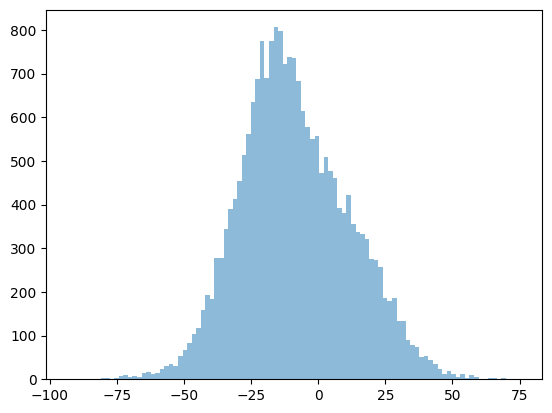

In [20]:
## lets see the histograam of SINR in each cell
## Plot histogram:
bins = np.linspace(math.ceil(np.min(l)), 
                   math.floor(np.max(l)),
                   100) # fixed number of bins
# bins = np.array([-6,-3, 6, 27])
plt.hist(l, bins=bins, alpha=0.5)


plt.show()

In [21]:
#### now we calculate the percentage distribution of SINR in each cell in these buckets bins = np.array([-6,-2, 2, 27]) and then add his to data set

In [22]:
bins = np.array([-40,4, 9, 40])
SINR_Distr=np.zeros([number_of_Samples,number_of_BS,3])
for i in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        d= data_set['SINR_mtx'][i][cell_nom][np.nonzero(data_set['SINR_mtx'][i][cell_nom]*data_set['UE_Ass_rnd_mtx'][i][cell_nom])].tolist()
        hist, edges = np.histogram(d,bins=bins)
        SINR_Distr[i,cell_nom]= hist/np.sum(hist)
    
SINR_Distr.shape

(1000, 7, 3)

In [23]:
data_set['SINR_Distr_mtx']= SINR_Distr

In [24]:
data_set['SINR_Distr_mtx'].shape

(1000, 7, 3)

## UEs relative distances

In [25]:
#### Now lets calculate new feature, Relative distance of UEs to all RUs, it is going to be (1000, 50, 7)
## sqrt{[x_j-x_i]**2 + [y_j-y_i]**2}

In [26]:
RE_relative_dist=np.zeros([number_of_Samples,number_of_UE,number_of_BS])
for i in range(number_of_Samples):
    for UE_nom in range(number_of_UE):
        ue = data_set['UE_pos'][i][UE_nom]
        bs = data_set['BS_pos'][i]
        dist= np.sqrt((bs[:,0]-ue[0])**2 + (bs[:,1]-ue[1])**2)
        Relative_dist = dist / np.max(dist)
        RE_relative_dist[i,UE_nom]= Relative_dist
    
RE_relative_dist.shape

(1000, 150, 7)

In [27]:
data_set['UE_relative_dist_mtx']= RE_relative_dist

In [28]:
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx'])

In [29]:
data_set['SINR_Distr_mtx'][1]

array([[0.5       , 0.0625    , 0.4375    ],
       [0.9       , 0.        , 0.1       ],
       [0.78571429, 0.07142857, 0.14285714],
       [0.76      , 0.08      , 0.16      ],
       [0.8       , 0.1       , 0.1       ],
       [0.58333333, 0.08333333, 0.33333333],
       [0.73684211, 0.10526316, 0.15789474]])

## Calculate PRB allocation

In [30]:
# for each sample and for each RU find the corresponding  UEs SNRs, and then find the MCS level, code rate and mod order

In [31]:
# MCS_SNR_df = pd.read_csv('data/SNR_MCS_Mapping.csv')
MCS_SNR_df = pd.read_csv('../../data/SNR_MCS_Mapping.csv', header=None, names=['MCS', 'Code_rate', 'Mod_order', 'SNR'])
power_map_df = pd.read_csv('../../data/Power_Model.csv', header=None, names=['PrB', 'Power_cons'])
power_map_df = power_map_df.drop([0]) 
power_map_df = power_map_df.astype(np.float16)
power_map_df

PrB  Power_cons
1     5.0       66.75
2    10.0       74.50
3    15.0       81.25
4    20.0       87.00
5    25.0       92.00
6    30.0       96.50
7    35.0      100.75
8    40.0      104.75
9    45.0      108.50
10   50.0      112.25
11   55.0      115.75
12   60.0      119.50
13   65.0      123.00
14   70.0      126.50
15   75.0      130.25
16   80.0      133.75
17   85.0      137.75
18   90.0      141.50
19   95.0      145.75
20  100.0      150.00

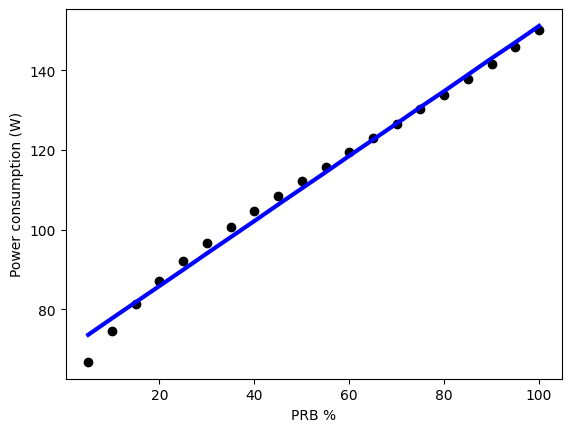

In [32]:
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()
x = [[x] for x in power_map_df['PrB'].values]
y = [[x] for x in power_map_df['Power_cons'].values]
# x= power_map_df[['PrB']].values.reshape(-1,1)
# y= power_map_df[['Power_cons']].values.reshape(-1,1)
regr.fit(x, y)

plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xlabel('PRB %')
plt.ylabel('Power consumption (W)')
plt.show()

In [33]:
print(regr.coef_)
print(regr.intercept_)

[[0.8164]]
[69.5]


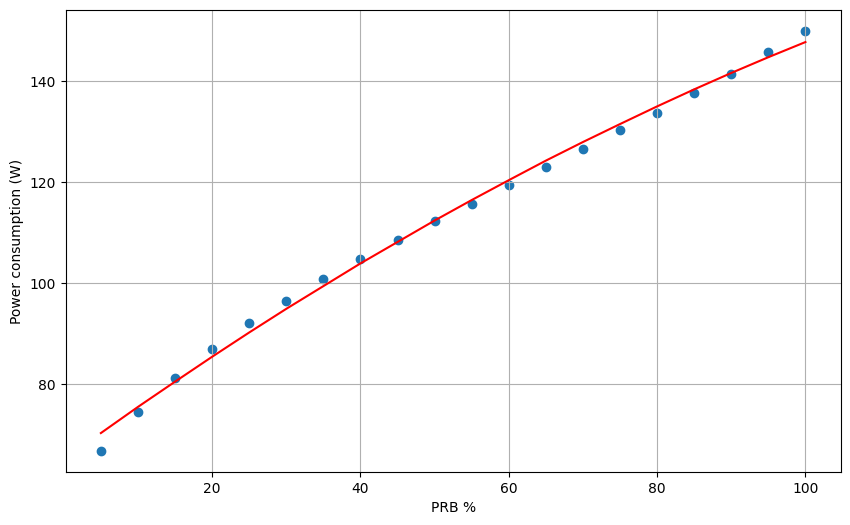

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
x_ = np.array([i[0] for i in x])
poly_features = poly.fit_transform(x_.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)

plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x, y_predicted, c="red")
plt.xlabel('PRB %')
plt.ylabel('Power consumption (W)')
plt.grid()
plt.show()

In [35]:
import torch
coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float16).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_)

In [36]:
coefs

tensor([[ 1.0664, -0.0024]], dtype=torch.float16)

In [37]:
poly_features

array([[5.000e+00, 2.500e+01],
       [1.000e+01, 1.000e+02],
       [1.500e+01, 2.250e+02],
       [2.000e+01, 4.000e+02],
       [2.500e+01, 6.250e+02],
       [3.000e+01, 9.000e+02],
       [3.500e+01, 1.225e+03],
       [4.000e+01, 1.600e+03],
       [4.500e+01, 2.025e+03],
       [5.000e+01, 2.500e+03],
       [5.500e+01, 3.024e+03],
       [6.000e+01, 3.600e+03],
       [6.500e+01, 4.224e+03],
       [7.000e+01, 4.900e+03],
       [7.500e+01, 5.624e+03],
       [8.000e+01, 6.400e+03],
       [8.500e+01, 7.224e+03],
       [9.000e+01, 8.100e+03],
       [9.500e+01, 9.024e+03],
       [1.000e+02, 1.000e+04]], dtype=float16)

In [38]:
# We add one row at the end for no connection case forcing PRBs and power to inf
MCS_SNR_df.loc[29] =[0, 1e-3, 1, -80]
MCS_SNR_df



MCS  Code_rate  Mod_order    SNR
0   28.0   0.925781        6.0  20.45
1   27.0   0.888672        6.0  18.55
2   26.0   0.852539        6.0  17.66
3   25.0   0.802704        6.0  16.55
4   24.0   0.753906        6.0  15.98
5   23.0   0.702148        6.0  14.80
6   22.0   0.650391        6.0  13.79
7   21.0   0.601562        6.0  12.66
8   20.0   0.553711        6.0  12.11
9   19.0   0.504883        6.0  11.65
10  18.0   0.455078        6.0  10.17
11  17.0   0.427734        6.0   9.55
12  16.0   0.642578        4.0   8.77
13  15.0   0.601562        4.0   7.92
14  14.0   0.540039        4.0   7.27
15  13.0   0.478516        4.0   6.09
16  12.0   0.423828        4.0   5.50
17  11.0   0.369141        4.0   4.65
18   9.0   0.663086        2.0   3.81
19  10.0   0.332031        4.0   3.79
20   8.0   0.587891        2.0   2.68
21   7.0   0.513672        2.0   1.70
22   6.0   0.438477        2.0   0.62
23   5.0   0.370117        2.0  -0.50
24   4.0   0.300781        2.0  -1.48
25   3.0   0.245117        2.0  -1.54
26   2.0   0.188477        2.0  -3.23
27   1.0   0.153320        2.0  -3.96
28   0.0   0.117188        2.0  -5.11
29   0.0   0.001000        1.0 -80.00

In [39]:
def first_neg(lst):
    res = [i for i,x in enumerate(lst) if x<0]
    return 29 if res == [] else res[0]

def SNR_mapping(d):
    mapped_SNRs = np.zeros(len(d))
    for ue in range(len(d)):
        idx = first_neg([snr_ref[s]- d[ue] for s in range(len(snr_ref))])
        mapped_SNRs[ue] = snr_ref [idx]
    return mapped_SNRs

BS_PRB_total=np.zeros([number_of_Samples,number_of_BS,1])
BS_PRB_Percent=np.zeros([number_of_Samples,number_of_BS,1])



#  d= data_set['SINR_mtx'][i][cell_nom][np.nonzero(data_set['SINR_mtx'][i][cell_nom]*data_set['UE_Ass_rnd_mtx'][i][cell_nom])].tolist()
for i in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        d = data_set['SINR_mtx'][i][cell_nom][np.nonzero(data_set['SINR_mtx'][i][cell_nom]*data_set['UE_Ass_rnd_mtx'][i][cell_nom])].tolist()
        snr_ref = MCS_SNR_df['SNR'].tolist() 
        mapped_SNRs = SNR_mapping(d)
        Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in mapped_SNRs]
        Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in mapped_SNRs]
        kbps = np.multiply(Mod_order , Code_rate)
        rate_PRB = 1000*12*14* kbps # Kbps
        UE_PRB = np.ceil(UE_rate_req/rate_PRB)
        BS_PRB_total[i, cell_nom] = sum(UE_PRB)
        BS_PRB_Percent[i, cell_nom] = (sum(UE_PRB)/Max_PRB)*100
        
data_set['BS_PRB_total']= BS_PRB_total
data_set['BS_PRB_Percent']= BS_PRB_Percent

KeyboardInterrupt: 

In [82]:
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx', 'BS_PRB_total', 'BS_PRB_Percent'])

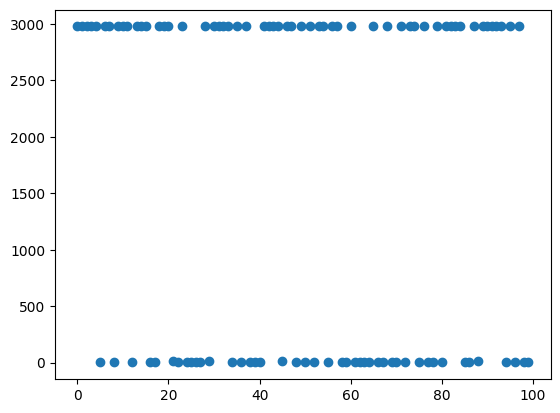

In [83]:
# example
import matplotlib.pyplot as plt
i=3
cell_nom=1

d = data_set['SINR_mtx'][i][cell_nom].tolist()#[np.argwhere(data_set['SINR_mtx'][i][cell_nom]> -5.11)].tolist()
snr_ref = MCS_SNR_df['SNR'].tolist() 
mapped_SNRs = SNR_mapping(d)
Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in mapped_SNRs]
Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in mapped_SNRs]
kbps = np.multiply(Mod_order , Code_rate)
rate_PRB = 1000*12*14* kbps # Kbps
UE_PRB = np.ceil(UE_rate_req/rate_PRB)
plt.plot(UE_PRB, 'o')
plt.show()

# Calculate Relative SNR per UE across all RUs

In [84]:
SNR_mtx_norm=np.zeros([number_of_Samples,number_of_BS,number_of_UE])
for i in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        std = 1 if data_set['SINR_mtx'][i][cell_nom].std() ==0 else data_set['SINR_mtx'][i][cell_nom].std()
        SNR_mtx_norm[i,cell_nom]= (data_set['SINR_mtx'][i][cell_nom] -data_set['SINR_mtx'][i][cell_nom].mean())/std
    
data_set['SNR_mtx_norm'] = SNR_mtx_norm

In [85]:
UE_SNR_RU_norm=np.zeros([number_of_Samples,number_of_UE,number_of_BS])
for i in range(number_of_Samples):
    for UE_nom in range(number_of_UE):
        UE_SNR_RU_norm[i,UE_nom]= data_set['SNR_mtx_norm'][i][:,UE_nom]
    
data_set['UE_SNR_RU_norm'] = UE_SNR_RU_norm

In [86]:
i=1
cell_nom=1
(data_set['SINR_mtx'][i][cell_nom])# -data_set['SINR_mtx'][i][cell_nom].mean())#/data_set['SINR_mtx'][i][cell_nom].std()

array([-21.87080727, -18.7450813 ,   6.23960253, -21.69000884,
        10.82196646, -24.24681432, -24.71302333,  -5.79600206,
       -23.30135318,  19.3794305 , -15.87397609, -27.52546658,
        -3.62575056,   2.18335396, -11.48548735, -18.00188049,
        12.9171188 , -22.09904979, -12.35530077, -14.58713686,
       -11.766303  , -21.43765917, -21.23107347,   5.56688733,
       -20.52246432,  -2.67461768, -48.13517916,  -4.22671925,
       -16.02105872, -28.5606311 , -17.80131773,  -8.57963657,
       -21.05873694, -22.87460528, -12.16599426, -15.64958695,
         7.94576856, -12.33309268,  18.16800601,  -2.30701463,
        30.18657046, -23.92082363, -28.5354915 ,  11.85867549,
       -43.65953801, -14.60760889, -33.17510362,  24.85108308,
       -16.31132793,  29.59264572, -10.14105286, -39.05626204,
       -61.64567392,   0.17681852,  -6.89087106,  -6.20230437,
         0.3470047 , -31.61075815, -30.18626362, -11.51127628,
        -6.29558507, -12.9544054 , -21.96844224,  19.00

In [87]:
data_set['SNR_mtx_norm'][1]

array([[ 8.54836011e-01,  1.10627922e+00, -1.62727478e+00,
         4.76574763e-02, -1.75492005e-01, -1.38976146e-01,
         6.14349942e-02,  1.10503984e+00,  1.39272811e-01,
         1.08029511e+00,  1.03014454e+00,  1.41416369e-01,
         5.99286231e-01, -6.06415869e-01,  1.19537109e+00,
        -1.01093242e-01, -1.28422766e+00,  2.65331346e+00,
         1.20613277e-01, -2.67189670e-01,  1.16618013e+00,
        -2.13690593e-01,  8.42400889e-01, -2.17585044e+00,
        -2.08234199e-01, -2.08851411e-01, -7.18981316e-01,
         9.48316126e-01, -1.62101513e+00,  1.33081055e+00,
        -6.96417600e-02,  1.41647801e+00,  8.98687939e-01,
         7.50221894e-01,  8.15887363e-01,  2.28978287e-01,
        -1.54511432e+00, -2.48930873e+00, -1.33252632e+00,
         1.66054822e+00, -8.85261563e-01,  3.95221875e-01,
         1.10407069e-01, -4.80634322e-01,  9.23116088e-01,
         1.23218402e+00, -1.16944617e-01, -2.50760965e+00,
        -8.48463524e-01, -1.86590103e+00,  7.05523860e-0

## Normalize the RSRP values


In [88]:
RSRP_mtx_norm=np.zeros([number_of_Samples,number_of_BS,number_of_UE])
for i in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        RSRP_mtx_norm[i,cell_nom]= (data_set['RSRP_mtx'][i][cell_nom] -data_set['RSRP_mtx'][i][cell_nom].mean())/data_set['RSRP_mtx'][i][cell_nom].std()
    
data_set['RSRP_mtx_norm'] = RSRP_mtx_norm

In [89]:
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx', 'BS_PRB_total', 'BS_PRB_Percent', 'SNR_mtx_norm', 'UE_SNR_RU_norm', 'RSRP_mtx_norm'])

## Identify the Cell Edge UEs

for each UE that has SNR_t > -5.11 for more than one cell counted as cell edge UE

In [90]:
Edge_UEs=np.zeros([number_of_Samples,number_of_UE,1])
for Sample in range(number_of_Samples):
    SNR_t = np.transpose(data_set['SINR_mtx'][Sample])
    SNR_tt = (SNR_t > -5.11).astype(int).sum(axis=1)-1
    Edge_UEs[Sample][:]= SNR_tt.reshape((number_of_UE,1))#(SNR_tt > 1).astype(int)
    
data_set['Edge_UE_indicator'] = Edge_UEs

In [91]:
Edge_UEs[1]

array([[3.],
       [3.],
       [1.],
       [2.],
       [3.],
       [3.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [2.],
       [3.],
       [3.],
       [3.],
       [2.],
       [2.],
       [3.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [1.],
       [2.],
       [3.],
       [2.],
       [3.],
       [1.],
       [3.],
       [3.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [1.],
       [1.],
       [1.],
       [3.],
       [2.],
       [3.],
       [3.],
       [4.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [3.],
       [3.],
       [2.],
       [4.],
       [2.],
       [2.],
       [3.],
       [3.],
       [2.],
       [2.],
       [1.],
       [2.],
       [3.],
       [3.],
       [2.],
       [3.],
       [3.],
       [3.],
       [4.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],

## Create the connection matrix between all UEs. 

for certain BS, All UEs who have SNR value above -5.11, are fully connected. So we find a connection matrix of size 50 x 50

In [92]:
Adj_mtx=np.zeros([number_of_Samples,number_of_UE,number_of_UE])
for Sample in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        ls = [i for i,x in enumerate(data_set['SINR_mtx'][Sample][cell_nom].tolist()) if x> -5.11]
        for s in ls: 
            Adj_mtx[Sample][ls,s ]=1 

data_set['Adj_mtx'] = Adj_mtx

In [93]:
connection_mtx= np.zeros([number_of_Samples,number_of_BS,number_of_UE])
for Sample in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        ls = [i for i,x in enumerate(data_set['SINR_mtx'][Sample][cell_nom].tolist()) if x> -5.11]
        connection_mtx[Sample][cell_nom,ls]=1
        
data_set['connection_mtx'] = connection_mtx

In [94]:
data_set.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx', 'BS_PRB_total', 'BS_PRB_Percent', 'SNR_mtx_norm', 'UE_SNR_RU_norm', 'RSRP_mtx_norm', 'Edge_UE_indicator', 'Adj_mtx', 'connection_mtx'])

In [95]:
data_set['UE_Ass_rsrp_mtx'][11].shape

(7, 100)

## PRB as a feature to UE

In [96]:
## How many prB required for each UE if it were supposed to be served by any of 7 BS (1000, 50, 7)

In [97]:
def first_neg(lst):
    res = [i for i,x in enumerate(lst) if x<0]
    return None if res == [] else res[0]

snr_ref = MCS_SNR_df['SNR'].tolist()
m= [snr_ref[i]- d[1] for i in range(len(snr_ref))]


In [98]:
i=1
Ue_nom=2

UE_SNRs = data_set['SINR_mtx'][i][:,Ue_nom]
dummy_list =  [snr_ref[t]- UE_SNRs[1] for t in range(len(snr_ref))]
# SNR_maps = [takeClosest(val,MCS_SNR_df['SNR'].tolist()) for val in UE_SNRs]
# Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in SNR_maps]
# Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in SNR_maps]
        
        

In [99]:
dummy_list
# first_neg(dummy_list)

[14.210397470759688,
 12.310397470759689,
 11.420397470759688,
 10.310397470759689,
 9.740397470759689,
 8.560397470759689,
 7.5503974707596875,
 6.4203974707596885,
 5.870397470759688,
 5.410397470759689,
 3.9303974707596883,
 3.310397470759689,
 2.530397470759688,
 1.6803974707596883,
 1.030397470759688,
 -0.1496025292403118,
 -0.7396025292403117,
 -1.5896025292403113,
 -2.4296025292403116,
 -2.4496025292403116,
 -3.5596025292403115,
 -4.5396025292403115,
 -5.619602529240312,
 -6.739602529240312,
 -7.719602529240312,
 -7.779602529240312,
 -9.469602529240312,
 -10.199602529240313,
 -11.349602529240311,
 -86.23960252924032]

In [100]:
data_set['SINR_mtx']

array([[[ 17.28671991,  15.5214883 ,  37.15989887, ...,  -3.6189883 ,
          -3.05508735,  -7.28391196],
        [-22.45356121, -24.12615663,  -2.48961812, ..., -22.83352175,
           6.15842519,   9.59058227],
        [-20.12536228, -50.19001445,   1.66147955, ...,  -5.29477993,
          39.3066525 ,  32.20156075],
        ...,
        [ 14.60321469,  40.14129853,  -3.18653517, ...,   1.40201944,
         -40.37113708, -39.62572413],
        [ 10.08586738,  -9.83686554,  -9.95219988, ...,  21.76004977,
         -29.19536469,  -9.63669646],
        [-16.16095511, -40.670745  , -10.54792738, ...,  -6.3177755 ,
         -50.59900829, -33.16802324]],

       [[ 16.5856926 ,  20.01820895, -17.29824478, ...,  -6.85848627,
          12.15606045,  12.73347312],
        [-21.87080727, -18.7450813 ,   6.23960253, ...,  -7.96243368,
         -14.41944448, -13.50400744],
        [-18.56545213,   1.97727497,  18.51821213, ..., -24.59928774,
          17.27867585,  11.90643964],
        ...,


In [101]:
def first_neg(lst):
    res = [i for i,x in enumerate(lst) if x<0]
    return 29 if res == [] else res[0]

def SNR_mapping(d):
    mapped_SNRs = np.zeros(len(d))
    for ue in range(number_of_UE):
        idx = first_neg(snr_ref- d[ue] )
        mapped_SNRs[ue] = snr_ref [idx]
    return mapped_SNRs

BS_PRB_total=np.zeros([number_of_Samples,number_of_BS,1])
BS_PRB_Percent=np.zeros([number_of_Samples,number_of_BS,1])



for i in range(number_of_Samples):
    for cell_nom in range(number_of_BS):
        d = data_set['SINR_mtx'][i][cell_nom]
        snr_ref = MCS_SNR_df['SNR'].tolist() 
        mapped_SNRs = SNR_mapping(d)
        Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in mapped_SNRs]
        Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in mapped_SNRs]
        kbps = np.multiply(Mod_order , Code_rate)
        rate_PRB = 1000*12*14* kbps # Kbps
        UE_PRB = np.ceil(UE_rate_req/rate_PRB)
        BS_PRB_total[i, cell_nom] = sum(UE_PRB)
        BS_PRB_Percent[i, cell_nom] = (sum(UE_PRB)/Max_PRB)*100
        
data_set['BS_PRB_total']= BS_PRB_total
data_set['BS_PRB_Percent']= BS_PRB_Percent

In [102]:
data_set['BS_PRB_total'][1]

array([[ 59776.],
       [199574.],
       [166886.],
       [157898.],
       [166850.],
       [184691.],
       [175829.]])

In [103]:
UE_PRB_All_BS=np.zeros([number_of_Samples,number_of_UE, number_of_BS])

def first_neg(lst):
    res = [i for i,x in enumerate(lst) if x<0]
    return 29 if res == [] else res[0]

def SNR_mapping(d):
    mapped_SNRs = np.zeros(len(d))
    for ue in range(len(d)):
        idx = first_neg([snr_ref[s]- d[ue] for s in range(len(snr_ref))])
        mapped_SNRs[ue] = snr_ref [idx]
    return mapped_SNRs
        
for i in range(number_of_Samples):
    for Ue_nom in range(number_of_UE):
        UE_SNRs = data_set['SINR_mtx'][i][:,Ue_nom]
        snr_ref = MCS_SNR_df['SNR'].tolist() 
        mapped_SNRs = SNR_mapping(UE_SNRs)
        Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in mapped_SNRs]
        Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in mapped_SNRs]
        kbps = np.multiply(Mod_order , Code_rate)
        rate_PRB = 1000*12*14* kbps # Kbps
        UE_PRB_All_BS[i][Ue_nom] = np.ceil(UE_rate_req/rate_PRB)
        
data_set['UE_aggPRB_norm']= UE_PRB_All_BS



In [104]:
data_set['UE_aggPRB_norm'][1][12]

array([1.000e+00, 1.000e+01, 2.977e+03, 2.977e+03, 2.977e+03, 3.000e+00,
       1.000e+00])

In [105]:
UE_Ass_sinr_mtx=np.zeros([number_of_Samples,number_of_UE, number_of_BS])

for i in range(number_of_Samples):
    arr= data_set['SINR_mtx'][i].transpose()
    # Getting max values by row and changing dimension
    max = arr.max(axis=1).reshape(-1, 1)
    # Setting max values as 1 and other as 0
    UE_Ass_sinr_mtx[i] = np.where(arr == max, 1, 0)

data_set['UE_Ass_sinr_mtx'] = UE_Ass_sinr_mtx

In [106]:
UE_Ass_rsrp_mtx=np.zeros([number_of_Samples,number_of_UE, number_of_BS])

for i in range(number_of_Samples):
    arr= data_set['RSRP_mtx'][i].transpose()
    # Getting max values by row and changing dimension
    max = arr.max(axis=1).reshape(-1, 1)
    # Setting max values as 1 and other as 0
    UE_Ass_rsrp_mtx[i] = np.where(arr == max, 1, 0)

data_set['UE_Ass_rsrp_mtx'] = UE_Ass_rsrp_mtx

In [107]:
## PRB features
UE_PRB_Feature_mtx=np.zeros([number_of_Samples,number_of_UE, number_of_BS])

for i in range(number_of_Samples):
    arr= data_set['UE_aggPRB_norm'][i].copy()
    arr[arr > 1000] = 0
    UE_PRB_Feature_mtx[i] =arr

data_set['UE_PRB_Feature_mtx'] = UE_PRB_Feature_mtx

In [108]:
data_set['UE_PRB_Feature_mtx']

array([[[ 1.,  0.,  0., ...,  1.,  2.,  0.],
        [ 1.,  0.,  0., ...,  1.,  0.,  0.],
        [ 1.,  8.,  4., ...,  8.,  0.,  0.],
        ...,
        [10.,  0.,  0., ...,  4.,  1.,  0.],
        [ 8.,  2.,  1., ...,  0.,  0.,  0.],
        [ 0.,  2.,  1., ...,  0.,  0.,  0.]],

       [[ 1.,  0.,  0., ...,  2.,  8.,  0.],
        [ 1.,  0.,  3., ...,  0.,  1.,  8.],
        [ 0.,  2.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  2.,  1.],
        [ 1.,  0.,  1., ...,  0.,  0.,  0.],
        [ 1.,  0.,  1., ...,  0.,  0.,  0.]],

       [[ 1.,  0.,  3., ...,  0.,  0., 10.],
        [ 2.,  8.,  1., ...,  0.,  0.,  0.],
        [ 5.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 1.,  0.,  0., ...,  1.,  8.,  0.],
        [13.,  0.,  1., ...,  0.,  0.,  0.],
        [ 3.,  5.,  0., ...,  0.,  5.,  1.]],

       ...,

       [[ 1.,  0.,  0., ...,  2.,  5.,  0.],
        [ 0.,  3.,  1., ...,  0.,  0.,  0.],
        [ 1.,  0.,  3., ...,  0.,  0.,  0.

### Save data 

In [110]:
import pickle 

# with open('../data/Exterem_Test1_Data_processed_Correct_SINR_NewData_ODFM.pkl', 'wb') as f:
#     pickle.dump(data_set, f)

with open('../data/Data_processed_NarrowBand_freqReuse_UniformData_SINR_OFDM_1000ISD_BW20_PRB50_150UE.pkl', 'wb') as f:
    pickle.dump(data_set, f)

In [39]:
Max_PRB

55

# Load data

In [40]:
import pickle 
name = '../../data/Data_processed_NarrowBand_freqReuse_UniformData_SINR_OFDM_1000ISD_BW20_PRB50_150UE.pkl'
# name = 'data/Data_processed.pkl'

with open(name, 'rb') as f:
    data_set_processed = pickle.load(f)
    
data_set_processed.keys()


dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx', 'BS_PRB_total', 'BS_PRB_Percent', 'SNR_mtx_norm', 'UE_SNR_RU_norm', 'RSRP_mtx_norm', 'Edge_UE_indicator', 'Adj_mtx', 'connection_mtx', 'UE_aggPRB_norm', 'UE_Ass_sinr_mtx', 'UE_PRB_Feature_mtx'])

In [41]:
data_set_processed.keys()

dict_keys(['BS_pos', 'RSRP_mtx', 'SINR_mtx', 'UE_Ass_mtx', 'UE_pos', 'UE_Ass_rsrp_mtx', 'UE_Ass_rnd_mtx', 'SINR_Distr_mtx', 'UE_relative_dist_mtx', 'BS_PRB_total', 'BS_PRB_Percent', 'SNR_mtx_norm', 'UE_SNR_RU_norm', 'RSRP_mtx_norm', 'Edge_UE_indicator', 'Adj_mtx', 'connection_mtx', 'UE_aggPRB_norm', 'UE_Ass_sinr_mtx', 'UE_PRB_Feature_mtx'])

# Build Homo Graph

In [42]:
UE_features = np.concatenate((data_set_processed['UE_relative_dist_mtx'][1], data_set_processed['UE_SNR_RU_norm'][1]), axis=1)

In [43]:
data_set_processed['UE_SNR_RU_norm'][1].shape

(150, 7)

 here we create a graph:
 - The Ue features are 
 \begin{equation}
UE\, features = [(d_1,d_2, \cdots, d_K), \,\,\, (SNR_1, SNR_2, \cdots ,SNR_K),\,\,\, (PRB_1, PRB_2, PRB_K)]
 \end{equation}
 and 
 
  \begin{equation}
BS\, features = [PRB, \,\,\, (H, M, L)]
 \end{equation}
 wher H, M, L are the number of UEs with high, medium and low SNR in that cell (a measure on the distribution of UEs in that cell)

## Test: create graph of data for one sample

In [44]:
sample =0 
number_of_UE= 150
number_of_BS= 7
UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample]), axis=1)
BS_feature_mtx = np.concatenate((data_set_processed['BS_PRB_Percent'][sample], data_set_processed['SINR_Distr_mtx'][sample]), axis=1)
RSRP_matrix = data_set_processed['RSRP_mtx_norm'][sample]
link_features = np.reshape(RSRP_matrix, number_of_BS*number_of_UE, order='F')
link_features

array([ 3.07643842, -0.36269032, -0.32469637, ..., -0.80681631,
       -1.24117664,  2.12974189])

In [45]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.data import Data

import itertools
import torch_geometric.transforms as T

UE_id = list(range(number_of_UE))
BS_id = list(range(number_of_BS))

data = HeteroData()

conn_idx = torch.tensor(list(itertools.product(UE_id, BS_id)))
edge_idx = torch.transpose(conn_idx,0, 1)

data['UE'].node_id = torch.arange(len(UE_id))
data['BS'].node_id = torch.arange(len(BS_id))

data['UE'].x = torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
data['BS'].x = torch.from_numpy(BS_feature_mtx).to(torch.float) # [num_BS, num_features_BS]
data['UE', 'BS'].edge_index = edge_idx # [2, num_edges]
data['UE', 'BS'].edge_attr = torch.from_numpy(link_features).to(torch.float) # [num_edges, num_features]

# We also need to make sure to add the reverse edges from BS to UE
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)



UE_id = list(range(number_of_UE))
conn_idx = torch.tensor(list(itertools.product(UE_id, UE_id)))
edge_index = torch.transpose(conn_idx,0, 1)
x= torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
Homodata = Data(x=x, edge_index=edge_index)
Homodata['cc']=1


# Create a list of graphs for all data set

In [46]:
# import torch
# from torch_geometric.data import HeteroData
# from torch_geometric.data import Data

# import itertools

# def create_Hetro_graph(data_set_processed, sample):
    
#     UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample]), axis=1)
#     BS_feature_mtx = np.concatenate((data_set_processed['BS_PRB_Percent'][sample], data_set_processed['SINR_Distr_mtx'][sample]), axis=1)
#     RSRP_matrix = data_set_processed['RSRP_mtx_norm'][sample]
#     SINR_matrix = data_set_processed['SINR_mtx'][sample]
#     link_features = np.reshape(RSRP_matrix, number_of_BS*number_of_UE, order='F')
#     sinr_link_features = np.reshape(SINR_matrix, number_of_BS*number_of_UE, order='F')
    
#     UE_id = list(range(number_of_UE))
#     BS_id = list(range(number_of_BS))

#     data = HeteroData()

#     conn_idx = torch.tensor(list(itertools.product(UE_id, BS_id)))
#     edge_idx = torch.transpose(conn_idx,0, 1)

#     data['UE'].node_id = torch.arange(len(UE_id))
#     data['BS'].node_id = torch.arange(len(BS_id))

#     data['UE'].x = torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
#     data['BS'].x = torch.from_numpy(BS_feature_mtx).to(torch.float) # [num_BS, num_features_BS]
#     data['UE', 'BS'].edge_index = edge_idx # [2, num_edges]
#     data['UE', 'BS'].edge_attr = torch.from_numpy(link_features).to(torch.float) # [num_edges, num_features]
# #     data['UE', 'sinr','BS'].edge_index = edge_idx # [2, num_edges]
# #     data['UE', 'sinr','BS'].edge_attr = torch.from_numpy(sinr_link_features).to(torch.float) # [num_edges, num_features]

#     # We also need to make sure to add the reverse edges from BS to UE
#     # in order to let a GNN be able to pass messages in both directions.
#     # We can leverage the `T.ToUndirected()` transform for this from PyG:
#     data = T.ToUndirected()(data)
#     data = T.AddSelfLoops()(data)
#     data = T.NormalizeFeatures()(data)
#     data['SINR_mtx'] =torch.from_numpy(data_set_processed['SINR_mtx'][sample]).to(torch.float)
#     data['UE_PRB_All_cells'] =torch.from_numpy(data_set_processed['UE_aggPRB_norm'][sample]).to(torch.float)
#     data['UE_Ass_rsrp_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_rsrp_mtx'][sample]).to(torch.float)
    


#     return data






In [47]:
data_set_processed['UE_aggPRB_norm'][sample]

array([[1.000e+00, 2.977e+03, 2.977e+03, ..., 2.000e+00, 2.977e+03,
        2.977e+03],
       [8.000e+00, 2.977e+03, 2.977e+03, ..., 2.977e+03, 1.000e+00,
        1.000e+00],
       [2.977e+03, 2.977e+03, 1.000e+00, ..., 2.977e+03, 2.977e+03,
        2.977e+03],
       ...,
       [2.000e+00, 2.977e+03, 2.977e+03, ..., 1.000e+00, 1.000e+00,
        2.977e+03],
       [2.000e+00, 2.977e+03, 8.000e+00, ..., 8.000e+00, 4.000e+00,
        1.300e+01],
       [8.000e+00, 5.000e+00, 2.977e+03, ..., 2.977e+03, 2.977e+03,
        1.000e+00]])

In [48]:
adj_t= data_set_processed['Adj_mtx'][1]
edge_index = torch.tensor(adj_t.nonzero())
edge_index

tensor([[  0,   0,   0,  ..., 149, 149, 149],
        [  0,   1,   2,  ..., 147, 148, 149]])

In [49]:
np.nonzero(data_set_processed['Edge_UE_indicator'][sample])[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [50]:
# def create_Homo_graph(data_set_processed, sample):
    
    
#     adj_t= data_set_processed['Adj_mtx'][sample]
#     edge_index = torch.tensor(adj_t.nonzero())
# #     x= torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
#     UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample], data_set_processed['Edge_UE_indicator'][sample]), axis=1)

#     x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
#     Homodata = Data(x=x, edge_index=edge_index)
    
#     Homodata = T.AddSelfLoops()(Homodata)
#     Homodata = T.NormalizeFeatures()(Homodata)
    
#     Homodata['SINR_mtx'] =torch.from_numpy(data_set_processed['SINR_mtx'][sample]).to(torch.float)
#     Homodata['UE_PRB_All_cells'] =torch.from_numpy(data_set_processed['UE_aggPRB_norm'][sample]).to(torch.float)
#     Homodata['UE_Ass_rsrp_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_rsrp_mtx'][sample]).to(torch.float)
#     Homodata['UE_Ass_sinr_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_sinr_mtx'][sample]).to(torch.float)
#     Homodata['Conn_mtx'] =  torch.from_numpy(np.transpose(data_set_processed['connection_mtx'][sample])).to(torch.float) 
#     Homodata['Cell_Edge_id'] =  torch.from_numpy(np.nonzero(data_set_processed['Edge_UE_indicator'][sample])[0]).to(torch.float) 
    
    
#     return Homodata

# data_set_processed['UE_PRB_Feature_mtx']
def create_Homo_graph(data_set_processed, sample):
    
    
    adj_t= data_set_processed['Adj_mtx'][sample]
    edge_index = torch.tensor(adj_t.nonzero())
#     x= torch.from_numpy(UE_feature_mtx).to(torch.float) # [num_UE, num_features_UE]
#     UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample], data_set_processed['Edge_UE_indicator'][sample]), axis=1)
    UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample], data_set_processed['UE_PRB_Feature_mtx'][sample]), axis=1)



    x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
    Homodata = Data(x=x, edge_index=edge_index)
    
    Homodata = T.AddSelfLoops()(Homodata)
#     Homodata = T.NormalizeFeatures()(Homodata)
    
    Homodata['SINR_mtx'] =torch.from_numpy(data_set_processed['SINR_mtx'][sample]).to(torch.float)
    Homodata['UE_PRB_All_cells'] =torch.from_numpy(data_set_processed['UE_aggPRB_norm'][sample]).to(torch.float)
    Homodata['UE_Ass_rsrp_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_rsrp_mtx'][sample]).to(torch.float)
    Homodata['UE_Ass_sinr_mtx'] =torch.from_numpy(data_set_processed['UE_Ass_sinr_mtx'][sample]).to(torch.float)
    Homodata['Conn_mtx'] =  torch.from_numpy(np.transpose(data_set_processed['connection_mtx'][sample])).to(torch.float) 
    Homodata['Cell_Edge_id'] =  torch.from_numpy(np.nonzero(data_set_processed['Edge_UE_indicator'][sample])[0]).to(torch.float) 
    
    
    return Homodata

In [51]:
sample=1
UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample], data_set_processed['UE_PRB_Feature_mtx'][sample]), axis=1)
# print(UE_feature_mtx[sample])
x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
Homodata = Data(x=x, edge_index=edge_index)
# Homodata = T.NormalizeFeatures()(Homodata)
# Homodata = T.AddSelfLoops()(Homodata)
print(Homodata.x[10])

tensor([ 0.4410,  0.1594,  0.5967,  0.9183,  1.0000,  0.8181,  0.4267, -1.1558,
         1.5420,  0.2621, -0.5712, -0.3042, -1.4102,  0.4744,  0.0000,  1.0000,
        13.0000,  0.0000,  0.0000,  0.0000,  3.0000])


In [52]:
print(Homodata.x[30])

tensor([ 0.5011,  0.8809,  1.0000,  0.8512,  0.4743,  0.0297,  0.5257,  1.4933,
        -1.7631, -0.4800, -2.0810, -0.4227,  2.3849,  1.0276,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  1.0000])


In [53]:
data_set_processed['UE_aggPRB_norm'][sample]

array([[1.000e+00, 2.977e+03, 2.977e+03, ..., 1.000e+00, 2.977e+03,
        2.977e+03],
       [1.000e+00, 2.977e+03, 3.000e+00, ..., 1.300e+01, 2.977e+03,
        2.977e+03],
       [8.000e+00, 2.977e+03, 2.977e+03, ..., 2.977e+03, 3.000e+00,
        1.000e+00],
       ...,
       [2.977e+03, 2.977e+03, 2.977e+03, ..., 2.977e+03, 2.000e+00,
        1.000e+00],
       [4.000e+00, 2.977e+03, 1.000e+00, ..., 2.977e+03, 2.977e+03,
        2.977e+03],
       [1.000e+00, 2.977e+03, 2.977e+03, ..., 1.000e+00, 2.000e+00,
        2.977e+03]])

In [54]:
# Graph_data_UE_dict = dict() ## the key is UE numbers and the value is the list of HeteroData graphs defined over each time stamp
Graph_list = []
number_of_Samples=1000
for sample in range(number_of_Samples):

    print('Sample = {}'.format(sample))
    Sample_homo_graph = create_Homo_graph(data_set_processed, sample)
    Graph_list.append(Sample_homo_graph)
        

Sample = 0
Sample = 1
Sample = 2
Sample = 3
Sample = 4
Sample = 5
Sample = 6
Sample = 7
Sample = 8
Sample = 9
Sample = 10
Sample = 11
Sample = 12
Sample = 13
Sample = 14
Sample = 15
Sample = 16
Sample = 17
Sample = 18
Sample = 19
Sample = 20
Sample = 21
Sample = 22
Sample = 23
Sample = 24
Sample = 25
Sample = 26
Sample = 27
Sample = 28
Sample = 29
Sample = 30
Sample = 31
Sample = 32
Sample = 33
Sample = 34
Sample = 35
Sample = 36
Sample = 37
Sample = 38
Sample = 39
Sample = 40
Sample = 41
Sample = 42
Sample = 43
Sample = 44
Sample = 45
Sample = 46
Sample = 47
Sample = 48
Sample = 49
Sample = 50
Sample = 51
Sample = 52
Sample = 53
Sample = 54
Sample = 55
Sample = 56
Sample = 57
Sample = 58
Sample = 59
Sample = 60
Sample = 61
Sample = 62
Sample = 63
Sample = 64
Sample = 65
Sample = 66
Sample = 67
Sample = 68
Sample = 69
Sample = 70
Sample = 71
Sample = 72
Sample = 73
Sample = 74
Sample = 75
Sample = 76
Sample = 77
Sample = 78
Sample = 79
Sample = 80
Sample = 81
Sample = 82
Sample = 83
Sa

Sample = 682
Sample = 683
Sample = 684
Sample = 685
Sample = 686
Sample = 687
Sample = 688
Sample = 689
Sample = 690
Sample = 691
Sample = 692
Sample = 693
Sample = 694
Sample = 695
Sample = 696
Sample = 697
Sample = 698
Sample = 699
Sample = 700
Sample = 701
Sample = 702
Sample = 703
Sample = 704
Sample = 705
Sample = 706
Sample = 707
Sample = 708
Sample = 709
Sample = 710
Sample = 711
Sample = 712
Sample = 713
Sample = 714
Sample = 715
Sample = 716
Sample = 717
Sample = 718
Sample = 719
Sample = 720
Sample = 721
Sample = 722
Sample = 723
Sample = 724
Sample = 725
Sample = 726
Sample = 727
Sample = 728
Sample = 729
Sample = 730
Sample = 731
Sample = 732
Sample = 733
Sample = 734
Sample = 735
Sample = 736
Sample = 737
Sample = 738
Sample = 739
Sample = 740
Sample = 741
Sample = 742
Sample = 743
Sample = 744
Sample = 745
Sample = 746
Sample = 747
Sample = 748
Sample = 749
Sample = 750
Sample = 751
Sample = 752
Sample = 753
Sample = 754
Sample = 755
Sample = 756
Sample = 757
Sample = 758

## Create Train and Test data set

In [55]:
from random import shuffle
import math 
import torch
test_percentage= .2

# torch.manual_seed(12345)
shuffle(Graph_list)

test_size = math.ceil(len(Graph_list)*test_percentage)
train_size = len(Graph_list) - test_size

Graph_list_train = Graph_list[:train_size]
Graph_list_test = Graph_list[train_size:]

print(f'Number of training graphs: {len(Graph_list_train)}')
print(f'Number of test graphs: {len(Graph_list_test)}')

Number of training graphs: 800
Number of test graphs: 200


In [56]:
from torch_geometric.loader import DataLoader
batch_size_train =1
batch_size_test =1

train_loader = DataLoader(Graph_list_train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(Graph_list_test, batch_size=batch_size_test, shuffle=False)
# Extereme_test_loader = DataLoader(Extereme_Test_Graph_list, batch_size=batch_size_test, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data.x)
    print()
    

Step 1:
Number of graphs in the current batch: 1
tensor([[0.4422, 0.3677, 0.7818,  ..., 0.0000, 5.0000, 1.0000],
        [0.3876, 1.0000, 0.8947,  ..., 1.0000, 0.0000, 0.0000],
        [0.5562, 0.7407, 0.2901,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1655, 0.6700, 0.7543,  ..., 0.0000, 0.0000, 3.0000],
        [0.5693, 0.2129, 0.3675,  ..., 0.0000, 0.0000, 0.0000],
        [0.5749, 0.1796, 0.6051,  ..., 0.0000, 0.0000, 2.0000]])

Step 2:
Number of graphs in the current batch: 1
tensor([[ 0.4066,  0.9678,  1.0000,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.3530,  0.8027,  1.0000,  ...,  0.0000,  2.0000,  1.0000],
        [ 0.5542,  0.2230,  0.6813,  ...,  0.0000,  0.0000,  2.0000],
        ...,
        [ 0.5304,  0.0943,  0.4386,  ...,  0.0000,  0.0000,  4.0000],
        [ 0.3708,  0.2592,  0.5624,  ...,  0.0000,  0.0000,  5.0000],
        [ 0.5164,  0.8838,  1.0000,  ..., 13.0000,  1.0000,  3.0000]])

Step 3:
Number of graphs in the current batch: 1
tensor([[0.2655, 1.

tensor([[ 0.5105,  0.9139,  1.0000,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.5604,  0.1248,  0.5391,  ...,  0.0000,  0.0000, 13.0000],
        [ 0.0790,  1.0000,  0.9383,  ...,  3.0000,  3.0000,  0.0000],
        ...,
        [ 0.5506,  0.8739,  0.5186,  ...,  3.0000,  0.0000,  0.0000],
        [ 0.0895,  0.9267,  0.8454,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4664,  0.7600,  0.3239,  ...,  0.0000,  0.0000,  0.0000]])

Step 74:
Number of graphs in the current batch: 1
tensor([[0.3280, 0.4167, 0.4660,  ..., 0.0000, 0.0000, 0.0000],
        [0.5893, 0.8664, 0.5164,  ..., 2.0000, 0.0000, 0.0000],
        [0.5348, 0.7379, 0.2797,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5787, 1.0000, 0.9346,  ..., 1.0000, 8.0000, 0.0000],
        [0.4850, 0.8779, 1.0000,  ..., 2.0000, 1.0000, 0.0000],
        [0.3624, 0.3735, 0.4130,  ..., 0.0000, 0.0000, 3.0000]])

Step 75:
Number of graphs in the current batch: 1
tensor([[0.6140, 0.5924, 0.9072,  ..., 0.0000, 2.0000, 1.0000],
  

Step 101:
Number of graphs in the current batch: 1
tensor([[ 0.2206,  0.9317,  0.7256,  ...,  5.0000,  0.0000,  0.0000],
        [ 0.4734,  0.6373,  0.9444,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.4518,  0.1854,  0.3818,  ..., 13.0000,  0.0000,  0.0000],
        ...,
        [ 0.5325,  0.7245,  0.2607,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5207,  0.7658,  1.0000,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.5180,  0.6748,  0.2023,  ...,  0.0000,  0.0000,  0.0000]])

Step 102:
Number of graphs in the current batch: 1
tensor([[0.5438, 0.1580, 0.6223,  ..., 0.0000, 0.0000, 1.0000],
        [0.5504, 0.8685, 1.0000,  ..., 0.0000, 1.0000, 3.0000],
        [0.5474, 0.8981, 1.0000,  ..., 0.0000, 1.0000, 4.0000],
        ...,
        [0.5788, 0.2136, 0.3876,  ..., 0.0000, 0.0000, 0.0000],
        [0.5064, 0.4905, 0.0168,  ..., 0.0000, 0.0000, 0.0000],
        [0.5524, 0.2517, 0.3008,  ..., 0.0000, 0.0000, 0.0000]])

Step 103:
Number of graphs in the current batch: 1
tensor([[0.33

Step 183:
Number of graphs in the current batch: 1
tensor([[0.5488, 0.9438, 0.6374,  ..., 3.0000, 0.0000, 0.0000],
        [0.5140, 0.3455, 0.1790,  ..., 0.0000, 0.0000, 0.0000],
        [0.5997, 0.8222, 0.4472,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5449, 0.6229, 0.9355,  ..., 0.0000, 1.0000, 2.0000],
        [0.5524, 0.2699, 0.2825,  ..., 0.0000, 0.0000, 0.0000],
        [0.5676, 1.0000, 0.8015,  ..., 1.0000, 0.0000, 0.0000]])

Step 184:
Number of graphs in the current batch: 1
tensor([[0.5561, 1.0000, 0.9829,  ..., 1.0000, 1.0000, 0.0000],
        [0.5298, 0.4204, 0.1099,  ..., 0.0000, 0.0000, 0.0000],
        [0.4892, 0.5684, 0.0823,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5016, 0.0716, 0.5620,  ..., 0.0000, 0.0000, 3.0000],
        [0.5531, 0.8559, 1.0000,  ..., 0.0000, 1.0000, 3.0000],
        [0.3092, 0.6285, 0.9060,  ..., 0.0000, 0.0000, 3.0000]])

Step 185:
Number of graphs in the current batch: 1
tensor([[ 0.5169,  0.9690,  0.6783,  ...,  1.0000

tensor([[ 0.4635,  0.8870,  0.5388,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.1606,  0.8487,  0.7070,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.5745,  1.0000,  0.9539,  ...,  2.0000,  2.0000,  0.0000],
        ...,
        [ 0.3811,  1.0000,  0.8032,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.2532,  0.6124,  0.5053,  ..., 10.0000,  0.0000,  0.0000],
        [ 0.5341,  0.9216,  0.5978,  ...,  2.0000,  0.0000,  0.0000]])

Step 214:
Number of graphs in the current batch: 1
tensor([[ 0.5582,  0.7536,  0.3134,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5836,  1.0000,  0.9397,  ...,  1.0000,  2.0000,  0.0000],
        [ 0.5160,  0.8109,  0.4050,  ...,  3.0000,  0.0000,  0.0000],
        ...,
        [ 0.5012,  0.9801,  0.6977,  ...,  4.0000,  0.0000, 13.0000],
        [ 0.5071,  0.1174,  0.6015,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5592,  0.8756,  0.5233,  ...,  2.0000,  0.0000,  0.0000]])

Step 215:
Number of graphs in the current batch: 1
tensor([[ 0.5044,  1.0000,  

Step 292:
Number of graphs in the current batch: 1
tensor([[0.5440, 0.2595, 0.2855,  ..., 0.0000, 0.0000, 0.0000],
        [0.4471, 1.0000, 0.8835,  ..., 1.0000, 3.0000, 0.0000],
        [0.5840, 0.8381, 0.4672,  ..., 2.0000, 0.0000, 0.0000],
        ...,
        [0.5721, 0.7792, 0.3627,  ..., 0.0000, 0.0000, 0.0000],
        [0.3839, 1.0000, 0.9613,  ..., 2.0000, 3.0000, 0.0000],
        [0.5505, 0.4185, 0.1415,  ..., 0.0000, 0.0000, 0.0000]])

Step 293:
Number of graphs in the current batch: 1
tensor([[ 0.5583,  0.6268,  0.9367,  ..., 13.0000,  1.0000,  3.0000],
        [ 0.3999,  1.0000,  0.9239,  ...,  1.0000,  3.0000,  0.0000],
        [ 0.4826,  0.5073,  0.8699,  ...,  0.0000,  2.0000,  1.0000],
        ...,
        [ 0.3904,  0.7803,  0.3956,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4116,  0.3394,  0.3301,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5648,  0.2120,  0.3603,  ...,  0.0000,  0.0000,  3.0000]])

Step 294:
Number of graphs in the current batch: 1
tensor([[0.60

Step 320:
Number of graphs in the current batch: 1
tensor([[ 0.5090,  0.7991,  1.0000,  ...,  0.0000,  1.0000,  2.0000],
        [ 0.4452,  0.8150,  0.4201,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3853,  0.5912,  0.9058,  ...,  0.0000, 13.0000,  1.0000],
        ...,
        [ 0.5706,  0.6395,  0.9430,  ...,  5.0000,  5.0000,  5.0000],
        [ 0.5161,  0.6426,  0.1655,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2419,  0.6027,  0.5503,  ...,  5.0000,  0.0000, 13.0000]])

Step 321:
Number of graphs in the current batch: 1
tensor([[0.5236, 0.5682, 0.0891,  ..., 0.0000, 0.0000, 0.0000],
        [0.6004, 0.2013, 0.5171,  ..., 0.0000, 0.0000, 2.0000],
        [0.4441, 0.9179, 0.5954,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.5602, 0.2296, 0.3334,  ..., 0.0000, 0.0000, 0.0000],
        [0.5319, 0.7005, 0.2338,  ..., 0.0000, 0.0000, 0.0000],
        [0.5808, 0.8008, 0.4032,  ..., 8.0000, 0.0000, 0.0000]])

Step 322:
Number of graphs in the current batch: 1
tensor([[ 0.5

tensor([[ 0.2136,  0.9888,  0.8183,  ...,  3.0000,  7.0000,  0.0000],
        [ 0.5836,  0.7993,  0.4019,  ...,  5.0000,  0.0000,  0.0000],
        [ 0.5849,  1.0000,  0.9272,  ...,  1.0000, 10.0000,  0.0000],
        ...,
        [ 0.5482,  0.7301,  0.9981,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.5582,  0.8938,  0.5540,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.2500,  0.5043,  0.6332,  ...,  0.0000,  5.0000,  0.0000]])

Step 410:
Number of graphs in the current batch: 1
tensor([[ 0.5046,  0.7982,  1.0000,  ..., 13.0000,  1.0000,  3.0000],
        [ 0.3162,  0.8526,  0.5459,  ...,  8.0000,  2.0000,  0.0000],
        [ 0.2355,  0.7344,  0.9447,  ...,  0.0000,  0.0000,  2.0000],
        ...,
        [ 0.4021,  1.0000,  0.7619,  ...,  3.0000,  0.0000, 10.0000],
        [ 0.2719,  0.7443,  0.9653,  ...,  0.0000, 13.0000,  1.0000],
        [ 0.4899,  1.0000,  0.7432,  ...,  3.0000,  3.0000,  0.0000]])

Step 411:
Number of graphs in the current batch: 1
tensor([[0.5965, 0.8224, 0.4

tensor([[0.4222, 1.0000, 0.8187,  ..., 2.0000, 0.0000, 0.0000],
        [0.5205, 0.9771, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
        [0.4921, 0.2937, 0.2456,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6008, 1.0000, 0.8996,  ..., 1.0000, 2.0000, 0.0000],
        [0.5499, 1.0000, 0.9742,  ..., 2.0000, 1.0000, 0.0000],
        [0.5608, 0.7760, 0.3532,  ..., 0.0000, 0.0000, 0.0000]])

Step 441:
Number of graphs in the current batch: 1
tensor([[ 0.5070,  0.6886,  0.2180,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5743,  1.0000,  0.9415,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.5504,  0.7381,  0.2836,  ..., 13.0000,  0.0000,  0.0000],
        ...,
        [ 0.4059,  0.4572,  0.2110,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5663,  0.5342,  0.1348,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5958,  0.6014,  0.9164,  ...,  3.0000,  0.0000, 10.0000]])

Step 442:
Number of graphs in the current batch: 1
tensor([[0.4598, 0.7795, 1.0000,  ..., 0.0000, 1.0000, 3.0000],


tensor([[0.5515, 0.7433, 0.2930,  ..., 0.0000, 0.0000, 0.0000],
        [0.3065, 1.0000, 0.9848,  ..., 3.0000, 2.0000, 0.0000],
        [0.3560, 0.9856, 0.7386,  ..., 2.0000, 5.0000, 0.0000],
        ...,
        [0.5324, 0.6947, 0.2275,  ..., 0.0000, 0.0000, 0.0000],
        [0.5043, 0.7451, 0.2909,  ..., 2.0000, 0.0000, 0.0000],
        [0.1633, 1.0000, 0.9289,  ..., 1.0000, 5.0000, 0.0000]])

Step 544:
Number of graphs in the current batch: 1
tensor([[0.3620, 0.9858, 0.7366,  ..., 1.0000, 0.0000, 0.0000],
        [0.6225, 0.8526, 0.5076,  ..., 0.0000, 0.0000, 0.0000],
        [0.5027, 0.5511, 0.8955,  ..., 0.0000, 1.0000, 1.0000],
        ...,
        [0.5338, 0.4252, 0.1107,  ..., 0.0000, 0.0000, 0.0000],
        [0.4802, 0.6452, 0.9493,  ..., 0.0000, 1.0000, 1.0000],
        [0.5370, 0.2245, 0.6907,  ..., 0.0000, 0.0000, 2.0000]])

Step 545:
Number of graphs in the current batch: 1
tensor([[0.4637, 0.6604, 0.9570,  ..., 0.0000, 3.0000, 1.0000],
        [0.5477, 0.2708, 0.2774,  ..

Step 581:
Number of graphs in the current batch: 1
tensor([[ 0.2803,  0.5460,  0.4806,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6149,  0.2314,  0.5140,  ...,  0.0000,  0.0000,  3.0000],
        [ 0.4967,  0.4809,  0.0231,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.5619,  0.6807,  0.9682,  ...,  0.0000, 10.0000,  1.0000],
        [ 0.3331,  0.5679,  0.8756,  ...,  0.0000,  2.0000,  1.0000],
        [ 0.5811,  0.2346,  0.6700,  ...,  0.0000,  0.0000,  1.0000]])

Step 582:
Number of graphs in the current batch: 1
tensor([[ 0.2002,  0.9448,  0.7593,  ...,  2.0000,  0.0000,  0.0000],
        [ 0.5762,  1.0000,  0.7416,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4446,  0.9819,  1.0000,  ...,  1.0000,  2.0000,  0.0000],
        ...,
        [ 0.5487,  1.0000,  0.9023,  ...,  2.0000,  2.0000,  0.0000],
        [ 0.5761,  0.7907,  0.3842,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6129,  0.8393,  0.4815,  ..., 13.0000,  0.0000,  0.0000]])

Step 583:
Number of graphs i

Step 684:
Number of graphs in the current batch: 1
tensor([[0.4322, 1.0000, 0.9529,  ..., 1.0000, 0.0000, 0.0000],
        [0.5537, 0.1811, 0.6381,  ..., 0.0000, 0.0000, 1.0000],
        [0.4157, 1.0000, 0.9307,  ..., 1.0000, 3.0000, 0.0000],
        ...,
        [0.5808, 1.0000, 0.7515,  ..., 2.0000, 0.0000, 0.0000],
        [0.4619, 0.8116, 0.4102,  ..., 2.0000, 0.0000, 0.0000],
        [0.5390, 0.8152, 0.4154,  ..., 3.0000, 0.0000, 0.0000]])

Step 685:
Number of graphs in the current batch: 1
tensor([[ 0.1959,  0.9665,  0.7948,  ...,  2.0000,  0.0000,  0.0000],
        [ 0.5432,  0.7247,  0.9952,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.5179,  0.6427,  0.1660,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.5667,  0.8264,  1.0000,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.3303,  1.0000,  0.8256,  ...,  8.0000,  4.0000, 13.0000],
        [ 0.5563,  0.5869,  0.9134,  ...,  0.0000,  0.0000,  1.0000]])

Step 686:
Number of graphs in the current batch: 1
tensor([[ 0.5

Step 720:
Number of graphs in the current batch: 1
tensor([[0.5968, 0.1999, 0.5719,  ..., 0.0000, 0.0000, 0.0000],
        [0.6007, 0.2173, 0.4564,  ..., 0.0000, 0.0000, 0.0000],
        [0.5993, 0.5930, 0.2113,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3895, 0.5000, 0.8511,  ..., 0.0000, 3.0000, 5.0000],
        [0.3244, 0.9167, 0.6367,  ..., 1.0000, 0.0000, 0.0000],
        [0.5221, 0.6824, 0.2115,  ..., 0.0000, 0.0000, 0.0000]])

Step 721:
Number of graphs in the current batch: 1
tensor([[ 0.4503,  0.8566,  1.0000,  ...,  0.0000,  1.0000,  2.0000],
        [ 0.5694,  0.5320,  0.8793,  ...,  0.0000,  3.0000,  1.0000],
        [ 0.3865,  0.7989,  1.0000,  ..., 10.0000,  3.0000,  3.0000],
        ...,
        [ 0.5299,  0.7592,  1.0000,  ...,  0.0000,  1.0000,  2.0000],
        [ 0.3707,  0.5194,  0.2621,  ...,  0.0000, 13.0000,  0.0000],
        [ 0.1478,  0.9154,  0.7676,  ..., 10.0000,  8.0000,  0.0000]])

Step 722:
Number of graphs in the current batch: 1
tensor([[0.53

In [57]:
test_list_graph = list(enumerate(test_loader))
test_list_graph[1][1]

DataBatch(x=[150, 21], edge_index=[2, 19296], SINR_mtx=[7, 150], UE_PRB_All_cells=[150, 7], UE_Ass_rsrp_mtx=[150, 7], UE_Ass_sinr_mtx=[150, 7], Conn_mtx=[150, 7], Cell_Edge_id=[150], batch=[150], ptr=[2])

In [58]:
Training_list_graph = list(enumerate(train_loader))
Training_list_graph[1][1]

DataBatch(x=[150, 21], edge_index=[2, 18800], SINR_mtx=[7, 150], UE_PRB_All_cells=[150, 7], UE_Ass_rsrp_mtx=[150, 7], UE_Ass_sinr_mtx=[150, 7], Conn_mtx=[150, 7], Cell_Edge_id=[150], batch=[150], ptr=[2])

In [59]:
for d in Graph_list_train:
    print(d.x)

tensor([[0.4598, 0.7795, 1.0000,  ..., 0.0000, 1.0000, 3.0000],
        [0.5829, 0.5022, 0.8592,  ..., 0.0000, 0.0000, 3.0000],
        [0.3102, 1.0000, 0.8162,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.5972, 1.0000, 0.9166,  ..., 1.0000, 1.0000, 0.0000],
        [0.3447, 0.3457, 0.4805,  ..., 0.0000, 0.0000, 0.0000],
        [0.5754, 0.8392, 0.4661,  ..., 5.0000, 0.0000, 0.0000]])
tensor([[0.5467, 0.7361, 0.2790,  ..., 0.0000, 0.0000, 0.0000],
        [0.4220, 0.3817, 0.7847,  ..., 0.0000, 8.0000, 1.0000],
        [0.6076, 0.8291, 0.4623,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4533, 0.9831, 1.0000,  ..., 1.0000, 3.0000, 0.0000],
        [0.4932, 0.1386, 0.3821,  ..., 5.0000, 0.0000, 0.0000],
        [0.5932, 0.2070, 0.4440,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[ 0.5577,  0.7029,  0.9816,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.3353,  1.0000,  0.8676,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.5831,  0.2643,  0.7027,  ...,  0.0000, 13.0000,  1.0

tensor([[0.5008, 0.8490, 0.4704,  ..., 1.0000, 0.0000, 0.0000],
        [0.4625, 1.0000, 0.8272,  ..., 1.0000, 0.0000, 0.0000],
        [0.5235, 0.0472, 0.5047,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5297, 0.3731, 0.7918,  ..., 0.0000, 0.0000, 1.0000],
        [0.3832, 0.4943, 0.2426,  ..., 0.0000, 0.0000, 0.0000],
        [0.5605, 1.0000, 0.7713,  ..., 2.0000, 0.0000, 0.0000]])
tensor([[0.6091, 0.2308, 0.4671,  ..., 0.0000, 0.0000, 8.0000],
        [0.4928, 0.5687, 0.0811,  ..., 0.0000, 0.0000, 0.0000],
        [0.6003, 0.6089, 0.9201,  ..., 0.0000, 5.0000, 2.0000],
        ...,
        [0.2681, 0.4967, 0.5685,  ..., 3.0000, 1.0000, 0.0000],
        [0.3874, 0.9159, 1.0000,  ..., 0.0000, 1.0000, 2.0000],
        [0.5118, 1.0000, 0.8992,  ..., 1.0000, 1.0000, 0.0000]])
tensor([[0.5386, 0.9714, 0.6836,  ..., 1.0000, 0.0000, 0.0000],
        [0.4559, 0.7291, 0.2841,  ..., 0.0000, 0.0000, 0.0000],
        [0.6255, 1.0000, 0.8984,  ..., 1.0000, 0.0000, 0.0000],
        ...,

# Modeling

Hete to design the loss function 

$loss = \displaystyle \sum_k \, p_k = \sum_k \, a  PRB_k + b  =a  \sum_k \,  PRB_k + b  $ so the loss can be written as

$loss = \displaystyle  \sum_k \,  PRB_k   $, where $ PRB_k = \sum_i PRB_{ik}$, the summation of PRBs for the UEs in that cell

Alternatively, what we get out of the GNN is the probability of each UE to be assigned to each BS, and the goal is such assignment to minimize the total energy consumption or total PRBs

GNN output for the $i$-th UE: $[\alpha_{i1},\,\,\, \alpha_{i2}, \,\,\,\cdots , \,\,\,\alpha_{iK}]$ where ideally only one of them has to be $1$ and the rest to be $0$

therefore we need to enforce the sparsity in the outcome of GNN while we minimize the sum of PRBs (i.e., the energy consumption)

So we define the loss function as

$loss = \displaystyle  \sum_k \left( \sum_i\,  \alpha_{ik} PRB_{ik}  + \lambda \sum_i |\alpha_{ik}|_1\right)$


Note that in the above Loss the 2nd term is always fixed, since they are comming out of softmax

Instead we relplace this term by $Trace (S*S^T)$, where S is the selection matrix of size (50 x 7), where indicates the which UE is assigned to which BS

$S = [ \alpha_{i1}; \alpha_{i2}; \cdots; \alpha_{iK}]$

In [60]:
def Calc_UE_Association(out):
    t = out['UE']
    a = t.argmax (1)
    UE_Ass_tensor = torch.zeros (t.shape).scatter (1, a.unsqueeze (1), 1.0)
    return UE_Ass_tensor


def Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df):
    BS_PRB_Percentage=[]
    takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
    for cell_nom in range(number_of_BS):
        d= SNR_mtx_tensor[cell_nom,:][np.nonzero(SNR_mtx_tensor[cell_nom,:]*UE_Ass_tensor[:,cell_nom])]
        SNR_mapss = [takeClosest(val,MCS_SNR_df['SNR'].tolist()) for val in d]
        Mod_order = [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Mod_order'].item() for val in SNR_mapss]
        Code_rate =  [MCS_SNR_df[MCS_SNR_df['SNR']==val]['Code_rate'].item() for val in SNR_mapss]
        kbps = np.multiply(Mod_order , Code_rate)
        rate_PRB = 1000*12*14* kbps # Kbps
        UE_PRB = np.ceil(UE_rate_req/rate_PRB)
        BS_PRB_Percentage.append((sum(UE_PRB)/Max_PRB)*100)   
    return torch.tensor(BS_PRB_Percentage)
# =====================================================================================================

def Calc_Energy(BS_PRB_Percentage, regr):
    energy_vec =torch.tensor( regr.predict(BS_PRB_Percentage.reshape(-1, 1)))
    return energy_vec

# def Linear_combinaton_PRB(S, data, lambda1_, lambda2_, lambda3_):
# #     t= out_test['UE']*data['UE_PRB_All_cells']
# #     PrB_avg =torch.sum(t, dim=0).sum()
# #     S = out['UE']
# #     S = torch.clamp(out['UE'], min=1e-8)
# #     PrB_avg = torch.norm((S*data['UE_PRB_All_cells']).sum(dim=0),2)
#     PrB_avg = torch.diag(torch.matmul(S,torch.t(data['UE_PRB_All_cells']).to(device)))

# #     edge_id = data.Cell_Edge_id.tolist()
# #     non_edge_id =  [x for x in list(range(number_of_UE)) if x not in edge_id] 
# #     S_edge = S[edge_id,:]
# #     S_non_edge = S[non_edge_id,:]
# #     Prb_edge =lambda2_ *( torch.diag(torch.matmul(S_edge.to(device),torch.t(data['UE_PRB_All_cells'][edge_id,:]).to(device))).sum())
# # #     print(Prb_edge)
# #     Prb_non_edge = torch.diag(torch.matmul(S_non_edge.to(device),torch.t(data['UE_PRB_All_cells'][non_edge_id,:]).to(device))).sum()
# # #     PrB_avg = lambda1_ * Prb_edge + lambda2_ * Prb_non_edge
# # #     PrB_avg = Prb_edge #+  Prb_non_edge

# #     Reg1 = torch.mul(lambda1_,torch.trace(torch.matmul(S,S.T))- torch.tensor(number_of_UE).to(device)) 
#     Reg1 = lambda1_ * (torch.tensor(number_of_UE).to(device) - torch.trace(torch.matmul(S,S.T)))
#     Reg2 = lambda2_ *torch.norm(F.relu((S*data['UE_PRB_All_cells'].to(device)).sum(dim=0)-50*torch.ones(number_of_BS).to(device)),2)# F.relu((out_test*data_test['UE_PRB_All_cells']).sum(dim=0)-100*torch.ones(7))
#     Reg3 = lambda3_ * torch.norm(PrB_avg, p=1)
    
# #     Regularization= Reg1 - Reg2 - Reg3
# #     loss_val = PrB_avg#+Prb_edge #+ Reg1#+ Reg2 #+ Reg3
#     loss_val = PrB_avg.sum()+ Reg1+ Reg2 + Reg3
# #     print(loss_val)
#     return loss_val, PrB_avg.sum() , Reg1, Reg2, Reg3

def Linear_combinaton_PRB(S, data, lambda1_, lambda2_, lambda3_):
    
#     PrB_avg = torch.diag(torch.matmul(S,torch.t(data['UE_PRB_All_cells']).to(device)))
    PrB_avg_all= torch.mul(S,data['UE_PRB_All_cells'].to(device))
    PrB_avg = torch.sum(PrB_avg_all, dim=0)
    
#     S_SINR = data.UE_Ass_sinr_mtx.to(device)
#     PrB_avg_SINR = torch.diag(torch.matmul(S_SINR,torch.t(data['UE_PRB_All_cells']).to(device)))
    S_SINR = data.UE_Ass_sinr_mtx.to(device)
    PrB_avg_sinr_all= torch.mul(S_SINR,data['UE_PRB_All_cells'].to(device))
    PrB_avg_SINR = torch.sum(PrB_avg_sinr_all, dim=0)
    
#     print(PrB_avg, torch.norm(PrB_avg, p=2))
#     print(PrB_avg_SINR, torch.norm(PrB_avg_SINR, p=2))

    frames= torch.div(PrB_avg,Max_PRB)
    partial_percentage = torch.fmod(frames,1)*100
    full_OFDM_frame_nom = frames-torch.fmod(frames,1)

    poly_features_test = torch.tensor([[x.item() , x.item()**2] for x in partial_percentage], dtype= torch.float32, device= device)
    partial_frame_power = torch.matmul(coefs[0],torch.t(poly_features_test))+intercepts*torch.where(partial_percentage > 0, 1, 0)
    full_frame_power = Max_power_per_OFDM_frame *full_OFDM_frame_nom 
    Net_Consumption_power = full_frame_power+ partial_frame_power
    
    

#     Reg1 = torch.mul(lambda1_,torch.trace(torch.matmul(S,S.T))- torch.tensor(number_of_UE).to(device)) 
    Reg1 = lambda1_ * (torch.tensor(number_of_UE).to(device) - torch.trace(torch.matmul(S,S.T)))
#     Reg2 = lambda2_ *torch.norm(F.relu((S*data['UE_PRB_All_cells'].to(device)).sum(dim=0)-50*torch.ones(number_of_BS).to(device)),2)# F.relu((out_test*data_test['UE_PRB_All_cells']).sum(dim=0)-100*torch.ones(7))
    Reg2 = lambda2_ * Net_Consumption_power.sum()
    Reg3 = lambda3_ * (torch.norm(PrB_avg, p=2) - torch.norm(PrB_avg_SINR, p=2))
    
    loss_val = Reg1+ Reg2 + Reg3
#     print(loss_val)
    return loss_val, PrB_avg.sum() , Reg1, Reg2, Reg3




In [61]:
from torch.nn import Linear
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.nn import global_mean_pool, avg_pool

class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
#         print('=====================')
#         print(x)

        x = self.conv1(x, edge_index)
#         print(x)
#         print('------------------')
        x = F.relu(x)
#         x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)

        return F.softmax(x, dim=1)
    
    
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_h, heads=heads)
    self.lin = Linear(dim_h*heads, dim_out)
    self.dropout = nn.Dropout(0.2)
    self.act = nn.ReLU()
    
    
  def forward(self, data):
        x, edge_index, Conn_mtx = data.x.to(device), data.edge_index.to(device), data.Conn_mtx.to(device)
#         h = F.dropout(x, p=0.2, training=self.training)
        h = self.gat1(x, edge_index)
        h = self.act(h)
        h = self.dropout(h)
        h = self.gat2(h, edge_index)
        h = self.act(h)
        h = self.dropout(h)
        h = self.lin(h)

        return F.softmax(h, dim=1)

model = GAT(dim_in=22, dim_h=128, dim_out=7, heads=7)

print(model)

GAT(
  (gat1): GATv2Conv(22, 128, heads=7)
  (gat2): GATv2Conv(896, 128, heads=7)
  (lin): Linear(in_features=896, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): ReLU()
)


In [62]:

    
    
def train(loader, model, optimizer):
#     Avg_PrB_ls=[]
#     loss_ls = []
#     Reg1_ls=[]
#     Reg2_ls=[]
#     Reg3_ls=[]
    model.train()
    for graph in loader:  # Iterate in batches over the training dataset.
        out = model(graph)  # Perform a single forward pass.

        loss, Avg_PrB , Reg1, Reg2, Reg3 = Linear_combinaton_PRB(out, graph, lambda1_, lambda2_, lambda3_)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)  # Derive gradients.
        
        optimizer.step()  # Update parameters based on gradients.
#         Avg_PrB_ls.append(Avg_PrB)
#         Reg1_ls.append(Reg1)
#         Reg2_ls.append(Reg2)
#         Reg3_ls.append(Reg3)
#         loss_ls.append(loss)
        
    return #loss_ls, Avg_PrB_ls, Reg1_ls, Reg2_ls, Reg3_ls


def test(loader, model):
    model.eval()
    loss=[]
    Avg_PrB=[]
    Reg1=[]
    Reg2=[]
    Reg3=[]
    for graph in loader:  # Iterate in batches over the training/test dataset.
        out = model(graph)  # Perform a single forward pass.
        sample_loss, sample_Avg_PrB, sample_Reg1, sample_Reg2, sample_Reg3 = Linear_combinaton_PRB(out, graph, lambda1_, lambda2_, lambda3_)
#         print(sample_Prb_edge)
#         sample_loss, sample_Avg_PrB, sample_Reg = Linear_combinaton_PRB(out, graph, lambda_)
        loss.append(sample_loss)
        Avg_PrB.append(sample_Avg_PrB)
        Reg1.append(sample_Reg1)
        Reg2.append(sample_Reg2)
        Reg3.append(sample_Reg3)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == Graph_data.y).sum())  # Check against ground-truth labels.
    return loss, Avg_PrB, Reg1, Reg2 , Reg3

In [63]:
Max_PRB

55

### Train loop per Epoch 

 #### We ignor the norm2 PRB in the loss fnction- only the energy loss and S diagonality

In [64]:
import torch
# loss, Avg_PrB, loss_ls, Avg_PrB, Reg_ls  = train(train_loader, GNN_homo_model, optimizer)
#test_acc = test(test_loader, GNN_hetro_model)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

## Power calculation parameters adjustment
## Enerfgy model as E = ax+bx^2+c
coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
## Full Energy consumption in one OFDM frame
max_PrB_percentage= 100
poly_features_max = torch.tensor([[x , x**2] for x in [max_PrB_percentage]], dtype= torch.float32, device= device)
Max_power_per_OFDM_frame = torch.matmul(coefs[0],torch.t(poly_features_max))+intercepts
##



# GNN_homo_model = GCN(in_channels=21, hidden_channels=128,out_channels=7)
GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)
GNN_homo_model = GNN_homo_model.to(device=device)

# GNN_homo_model = GCN(in_channels=21, hidden_channels=128,out_channels=7)
# GNN_homo_model = GAT(dim_in=22, dim_h=128, dim_out=7, heads=5)

# GNN_hetro_model = to_hetero(GNN_homo_model, data.metadata(), aggr='sum')
# optimizer = torch.optim.Adam(GNN_homo_model.parameters(), lr=.0001, betas=(0.8, 0.999))
optimizer = torch.optim.Adam(GNN_homo_model.parameters(), lr=.00005, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(GNN_homo_model.parameters(), lr=.001)

 
lambda1_ = 10
lambda2_ = 5
lambda3_ = 4
nom_Epochs= 5000
# loss, Avg_PrB, Reg1, loss_ls, Avg_PrB, Reg_ls  = train(train_loader, GNN_homo_model, optimizer)


train_loss_list =[]
train_Avg_PrB_list = []
train_Reg1_list=[]
train_Reg2_list=[]
train_Reg3_list=[]

test_loss_list=[]
test_Avg_PrB_list=[]
test_Reg1_list=[]
test_Reg2_list=[]
test_Reg3_list=[]

for epoch in range(1, nom_Epochs):
    train(train_loader, GNN_homo_model, optimizer)
    with torch.no_grad(): 
        loss_ls, Avg_PrB, Reg1_ls, Reg2_ls, Reg3_ls = test(train_loader, GNN_homo_model)    
#         train_loss_list.append(torch.stack(loss_ls).mean().item())
#         train_Avg_PrB_list.append(torch.stack(Avg_PrB).mean().item())
#         train_Reg1_list.append(torch.stack(Reg1_ls).mean().item())
#         train_Reg2_list.append(torch.stack(Reg2_ls).mean().item())
#         train_Reg3_list.append(torch.stack(Reg3_ls).mean().item())

        train_loss=torch.stack(loss_ls).mean().item()
        train_AvgPRB=torch.stack(Avg_PrB).mean().item()
        train_Reg1=torch.stack(Reg1_ls).mean().item()
        train_Reg2=torch.stack(Reg2_ls).mean().item()
        train_Reg3=torch.stack(Reg3_ls).mean().item()

#         loss_ls, Avg_PrB, Reg1_ls, Reg2_ls, Reg3_ls= test(test_loader, GNN_homo_model)
#         test_loss_list.append(torch.stack(loss_ls).mean().item())
#         test_Avg_PrB_list.append(torch.stack(Avg_PrB).mean().item())
#         test_Reg1_list.append(torch.stack(Reg1_ls).mean().item())
#         test_Reg2_list.append(torch.stack(Reg2_ls).mean().item())
#         test_Reg3_list.append(torch.stack(Reg3_ls).mean().item())

#         test_loss=torch.stack(loss_ls).mean().item()
#         test_AvgPRB=torch.stack(Avg_PrB).mean().item()
#         test_Reg1=torch.stack(Reg1_ls).mean().item()
#         test_Reg2=torch.stack(Reg2_ls).mean().item()
#         test_Reg3=torch.stack(Reg3_ls).mean().item()

    #     print(f'Epoch: {epoch:03d}, ====>> Train loss: {train_loss:.4f}, Train Avg_PrB: {train_AvgPRB:.4f}, Train Reg1: {train_Reg1:.4f} , Train Prb_edge: {train_Prb_edge:.4f} , Train Prb_non_edge: {train_Prb_non_edge:.4f}========== Test loss: {test_loss:.4f},   Test Avg_PrB: {test_AvgPRB:.4f},   Test Reg1: {test_Reg1:.4f}, Test Prb_edge: {test_Prb_edge:.4f}, Test Prb_non_edge: {test_Prb_non_edge:.4f}')
        print(f'Epoch: {epoch:03d}, ====>> Train loss: {train_loss:.4f}, Train Avg_PrB: {train_AvgPRB:.4f}, Train Diagonal S: {train_Reg1:.4f} , Train Power Sum: {train_Reg2:.4f} , Train Norm PrB: {train_Reg3:.4f}')

Epoch: 001, ====>> Train loss: 871537.4375, Train Avg_PrB: 56480.2227, Train Diagonal S: 275.0830 , Train Power Sum: 759975.3125 , Train Norm PrB: 111286.9766
Epoch: 002, ====>> Train loss: 497358.5000, Train Avg_PrB: 32008.4746, Train Diagonal S: 135.7066 , Train Power Sum: 431231.0312 , Train Norm PrB: 65991.7422
Epoch: 003, ====>> Train loss: 234122.8281, Train Avg_PrB: 14570.7773, Train Diagonal S: 76.3776 , Train Power Sum: 197001.9375 , Train Norm PrB: 37044.5195
Epoch: 004, ====>> Train loss: 176753.2812, Train Avg_PrB: 10545.3896, Train Diagonal S: 38.0379 , Train Power Sum: 142925.2969 , Train Norm PrB: 33789.9336
Epoch: 005, ====>> Train loss: 131113.9531, Train Avg_PrB: 8154.1348, Train Diagonal S: 69.1426 , Train Power Sum: 110815.1953 , Train Norm PrB: 20229.6074
Epoch: 006, ====>> Train loss: 20530.3086, Train Avg_PrB: 1239.4052, Train Diagonal S: 26.6348 , Train Power Sum: 17948.6055 , Train Norm PrB: 2555.0691
Epoch: 007, ====>> Train loss: 12883.3848, Train Avg_PrB: 73

Epoch: 056, ====>> Train loss: 7361.8662, Train Avg_PrB: 394.7252, Train Diagonal S: 0.2491 , Train Power Sum: 6866.0537 , Train Norm PrB: 495.5631
Epoch: 057, ====>> Train loss: 7360.4185, Train Avg_PrB: 394.6194, Train Diagonal S: 0.1884 , Train Power Sum: 6864.8398 , Train Norm PrB: 495.3904
Epoch: 058, ====>> Train loss: 7359.3574, Train Avg_PrB: 394.5580, Train Diagonal S: 0.1267 , Train Power Sum: 6863.9355 , Train Norm PrB: 495.2948
Epoch: 059, ====>> Train loss: 7358.8062, Train Avg_PrB: 394.5436, Train Diagonal S: 0.1014 , Train Power Sum: 6863.4263 , Train Norm PrB: 495.2788
Epoch: 060, ====>> Train loss: 7358.5449, Train Avg_PrB: 394.7959, Train Diagonal S: 0.3817 , Train Power Sum: 6862.4990 , Train Norm PrB: 495.6645
Epoch: 061, ====>> Train loss: 7359.6660, Train Avg_PrB: 394.5887, Train Diagonal S: 0.1156 , Train Power Sum: 6864.2012 , Train Norm PrB: 495.3496
Epoch: 062, ====>> Train loss: 7358.0684, Train Avg_PrB: 394.5512, Train Diagonal S: 0.0760 , Train Power Sum: 6

Epoch: 112, ====>> Train loss: 7327.1011, Train Avg_PrB: 394.4201, Train Diagonal S: 0.0345 , Train Power Sum: 6831.9824 , Train Norm PrB: 495.0844
Epoch: 113, ====>> Train loss: 7326.2349, Train Avg_PrB: 394.4148, Train Diagonal S: 0.0268 , Train Power Sum: 6831.1235 , Train Norm PrB: 495.0844
Epoch: 114, ====>> Train loss: 7326.2412, Train Avg_PrB: 394.4148, Train Diagonal S: 0.0316 , Train Power Sum: 6831.1260 , Train Norm PrB: 495.0833
Epoch: 115, ====>> Train loss: 7326.2236, Train Avg_PrB: 394.4127, Train Diagonal S: 0.0361 , Train Power Sum: 6831.1099 , Train Norm PrB: 495.0776
Epoch: 116, ====>> Train loss: 7328.8086, Train Avg_PrB: 394.4627, Train Diagonal S: 0.1593 , Train Power Sum: 6833.5635 , Train Norm PrB: 495.0852
Epoch: 117, ====>> Train loss: 7324.9746, Train Avg_PrB: 394.4114, Train Diagonal S: 0.0133 , Train Power Sum: 6829.8779 , Train Norm PrB: 495.0836
Epoch: 118, ====>> Train loss: 7324.5566, Train Avg_PrB: 394.4114, Train Diagonal S: 0.0004 , Train Power Sum: 6

Epoch: 168, ====>> Train loss: 7320.9634, Train Avg_PrB: 394.4178, Train Diagonal S: 0.0045 , Train Power Sum: 6825.8643 , Train Norm PrB: 495.0949
Epoch: 169, ====>> Train loss: 7321.0103, Train Avg_PrB: 394.4203, Train Diagonal S: 0.0091 , Train Power Sum: 6825.8984 , Train Norm PrB: 495.1029
Epoch: 170, ====>> Train loss: 7321.4248, Train Avg_PrB: 394.4213, Train Diagonal S: 0.0068 , Train Power Sum: 6826.3130 , Train Norm PrB: 495.1044
Epoch: 171, ====>> Train loss: 7320.9165, Train Avg_PrB: 394.4125, Train Diagonal S: 0.0022 , Train Power Sum: 6825.8271 , Train Norm PrB: 495.0882
Epoch: 172, ====>> Train loss: 7320.9019, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0002 , Train Power Sum: 6825.8154 , Train Norm PrB: 495.0861
Epoch: 173, ====>> Train loss: 7320.9009, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0001 , Train Power Sum: 6825.8154 , Train Norm PrB: 495.0860
Epoch: 174, ====>> Train loss: 7320.9019, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0002 , Train Power Sum: 6

Epoch: 224, ====>> Train loss: 7319.6821, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.5962 , Train Norm PrB: 495.0860
Epoch: 225, ====>> Train loss: 7320.5117, Train Avg_PrB: 394.4123, Train Diagonal S: 0.0070 , Train Power Sum: 6825.4175 , Train Norm PrB: 495.0875
Epoch: 226, ====>> Train loss: 7320.0913, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0020 , Train Power Sum: 6825.0024 , Train Norm PrB: 495.0860
Epoch: 227, ====>> Train loss: 7320.0874, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0005 , Train Power Sum: 6825.0010 , Train Norm PrB: 495.0848
Epoch: 228, ====>> Train loss: 7320.1836, Train Avg_PrB: 394.4220, Train Diagonal S: 0.0127 , Train Power Sum: 6825.0771 , Train Norm PrB: 495.0932
Epoch: 229, ====>> Train loss: 7319.2788, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0044 , Train Power Sum: 6824.1895 , Train Norm PrB: 495.0843
Epoch: 230, ====>> Train loss: 7319.6831, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0027 , Train Power Sum: 6

Epoch: 280, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1895 , Train Norm PrB: 495.0860
Epoch: 281, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 282, ====>> Train loss: 7319.3003, Train Avg_PrB: 394.4125, Train Diagonal S: 0.0001 , Train Power Sum: 6824.2100 , Train Norm PrB: 495.0901
Epoch: 283, ====>> Train loss: 7319.2988, Train Avg_PrB: 394.4121, Train Diagonal S: 0.0052 , Train Power Sum: 6824.2041 , Train Norm PrB: 495.0889
Epoch: 284, ====>> Train loss: 7319.2988, Train Avg_PrB: 394.4121, Train Diagonal S: 0.0052 , Train Power Sum: 6824.2041 , Train Norm PrB: 495.0888
Epoch: 285, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 286, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 336, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 337, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 338, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 339, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 340, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 341, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 342, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 392, ====>> Train loss: 7319.4609, Train Avg_PrB: 394.4295, Train Diagonal S: 0.0105 , Train Power Sum: 6824.3438 , Train Norm PrB: 495.1074
Epoch: 393, ====>> Train loss: 7319.3760, Train Avg_PrB: 394.4200, Train Diagonal S: 0.0169 , Train Power Sum: 6824.2637 , Train Norm PrB: 495.0964
Epoch: 394, ====>> Train loss: 7319.2803, Train Avg_PrB: 394.4116, Train Diagonal S: 0.0015 , Train Power Sum: 6824.1924 , Train Norm PrB: 495.0864
Epoch: 395, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 396, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 397, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 398, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 448, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 449, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 450, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 451, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 452, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 453, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 454, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 504, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 505, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 506, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1895 , Train Norm PrB: 495.0860
Epoch: 507, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 508, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 509, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 510, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 560, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 561, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 562, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 563, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 564, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 565, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 566, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 616, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 617, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 618, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 619, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 620, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 621, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 622, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 672, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 673, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 674, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 675, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 676, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 677, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 678, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 728, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 729, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 730, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 731, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 732, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 733, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 734, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 784, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 785, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 786, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 787, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 788, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 789, ====>> Train loss: 7319.3359, Train Avg_PrB: 394.4170, Train Diagonal S: 0.0045 , Train Power Sum: 6824.2378 , Train Norm PrB: 495.0938
Epoch: 790, ====>> Train loss: 7319.3423, Train Avg_PrB: 394.4208, Train Diagonal S: 0.0001 , Train Power Sum: 6

Epoch: 840, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 841, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 842, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 843, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 844, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 845, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 846, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 896, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0002 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 897, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 898, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 899, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 900, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 901, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 902, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 952, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 953, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 954, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 955, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 956, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 957, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 958, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6

Epoch: 1008, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1009, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1010, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1011, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1012, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1013, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1014, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1063, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1064, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1065, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1066, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0859
Epoch: 1067, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1068, ====>> Train loss: 7382.6880, Train Avg_PrB: 398.1221, Train Diagonal S: 0.0106 , Train Power Sum: 6873.2217 , Train Norm PrB: 509.4557
Epoch: 1069, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1118, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1119, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1120, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1121, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0859
Epoch: 1122, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1123, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1124, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1173, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1174, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1175, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1176, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1177, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1178, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1179, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1228, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1229, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1230, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1231, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1232, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1233, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1234, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1283, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1284, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1285, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1286, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1287, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1288, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1289, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1338, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1339, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1340, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1341, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1342, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1343, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1344, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1393, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1394, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1395, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1396, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1397, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1398, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1399, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1448, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1449, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1450, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1451, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1452, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0859
Epoch: 1453, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1454, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1503, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1504, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1505, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1506, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1507, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1508, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1895 , Train Norm PrB: 495.0860
Epoch: 1509, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1558, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1559, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1560, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1561, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1562, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1563, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1564, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1613, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1614, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1615, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1616, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1617, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1895 , Train Norm PrB: 495.0860
Epoch: 1618, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1619, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1668, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1669, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1670, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1671, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1672, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1673, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1674, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1723, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1724, ====>> Train loss: 7319.2754, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0859
Epoch: 1725, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1726, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1727, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1728, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power Sum: 6824.1899 , Train Norm PrB: 495.0860
Epoch: 1729, ====>> Train loss: 7319.2759, Train Avg_PrB: 394.4113, Train Diagonal S: 0.0000 , Train Power

Epoch: 1778, ====>> Train loss: 7318.8359, Train Avg_PrB: 394.3644, Train Diagonal S: 0.0245 , Train Power Sum: 6823.8647 , Train Norm PrB: 494.9466
Epoch: 1779, ====>> Train loss: 7318.8975, Train Avg_PrB: 394.3692, Train Diagonal S: 0.0116 , Train Power Sum: 6823.9019 , Train Norm PrB: 494.9841
Epoch: 1780, ====>> Train loss: 7395.5625, Train Avg_PrB: 398.6211, Train Diagonal S: 1.2067 , Train Power Sum: 6872.6812 , Train Norm PrB: 521.6749
Epoch: 1781, ====>> Train loss: 7162.2935, Train Avg_PrB: 384.6377, Train Diagonal S: 1.6521 , Train Power Sum: 6693.9268 , Train Norm PrB: 466.7146
Epoch: 1782, ====>> Train loss: 7310.3447, Train Avg_PrB: 393.7027, Train Diagonal S: 0.0669 , Train Power Sum: 6817.3047 , Train Norm PrB: 492.9724
Epoch: 1783, ====>> Train loss: 7301.3047, Train Avg_PrB: 393.1289, Train Diagonal S: 0.2207 , Train Power Sum: 6809.8472 , Train Norm PrB: 491.2367
Epoch: 1784, ====>> Train loss: 7265.4961, Train Avg_PrB: 390.8709, Train Diagonal S: 0.5785 , Train Power

Epoch: 1833, ====>> Train loss: 6543.8062, Train Avg_PrB: 347.6370, Train Diagonal S: 1.2909 , Train Power Sum: 6148.1484 , Train Norm PrB: 394.3662
Epoch: 1834, ====>> Train loss: 6317.0332, Train Avg_PrB: 333.6987, Train Diagonal S: 1.7575 , Train Power Sum: 5943.7866 , Train Norm PrB: 371.4889
Epoch: 1835, ====>> Train loss: 6242.5913, Train Avg_PrB: 328.6655, Train Diagonal S: 1.4450 , Train Power Sum: 5880.9019 , Train Norm PrB: 360.2448
Epoch: 1836, ====>> Train loss: 6297.0903, Train Avg_PrB: 331.6601, Train Diagonal S: 1.2955 , Train Power Sum: 5931.9561 , Train Norm PrB: 363.8387
Epoch: 1837, ====>> Train loss: 6219.9209, Train Avg_PrB: 327.5229, Train Diagonal S: 1.4414 , Train Power Sum: 5859.5459 , Train Norm PrB: 358.9328
Epoch: 1838, ====>> Train loss: 6633.4341, Train Avg_PrB: 348.5311, Train Diagonal S: 2.5637 , Train Power Sum: 6170.7510 , Train Norm PrB: 460.1187
Epoch: 1839, ====>> Train loss: 6194.6938, Train Avg_PrB: 327.0810, Train Diagonal S: 1.5085 , Train Power

Epoch: 1888, ====>> Train loss: 6120.1431, Train Avg_PrB: 319.9524, Train Diagonal S: 0.7320 , Train Power Sum: 5779.4019 , Train Norm PrB: 340.0089
Epoch: 1889, ====>> Train loss: 6116.6851, Train Avg_PrB: 319.7554, Train Diagonal S: 0.7070 , Train Power Sum: 5776.5649 , Train Norm PrB: 339.4122
Epoch: 1890, ====>> Train loss: 6084.3511, Train Avg_PrB: 318.1809, Train Diagonal S: 0.7522 , Train Power Sum: 5745.8359 , Train Norm PrB: 337.7625
Epoch: 1891, ====>> Train loss: 6058.0610, Train Avg_PrB: 318.4103, Train Diagonal S: 1.6241 , Train Power Sum: 5706.6392 , Train Norm PrB: 349.7975
Epoch: 1892, ====>> Train loss: 6069.3647, Train Avg_PrB: 318.1283, Train Diagonal S: 1.0545 , Train Power Sum: 5727.1836 , Train Norm PrB: 341.1274
Epoch: 1893, ====>> Train loss: 6060.5986, Train Avg_PrB: 317.6165, Train Diagonal S: 1.1073 , Train Power Sum: 5719.7163 , Train Norm PrB: 339.7750
Epoch: 1894, ====>> Train loss: 6064.6548, Train Avg_PrB: 317.7584, Train Diagonal S: 0.9435 , Train Power

Epoch: 1943, ====>> Train loss: 6023.5767, Train Avg_PrB: 314.6021, Train Diagonal S: 0.6794 , Train Power Sum: 5693.2012 , Train Norm PrB: 329.6955
Epoch: 1944, ====>> Train loss: 6012.1812, Train Avg_PrB: 314.1304, Train Diagonal S: 0.6258 , Train Power Sum: 5682.0405 , Train Norm PrB: 329.5151
Epoch: 1945, ====>> Train loss: 6019.8423, Train Avg_PrB: 314.4893, Train Diagonal S: 0.6764 , Train Power Sum: 5689.5391 , Train Norm PrB: 329.6274
Epoch: 1946, ====>> Train loss: 6009.6851, Train Avg_PrB: 313.9152, Train Diagonal S: 0.6730 , Train Power Sum: 5679.7886 , Train Norm PrB: 329.2238
Epoch: 1947, ====>> Train loss: 6037.6763, Train Avg_PrB: 314.9274, Train Diagonal S: 0.6386 , Train Power Sum: 5707.4067 , Train Norm PrB: 329.6302
Epoch: 1948, ====>> Train loss: 6033.2954, Train Avg_PrB: 314.7590, Train Diagonal S: 0.6471 , Train Power Sum: 5703.2104 , Train Norm PrB: 329.4381
Epoch: 1949, ====>> Train loss: 6021.9062, Train Avg_PrB: 314.2736, Train Diagonal S: 0.6087 , Train Power

Epoch: 1998, ====>> Train loss: 5536.5479, Train Avg_PrB: 284.5393, Train Diagonal S: 1.3596 , Train Power Sum: 5251.5635 , Train Norm PrB: 283.6244
Epoch: 1999, ====>> Train loss: 5537.6743, Train Avg_PrB: 286.2053, Train Diagonal S: 1.2323 , Train Power Sum: 5252.2329 , Train Norm PrB: 284.2094
Epoch: 2000, ====>> Train loss: 5610.6372, Train Avg_PrB: 289.0176, Train Diagonal S: 1.2225 , Train Power Sum: 5324.8198 , Train Norm PrB: 284.5948
Epoch: 2001, ====>> Train loss: 5511.0322, Train Avg_PrB: 284.0939, Train Diagonal S: 1.1914 , Train Power Sum: 5226.8862 , Train Norm PrB: 282.9550
Epoch: 2002, ====>> Train loss: 5813.9761, Train Avg_PrB: 301.7070, Train Diagonal S: 1.8142 , Train Power Sum: 5504.5347 , Train Norm PrB: 307.6276
Epoch: 2003, ====>> Train loss: 5529.6948, Train Avg_PrB: 284.9069, Train Diagonal S: 1.3541 , Train Power Sum: 5245.3369 , Train Norm PrB: 283.0038
Epoch: 2004, ====>> Train loss: 5521.2681, Train Avg_PrB: 284.5526, Train Diagonal S: 1.3089 , Train Power

Epoch: 2053, ====>> Train loss: 5523.0767, Train Avg_PrB: 283.2714, Train Diagonal S: 1.0651 , Train Power Sum: 5240.2314 , Train Norm PrB: 281.7800
Epoch: 2054, ====>> Train loss: 5506.1592, Train Avg_PrB: 283.6857, Train Diagonal S: 0.8902 , Train Power Sum: 5224.3579 , Train Norm PrB: 280.9112
Epoch: 2055, ====>> Train loss: 5521.8188, Train Avg_PrB: 284.0633, Train Diagonal S: 0.8611 , Train Power Sum: 5240.0234 , Train Norm PrB: 280.9341
Epoch: 2056, ====>> Train loss: 5530.0615, Train Avg_PrB: 285.1608, Train Diagonal S: 0.6850 , Train Power Sum: 5248.6167 , Train Norm PrB: 280.7604
Epoch: 2057, ====>> Train loss: 5482.1641, Train Avg_PrB: 282.6007, Train Diagonal S: 1.0006 , Train Power Sum: 5198.5513 , Train Norm PrB: 282.6123
Epoch: 2058, ====>> Train loss: 5576.3813, Train Avg_PrB: 288.1797, Train Diagonal S: 0.9006 , Train Power Sum: 5292.1514 , Train Norm PrB: 283.3297
Epoch: 2059, ====>> Train loss: 5493.5962, Train Avg_PrB: 284.2219, Train Diagonal S: 0.8491 , Train Power

Epoch: 2108, ====>> Train loss: 5510.3926, Train Avg_PrB: 284.7299, Train Diagonal S: 0.9654 , Train Power Sum: 5228.2217 , Train Norm PrB: 281.2057
Epoch: 2109, ====>> Train loss: 5508.8018, Train Avg_PrB: 284.4169, Train Diagonal S: 0.6083 , Train Power Sum: 5227.7109 , Train Norm PrB: 280.4822
Epoch: 2110, ====>> Train loss: 5495.4312, Train Avg_PrB: 283.5899, Train Diagonal S: 0.6505 , Train Power Sum: 5213.6265 , Train Norm PrB: 281.1534
Epoch: 2111, ====>> Train loss: 5516.1797, Train Avg_PrB: 284.0889, Train Diagonal S: 0.7160 , Train Power Sum: 5235.1182 , Train Norm PrB: 280.3460
Epoch: 2112, ====>> Train loss: 5540.8511, Train Avg_PrB: 285.1149, Train Diagonal S: 0.6601 , Train Power Sum: 5259.5947 , Train Norm PrB: 280.5952
Epoch: 2113, ====>> Train loss: 5624.1143, Train Avg_PrB: 289.7746, Train Diagonal S: 0.5659 , Train Power Sum: 5327.9028 , Train Norm PrB: 295.6448
Epoch: 2114, ====>> Train loss: 5521.4038, Train Avg_PrB: 285.1965, Train Diagonal S: 0.7446 , Train Power

Epoch: 2163, ====>> Train loss: 5469.2788, Train Avg_PrB: 282.5591, Train Diagonal S: 0.5200 , Train Power Sum: 5186.4600 , Train Norm PrB: 282.2991
Epoch: 2164, ====>> Train loss: 5515.1260, Train Avg_PrB: 284.5552, Train Diagonal S: 0.4661 , Train Power Sum: 5235.0620 , Train Norm PrB: 279.5978
Epoch: 2165, ====>> Train loss: 5470.2817, Train Avg_PrB: 283.5684, Train Diagonal S: 0.6077 , Train Power Sum: 5183.4805 , Train Norm PrB: 286.1931
Epoch: 2166, ====>> Train loss: 5492.2153, Train Avg_PrB: 284.4012, Train Diagonal S: 0.5079 , Train Power Sum: 5210.7104 , Train Norm PrB: 280.9970
Epoch: 2167, ====>> Train loss: 5495.6826, Train Avg_PrB: 283.9151, Train Diagonal S: 0.4404 , Train Power Sum: 5215.0898 , Train Norm PrB: 280.1523
Epoch: 2168, ====>> Train loss: 5528.7217, Train Avg_PrB: 285.3488, Train Diagonal S: 0.4945 , Train Power Sum: 5248.0713 , Train Norm PrB: 280.1563
Epoch: 2169, ====>> Train loss: 5544.9653, Train Avg_PrB: 285.4011, Train Diagonal S: 0.4663 , Train Power

Epoch: 2218, ====>> Train loss: 5483.6548, Train Avg_PrB: 281.6111, Train Diagonal S: 0.4766 , Train Power Sum: 5203.8115 , Train Norm PrB: 279.3665
Epoch: 2219, ====>> Train loss: 5470.7012, Train Avg_PrB: 281.8683, Train Diagonal S: 0.4975 , Train Power Sum: 5190.4702 , Train Norm PrB: 279.7332
Epoch: 2220, ====>> Train loss: 5547.8447, Train Avg_PrB: 284.7821, Train Diagonal S: 0.6543 , Train Power Sum: 5266.7622 , Train Norm PrB: 280.4279
Epoch: 2221, ====>> Train loss: 5478.9873, Train Avg_PrB: 282.5237, Train Diagonal S: 0.3476 , Train Power Sum: 5199.3672 , Train Norm PrB: 279.2725
Epoch: 2222, ====>> Train loss: 5617.7476, Train Avg_PrB: 289.3725, Train Diagonal S: 0.4098 , Train Power Sum: 5322.1626 , Train Norm PrB: 295.1749
Epoch: 2223, ====>> Train loss: 5859.8599, Train Avg_PrB: 302.6128, Train Diagonal S: 0.5345 , Train Power Sum: 5498.6206 , Train Norm PrB: 360.7050
Epoch: 2224, ====>> Train loss: 5486.4844, Train Avg_PrB: 282.2342, Train Diagonal S: 0.4303 , Train Power

Epoch: 2273, ====>> Train loss: 5513.6675, Train Avg_PrB: 284.2930, Train Diagonal S: 0.4655 , Train Power Sum: 5234.1470 , Train Norm PrB: 279.0545
Epoch: 2274, ====>> Train loss: 5514.5137, Train Avg_PrB: 285.0600, Train Diagonal S: 0.4611 , Train Power Sum: 5234.1235 , Train Norm PrB: 279.9293
Epoch: 2275, ====>> Train loss: 5481.4551, Train Avg_PrB: 282.9386, Train Diagonal S: 0.5106 , Train Power Sum: 5201.6885 , Train Norm PrB: 279.2556
Epoch: 2276, ====>> Train loss: 5489.0234, Train Avg_PrB: 283.8834, Train Diagonal S: 0.4588 , Train Power Sum: 5208.5303 , Train Norm PrB: 280.0339
Epoch: 2277, ====>> Train loss: 5542.6050, Train Avg_PrB: 286.7948, Train Diagonal S: 0.4859 , Train Power Sum: 5259.7935 , Train Norm PrB: 282.3257
Epoch: 2278, ====>> Train loss: 5486.8374, Train Avg_PrB: 282.4148, Train Diagonal S: 0.5835 , Train Power Sum: 5207.1963 , Train Norm PrB: 279.0581
Epoch: 2279, ====>> Train loss: 5494.0801, Train Avg_PrB: 282.7302, Train Diagonal S: 0.5082 , Train Power

Epoch: 2328, ====>> Train loss: 5473.5942, Train Avg_PrB: 281.9981, Train Diagonal S: 0.6013 , Train Power Sum: 5193.3013 , Train Norm PrB: 279.6918
Epoch: 2329, ====>> Train loss: 5501.3232, Train Avg_PrB: 281.6494, Train Diagonal S: 0.7060 , Train Power Sum: 5222.2085 , Train Norm PrB: 278.4087
Epoch: 2330, ====>> Train loss: 5514.9868, Train Avg_PrB: 284.0726, Train Diagonal S: 0.3379 , Train Power Sum: 5235.8374 , Train Norm PrB: 278.8115
Epoch: 2331, ====>> Train loss: 5673.1948, Train Avg_PrB: 291.8712, Train Diagonal S: 0.6147 , Train Power Sum: 5375.8501 , Train Norm PrB: 296.7303
Epoch: 2332, ====>> Train loss: 5480.8057, Train Avg_PrB: 280.9698, Train Diagonal S: 0.5630 , Train Power Sum: 5201.3999 , Train Norm PrB: 278.8428
Epoch: 2333, ====>> Train loss: 5675.1738, Train Avg_PrB: 291.7265, Train Diagonal S: 0.5736 , Train Power Sum: 5377.2334 , Train Norm PrB: 297.3658
Epoch: 2334, ====>> Train loss: 5496.3379, Train Avg_PrB: 282.1944, Train Diagonal S: 0.4910 , Train Power

Epoch: 2383, ====>> Train loss: 5482.4722, Train Avg_PrB: 281.7635, Train Diagonal S: 0.4281 , Train Power Sum: 5203.7354 , Train Norm PrB: 278.3082
Epoch: 2384, ====>> Train loss: 5498.4600, Train Avg_PrB: 283.1971, Train Diagonal S: 0.4458 , Train Power Sum: 5219.6772 , Train Norm PrB: 278.3364
Epoch: 2385, ====>> Train loss: 5503.7998, Train Avg_PrB: 281.6334, Train Diagonal S: 0.5552 , Train Power Sum: 5224.9585 , Train Norm PrB: 278.2859
Epoch: 2386, ====>> Train loss: 5501.4805, Train Avg_PrB: 281.6743, Train Diagonal S: 0.5113 , Train Power Sum: 5223.0288 , Train Norm PrB: 277.9403
Epoch: 2387, ====>> Train loss: 5489.8374, Train Avg_PrB: 280.9713, Train Diagonal S: 0.5614 , Train Power Sum: 5211.6689 , Train Norm PrB: 277.6070
Epoch: 2388, ====>> Train loss: 5492.6392, Train Avg_PrB: 280.7545, Train Diagonal S: 0.6051 , Train Power Sum: 5214.1553 , Train Norm PrB: 277.8788
Epoch: 2389, ====>> Train loss: 5483.4194, Train Avg_PrB: 281.4744, Train Diagonal S: 0.4827 , Train Power

Epoch: 2438, ====>> Train loss: 5536.2510, Train Avg_PrB: 282.4202, Train Diagonal S: 0.5310 , Train Power Sum: 5255.0449 , Train Norm PrB: 280.6749
Epoch: 2439, ====>> Train loss: 5480.5522, Train Avg_PrB: 280.7492, Train Diagonal S: 0.4683 , Train Power Sum: 5202.6504 , Train Norm PrB: 277.4336
Epoch: 2440, ====>> Train loss: 5470.3413, Train Avg_PrB: 279.4018, Train Diagonal S: 0.7875 , Train Power Sum: 5191.4678 , Train Norm PrB: 278.0857
Epoch: 2441, ====>> Train loss: 5528.5713, Train Avg_PrB: 282.9205, Train Diagonal S: 0.5377 , Train Power Sum: 5249.5688 , Train Norm PrB: 278.4644
Epoch: 2442, ====>> Train loss: 5490.6475, Train Avg_PrB: 283.4809, Train Diagonal S: 0.4533 , Train Power Sum: 5211.6738 , Train Norm PrB: 278.5204
Epoch: 2443, ====>> Train loss: 5456.2549, Train Avg_PrB: 280.0096, Train Diagonal S: 0.5397 , Train Power Sum: 5177.5254 , Train Norm PrB: 278.1898
Epoch: 2444, ====>> Train loss: 5491.2598, Train Avg_PrB: 281.2614, Train Diagonal S: 0.4811 , Train Power

Epoch: 2493, ====>> Train loss: 5482.1016, Train Avg_PrB: 282.0011, Train Diagonal S: 0.3281 , Train Power Sum: 5203.7441 , Train Norm PrB: 278.0294
Epoch: 2494, ====>> Train loss: 5507.1406, Train Avg_PrB: 283.9793, Train Diagonal S: 0.3396 , Train Power Sum: 5227.7568 , Train Norm PrB: 279.0436
Epoch: 2495, ====>> Train loss: 5476.8838, Train Avg_PrB: 281.1124, Train Diagonal S: 0.4102 , Train Power Sum: 5198.9312 , Train Norm PrB: 277.5428
Epoch: 2496, ====>> Train loss: 5498.7734, Train Avg_PrB: 281.4749, Train Diagonal S: 0.4472 , Train Power Sum: 5220.2212 , Train Norm PrB: 278.1057
Epoch: 2497, ====>> Train loss: 5497.4014, Train Avg_PrB: 281.3700, Train Diagonal S: 0.4649 , Train Power Sum: 5218.9473 , Train Norm PrB: 277.9888
Epoch: 2498, ====>> Train loss: 5497.9810, Train Avg_PrB: 281.1472, Train Diagonal S: 0.4381 , Train Power Sum: 5219.7251 , Train Norm PrB: 277.8177
Epoch: 2499, ====>> Train loss: 5466.3970, Train Avg_PrB: 282.8273, Train Diagonal S: 0.2854 , Train Power

Epoch: 2548, ====>> Train loss: 5472.8623, Train Avg_PrB: 278.1095, Train Diagonal S: 0.4780 , Train Power Sum: 5192.1182 , Train Norm PrB: 280.2659
Epoch: 2549, ====>> Train loss: 5516.6973, Train Avg_PrB: 281.5157, Train Diagonal S: 0.4147 , Train Power Sum: 5238.3452 , Train Norm PrB: 277.9369
Epoch: 2550, ====>> Train loss: 5459.4438, Train Avg_PrB: 279.5672, Train Diagonal S: 0.4138 , Train Power Sum: 5180.5581 , Train Norm PrB: 278.4711
Epoch: 2551, ====>> Train loss: 5480.8774, Train Avg_PrB: 282.2111, Train Diagonal S: 0.3141 , Train Power Sum: 5202.7690 , Train Norm PrB: 277.7944
Epoch: 2552, ====>> Train loss: 5484.2334, Train Avg_PrB: 282.0142, Train Diagonal S: 0.3553 , Train Power Sum: 5206.3726 , Train Norm PrB: 277.5065
Epoch: 2553, ====>> Train loss: 5561.3975, Train Avg_PrB: 285.9496, Train Diagonal S: 0.5140 , Train Power Sum: 5281.6968 , Train Norm PrB: 279.1870
Epoch: 2554, ====>> Train loss: 5493.4048, Train Avg_PrB: 281.1617, Train Diagonal S: 0.3404 , Train Power

Epoch: 2603, ====>> Train loss: 5027.0312, Train Avg_PrB: 251.4938, Train Diagonal S: 1.3935 , Train Power Sum: 4821.6826 , Train Norm PrB: 203.9554
Epoch: 2604, ====>> Train loss: 5016.4595, Train Avg_PrB: 250.1622, Train Diagonal S: 1.2835 , Train Power Sum: 4812.7920 , Train Norm PrB: 202.3843
Epoch: 2605, ====>> Train loss: 5011.3491, Train Avg_PrB: 250.4263, Train Diagonal S: 1.4598 , Train Power Sum: 4808.3335 , Train Norm PrB: 201.5556
Epoch: 2606, ====>> Train loss: 4988.5522, Train Avg_PrB: 250.4079, Train Diagonal S: 1.5701 , Train Power Sum: 4786.1943 , Train Norm PrB: 200.7875
Epoch: 2607, ====>> Train loss: 5008.9937, Train Avg_PrB: 249.9006, Train Diagonal S: 1.6665 , Train Power Sum: 4805.1997 , Train Norm PrB: 202.1272
Epoch: 2608, ====>> Train loss: 5009.0869, Train Avg_PrB: 249.2493, Train Diagonal S: 1.3615 , Train Power Sum: 4806.5532 , Train Norm PrB: 201.1722
Epoch: 2609, ====>> Train loss: 5003.2954, Train Avg_PrB: 249.5498, Train Diagonal S: 1.4385 , Train Power

Epoch: 2658, ====>> Train loss: 4873.4780, Train Avg_PrB: 245.9347, Train Diagonal S: 1.4400 , Train Power Sum: 4681.2114 , Train Norm PrB: 190.8263
Epoch: 2659, ====>> Train loss: 4874.7427, Train Avg_PrB: 242.9209, Train Diagonal S: 1.3545 , Train Power Sum: 4684.4141 , Train Norm PrB: 188.9741
Epoch: 2660, ====>> Train loss: 4871.7554, Train Avg_PrB: 242.6131, Train Diagonal S: 1.4147 , Train Power Sum: 4681.3120 , Train Norm PrB: 189.0294
Epoch: 2661, ====>> Train loss: 4879.5449, Train Avg_PrB: 244.5457, Train Diagonal S: 1.2702 , Train Power Sum: 4687.5581 , Train Norm PrB: 190.7166
Epoch: 2662, ====>> Train loss: 4869.3789, Train Avg_PrB: 244.1883, Train Diagonal S: 1.1081 , Train Power Sum: 4679.3848 , Train Norm PrB: 188.8859
Epoch: 2663, ====>> Train loss: 4862.6128, Train Avg_PrB: 245.5774, Train Diagonal S: 1.0231 , Train Power Sum: 4671.7920 , Train Norm PrB: 189.7977
Epoch: 2664, ====>> Train loss: 4853.7749, Train Avg_PrB: 243.6699, Train Diagonal S: 1.1160 , Train Power

Epoch: 2713, ====>> Train loss: 4848.2129, Train Avg_PrB: 241.8537, Train Diagonal S: 1.0016 , Train Power Sum: 4659.7617 , Train Norm PrB: 187.4492
Epoch: 2714, ====>> Train loss: 4853.9868, Train Avg_PrB: 244.0732, Train Diagonal S: 1.0428 , Train Power Sum: 4664.5967 , Train Norm PrB: 188.3469
Epoch: 2715, ====>> Train loss: 4844.5718, Train Avg_PrB: 241.4861, Train Diagonal S: 1.1003 , Train Power Sum: 4655.1587 , Train Norm PrB: 188.3127
Epoch: 2716, ====>> Train loss: 4856.7432, Train Avg_PrB: 241.6482, Train Diagonal S: 1.0760 , Train Power Sum: 4666.6382 , Train Norm PrB: 189.0289
Epoch: 2717, ====>> Train loss: 4836.7598, Train Avg_PrB: 241.9053, Train Diagonal S: 1.0396 , Train Power Sum: 4647.4829 , Train Norm PrB: 188.2372
Epoch: 2718, ====>> Train loss: 4828.5366, Train Avg_PrB: 242.1745, Train Diagonal S: 0.8234 , Train Power Sum: 4641.1416 , Train Norm PrB: 186.5717
Epoch: 2719, ====>> Train loss: 4834.2344, Train Avg_PrB: 242.4621, Train Diagonal S: 0.8144 , Train Power

Epoch: 2768, ====>> Train loss: 4795.1729, Train Avg_PrB: 242.8781, Train Diagonal S: 0.8352 , Train Power Sum: 4602.2969 , Train Norm PrB: 192.0407
Epoch: 2769, ====>> Train loss: 4743.1284, Train Avg_PrB: 243.1993, Train Diagonal S: 0.6325 , Train Power Sum: 4554.4370 , Train Norm PrB: 188.0590
Epoch: 2770, ====>> Train loss: 4741.2192, Train Avg_PrB: 242.7615, Train Diagonal S: 0.7034 , Train Power Sum: 4552.7451 , Train Norm PrB: 187.7709
Epoch: 2771, ====>> Train loss: 4793.2529, Train Avg_PrB: 242.7861, Train Diagonal S: 0.8402 , Train Power Sum: 4602.8711 , Train Norm PrB: 189.5417
Epoch: 2772, ====>> Train loss: 4769.1343, Train Avg_PrB: 243.2839, Train Diagonal S: 0.7169 , Train Power Sum: 4579.3711 , Train Norm PrB: 189.0462
Epoch: 2773, ====>> Train loss: 4767.9497, Train Avg_PrB: 244.2527, Train Diagonal S: 0.7549 , Train Power Sum: 4578.7466 , Train Norm PrB: 188.4481
Epoch: 2774, ====>> Train loss: 4810.4292, Train Avg_PrB: 242.5588, Train Diagonal S: 0.8649 , Train Power

Epoch: 2823, ====>> Train loss: 4826.2246, Train Avg_PrB: 242.5397, Train Diagonal S: 0.7983 , Train Power Sum: 4638.2188 , Train Norm PrB: 187.2077
Epoch: 2824, ====>> Train loss: 4823.4023, Train Avg_PrB: 241.5255, Train Diagonal S: 0.6418 , Train Power Sum: 4635.4951 , Train Norm PrB: 187.2656
Epoch: 2825, ====>> Train loss: 4805.1904, Train Avg_PrB: 242.6313, Train Diagonal S: 0.6520 , Train Power Sum: 4617.7305 , Train Norm PrB: 186.8082
Epoch: 2826, ====>> Train loss: 4825.6831, Train Avg_PrB: 242.3332, Train Diagonal S: 0.6901 , Train Power Sum: 4637.5308 , Train Norm PrB: 187.4629
Epoch: 2827, ====>> Train loss: 4813.3701, Train Avg_PrB: 244.2783, Train Diagonal S: 0.6821 , Train Power Sum: 4624.9360 , Train Norm PrB: 187.7518
Epoch: 2828, ====>> Train loss: 4794.3340, Train Avg_PrB: 243.5204, Train Diagonal S: 0.6529 , Train Power Sum: 4606.4995 , Train Norm PrB: 187.1815
Epoch: 2829, ====>> Train loss: 4774.9487, Train Avg_PrB: 242.8686, Train Diagonal S: 0.6902 , Train Power

Epoch: 2878, ====>> Train loss: 4661.1011, Train Avg_PrB: 241.7536, Train Diagonal S: 0.8640 , Train Power Sum: 4470.6191 , Train Norm PrB: 189.6181
Epoch: 2879, ====>> Train loss: 4533.8423, Train Avg_PrB: 244.4271, Train Diagonal S: 0.5712 , Train Power Sum: 4344.6216 , Train Norm PrB: 188.6495
Epoch: 2880, ====>> Train loss: 4616.1313, Train Avg_PrB: 247.4344, Train Diagonal S: 0.5575 , Train Power Sum: 4423.7026 , Train Norm PrB: 191.8714
Epoch: 2881, ====>> Train loss: 4856.9580, Train Avg_PrB: 252.4194, Train Diagonal S: 0.6394 , Train Power Sum: 4636.8325 , Train Norm PrB: 219.4863
Epoch: 2882, ====>> Train loss: 4576.8901, Train Avg_PrB: 242.5083, Train Diagonal S: 0.5481 , Train Power Sum: 4389.9189 , Train Norm PrB: 186.4229
Epoch: 2883, ====>> Train loss: 4641.1318, Train Avg_PrB: 243.7110, Train Diagonal S: 0.5768 , Train Power Sum: 4453.7954 , Train Norm PrB: 186.7596
Epoch: 2884, ====>> Train loss: 4622.8525, Train Avg_PrB: 248.6380, Train Diagonal S: 0.5289 , Train Power

Epoch: 2933, ====>> Train loss: 4630.3462, Train Avg_PrB: 245.2952, Train Diagonal S: 0.4802 , Train Power Sum: 4440.8237 , Train Norm PrB: 189.0425
Epoch: 2934, ====>> Train loss: 4609.0112, Train Avg_PrB: 246.3794, Train Diagonal S: 0.6079 , Train Power Sum: 4417.3447 , Train Norm PrB: 191.0581
Epoch: 2935, ====>> Train loss: 4645.0732, Train Avg_PrB: 242.8721, Train Diagonal S: 0.5694 , Train Power Sum: 4456.6973 , Train Norm PrB: 187.8069
Epoch: 2936, ====>> Train loss: 4580.6968, Train Avg_PrB: 244.4310, Train Diagonal S: 0.4923 , Train Power Sum: 4391.2642 , Train Norm PrB: 188.9400
Epoch: 2937, ====>> Train loss: 4609.6284, Train Avg_PrB: 243.1467, Train Diagonal S: 0.5262 , Train Power Sum: 4420.9175 , Train Norm PrB: 188.1849
Epoch: 2938, ====>> Train loss: 4666.3193, Train Avg_PrB: 248.2455, Train Diagonal S: 0.5467 , Train Power Sum: 4460.7153 , Train Norm PrB: 205.0568
Epoch: 2939, ====>> Train loss: 4612.9346, Train Avg_PrB: 242.6242, Train Diagonal S: 0.6295 , Train Power

Epoch: 2988, ====>> Train loss: 4587.9482, Train Avg_PrB: 241.5267, Train Diagonal S: 0.6031 , Train Power Sum: 4399.6094 , Train Norm PrB: 187.7358
Epoch: 2989, ====>> Train loss: 4508.2329, Train Avg_PrB: 241.8811, Train Diagonal S: 0.5010 , Train Power Sum: 4321.7222 , Train Norm PrB: 186.0097
Epoch: 2990, ====>> Train loss: 4515.6865, Train Avg_PrB: 242.0486, Train Diagonal S: 0.4646 , Train Power Sum: 4328.4795 , Train Norm PrB: 186.7427
Epoch: 2991, ====>> Train loss: 4636.5898, Train Avg_PrB: 241.4231, Train Diagonal S: 0.5686 , Train Power Sum: 4448.9648 , Train Norm PrB: 187.0562
Epoch: 2992, ====>> Train loss: 4568.8354, Train Avg_PrB: 242.0744, Train Diagonal S: 0.5446 , Train Power Sum: 4382.0459 , Train Norm PrB: 186.2450
Epoch: 2993, ====>> Train loss: 4547.0229, Train Avg_PrB: 242.1100, Train Diagonal S: 0.4296 , Train Power Sum: 4360.0493 , Train Norm PrB: 186.5441
Epoch: 2994, ====>> Train loss: 4638.0254, Train Avg_PrB: 242.0452, Train Diagonal S: 0.5652 , Train Power

Epoch: 3043, ====>> Train loss: 4580.3755, Train Avg_PrB: 241.2725, Train Diagonal S: 0.6036 , Train Power Sum: 4393.0312 , Train Norm PrB: 186.7407
Epoch: 3044, ====>> Train loss: 4554.6553, Train Avg_PrB: 241.7691, Train Diagonal S: 0.5741 , Train Power Sum: 4367.3081 , Train Norm PrB: 186.7731
Epoch: 3045, ====>> Train loss: 4462.6382, Train Avg_PrB: 242.7001, Train Diagonal S: 0.5398 , Train Power Sum: 4276.1665 , Train Norm PrB: 185.9321
Epoch: 3046, ====>> Train loss: 4567.1587, Train Avg_PrB: 241.2757, Train Diagonal S: 0.4588 , Train Power Sum: 4379.5918 , Train Norm PrB: 187.1081
Epoch: 3047, ====>> Train loss: 4470.9229, Train Avg_PrB: 244.3736, Train Diagonal S: 0.4459 , Train Power Sum: 4283.0581 , Train Norm PrB: 187.4194
Epoch: 3048, ====>> Train loss: 4497.3193, Train Avg_PrB: 243.9067, Train Diagonal S: 0.4492 , Train Power Sum: 4308.0537 , Train Norm PrB: 188.8164
Epoch: 3049, ====>> Train loss: 4493.9897, Train Avg_PrB: 242.8746, Train Diagonal S: 0.3916 , Train Power

Epoch: 3098, ====>> Train loss: 4568.5132, Train Avg_PrB: 242.4668, Train Diagonal S: 0.6157 , Train Power Sum: 4381.8823 , Train Norm PrB: 186.0155
Epoch: 3099, ====>> Train loss: 4546.8657, Train Avg_PrB: 243.0535, Train Diagonal S: 0.4941 , Train Power Sum: 4360.3589 , Train Norm PrB: 186.0128
Epoch: 3100, ====>> Train loss: 4569.6260, Train Avg_PrB: 241.9830, Train Diagonal S: 0.4830 , Train Power Sum: 4382.1924 , Train Norm PrB: 186.9501
Epoch: 3101, ====>> Train loss: 4646.4863, Train Avg_PrB: 241.5096, Train Diagonal S: 0.4883 , Train Power Sum: 4457.7007 , Train Norm PrB: 188.2977
Epoch: 3102, ====>> Train loss: 4560.7290, Train Avg_PrB: 241.9937, Train Diagonal S: 0.3879 , Train Power Sum: 4374.2930 , Train Norm PrB: 186.0477
Epoch: 3103, ====>> Train loss: 4598.4248, Train Avg_PrB: 242.2551, Train Diagonal S: 0.4190 , Train Power Sum: 4410.4648 , Train Norm PrB: 187.5406
Epoch: 3104, ====>> Train loss: 4629.5894, Train Avg_PrB: 241.8063, Train Diagonal S: 0.4351 , Train Power

Epoch: 3153, ====>> Train loss: 4433.4175, Train Avg_PrB: 241.9408, Train Diagonal S: 0.4414 , Train Power Sum: 4247.3569 , Train Norm PrB: 185.6194
Epoch: 3154, ====>> Train loss: 4436.4951, Train Avg_PrB: 241.9160, Train Diagonal S: 0.4327 , Train Power Sum: 4250.3423 , Train Norm PrB: 185.7202
Epoch: 3155, ====>> Train loss: 4437.0879, Train Avg_PrB: 242.4033, Train Diagonal S: 0.3978 , Train Power Sum: 4250.6147 , Train Norm PrB: 186.0753
Epoch: 3156, ====>> Train loss: 4490.5186, Train Avg_PrB: 242.6139, Train Diagonal S: 0.4760 , Train Power Sum: 4302.1025 , Train Norm PrB: 187.9402
Epoch: 3157, ====>> Train loss: 4476.0894, Train Avg_PrB: 242.1048, Train Diagonal S: 0.3910 , Train Power Sum: 4288.0815 , Train Norm PrB: 187.6166
Epoch: 3158, ====>> Train loss: 4548.1973, Train Avg_PrB: 241.7044, Train Diagonal S: 0.5444 , Train Power Sum: 4358.4585 , Train Norm PrB: 189.1945
Epoch: 3159, ====>> Train loss: 4479.2979, Train Avg_PrB: 241.9056, Train Diagonal S: 0.4348 , Train Power

Epoch: 3208, ====>> Train loss: 4402.8325, Train Avg_PrB: 243.3435, Train Diagonal S: 0.3309 , Train Power Sum: 4216.3779 , Train Norm PrB: 186.1239
Epoch: 3209, ====>> Train loss: 4446.5972, Train Avg_PrB: 242.0685, Train Diagonal S: 0.4031 , Train Power Sum: 4259.8940 , Train Norm PrB: 186.2997
Epoch: 3210, ====>> Train loss: 6688.7246, Train Avg_PrB: 367.3237, Train Diagonal S: 0.6234 , Train Power Sum: 6008.4238 , Train Norm PrB: 679.6781
Epoch: 3211, ====>> Train loss: 4528.1025, Train Avg_PrB: 242.0276, Train Diagonal S: 0.5138 , Train Power Sum: 4339.9292 , Train Norm PrB: 187.6595
Epoch: 3212, ====>> Train loss: 4489.8828, Train Avg_PrB: 242.6005, Train Diagonal S: 0.5082 , Train Power Sum: 4302.3970 , Train Norm PrB: 186.9773
Epoch: 3213, ====>> Train loss: 4514.4761, Train Avg_PrB: 241.8284, Train Diagonal S: 0.4102 , Train Power Sum: 4327.1484 , Train Norm PrB: 186.9171
Epoch: 3214, ====>> Train loss: 4443.2119, Train Avg_PrB: 243.7003, Train Diagonal S: 0.3933 , Train Power

Epoch: 3263, ====>> Train loss: 4519.1143, Train Avg_PrB: 241.8447, Train Diagonal S: 0.3293 , Train Power Sum: 4332.9858 , Train Norm PrB: 185.7995
Epoch: 3264, ====>> Train loss: 4540.7017, Train Avg_PrB: 242.2457, Train Diagonal S: 0.3400 , Train Power Sum: 4353.1519 , Train Norm PrB: 187.2094
Epoch: 3265, ====>> Train loss: 4549.4785, Train Avg_PrB: 241.7863, Train Diagonal S: 0.3620 , Train Power Sum: 4362.5322 , Train Norm PrB: 186.5845
Epoch: 3266, ====>> Train loss: 4603.6772, Train Avg_PrB: 250.0296, Train Diagonal S: 0.3038 , Train Power Sum: 4386.1729 , Train Norm PrB: 217.2009
Epoch: 3267, ====>> Train loss: 4511.4795, Train Avg_PrB: 242.5443, Train Diagonal S: 0.4137 , Train Power Sum: 4323.1318 , Train Norm PrB: 187.9342
Epoch: 3268, ====>> Train loss: 4475.7051, Train Avg_PrB: 242.5004, Train Diagonal S: 0.3809 , Train Power Sum: 4288.3755 , Train Norm PrB: 186.9485
Epoch: 3269, ====>> Train loss: 4474.3843, Train Avg_PrB: 242.0954, Train Diagonal S: 0.3608 , Train Power

Epoch: 3318, ====>> Train loss: 4331.3286, Train Avg_PrB: 241.9170, Train Diagonal S: 0.4174 , Train Power Sum: 4143.6226 , Train Norm PrB: 187.2884
Epoch: 3319, ====>> Train loss: 4372.1694, Train Avg_PrB: 241.8389, Train Diagonal S: 0.5237 , Train Power Sum: 4183.2466 , Train Norm PrB: 188.3984
Epoch: 3320, ====>> Train loss: 4385.4780, Train Avg_PrB: 241.7168, Train Diagonal S: 0.4464 , Train Power Sum: 4196.2017 , Train Norm PrB: 188.8298
Epoch: 3321, ====>> Train loss: 4330.7100, Train Avg_PrB: 241.8426, Train Diagonal S: 0.3889 , Train Power Sum: 4143.0063 , Train Norm PrB: 187.3145
Epoch: 3322, ====>> Train loss: 4531.4697, Train Avg_PrB: 241.1861, Train Diagonal S: 0.5453 , Train Power Sum: 4342.1797 , Train Norm PrB: 188.7443
Epoch: 3323, ====>> Train loss: 4453.7520, Train Avg_PrB: 241.3268, Train Diagonal S: 0.4043 , Train Power Sum: 4266.0776 , Train Norm PrB: 187.2703
Epoch: 3324, ====>> Train loss: 4445.1167, Train Avg_PrB: 241.2054, Train Diagonal S: 0.4727 , Train Power

Epoch: 3373, ====>> Train loss: 4453.8130, Train Avg_PrB: 243.0288, Train Diagonal S: 0.4866 , Train Power Sum: 4265.9775 , Train Norm PrB: 187.3491
Epoch: 3374, ====>> Train loss: 4247.5532, Train Avg_PrB: 244.2218, Train Diagonal S: 0.3597 , Train Power Sum: 4060.1492 , Train Norm PrB: 187.0441
Epoch: 3375, ====>> Train loss: 4705.6611, Train Avg_PrB: 242.6198, Train Diagonal S: 0.6169 , Train Power Sum: 4512.7632 , Train Norm PrB: 192.2816
Epoch: 3376, ====>> Train loss: 4497.8154, Train Avg_PrB: 249.0004, Train Diagonal S: 0.3880 , Train Power Sum: 4290.6904 , Train Norm PrB: 206.7371
Epoch: 3377, ====>> Train loss: 4410.5601, Train Avg_PrB: 242.7766, Train Diagonal S: 0.3993 , Train Power Sum: 4222.9219 , Train Norm PrB: 187.2387
Epoch: 3378, ====>> Train loss: 4297.0229, Train Avg_PrB: 243.3258, Train Diagonal S: 0.3038 , Train Power Sum: 4109.5669 , Train Norm PrB: 187.1521
Epoch: 3379, ====>> Train loss: 4606.2007, Train Avg_PrB: 261.8901, Train Diagonal S: 0.3711 , Train Power

Epoch: 3428, ====>> Train loss: 4226.6616, Train Avg_PrB: 241.5572, Train Diagonal S: 0.4130 , Train Power Sum: 4040.2122 , Train Norm PrB: 186.0362
Epoch: 3429, ====>> Train loss: 4205.2534, Train Avg_PrB: 241.8369, Train Diagonal S: 0.3569 , Train Power Sum: 4019.5007 , Train Norm PrB: 185.3954
Epoch: 3430, ====>> Train loss: 4200.6646, Train Avg_PrB: 243.2501, Train Diagonal S: 0.3934 , Train Power Sum: 4014.3740 , Train Norm PrB: 185.8971
Epoch: 3431, ====>> Train loss: 4215.8286, Train Avg_PrB: 242.2868, Train Diagonal S: 0.3725 , Train Power Sum: 4029.7856 , Train Norm PrB: 185.6709
Epoch: 3432, ====>> Train loss: 4195.3438, Train Avg_PrB: 242.8762, Train Diagonal S: 0.3245 , Train Power Sum: 4008.7905 , Train Norm PrB: 186.2289
Epoch: 3433, ====>> Train loss: 4200.6626, Train Avg_PrB: 245.2120, Train Diagonal S: 0.3316 , Train Power Sum: 4012.3374 , Train Norm PrB: 187.9929
Epoch: 3434, ====>> Train loss: 4214.9087, Train Avg_PrB: 244.0984, Train Diagonal S: 0.4676 , Train Power

Epoch: 3483, ====>> Train loss: 4192.9087, Train Avg_PrB: 244.2545, Train Diagonal S: 0.3423 , Train Power Sum: 4005.7759 , Train Norm PrB: 186.7906
Epoch: 3484, ====>> Train loss: 4188.0210, Train Avg_PrB: 243.9791, Train Diagonal S: 0.3703 , Train Power Sum: 4000.0776 , Train Norm PrB: 187.5733
Epoch: 3485, ====>> Train loss: 4281.3687, Train Avg_PrB: 246.9146, Train Diagonal S: 0.3652 , Train Power Sum: 4080.2183 , Train Norm PrB: 200.7854
Epoch: 3486, ====>> Train loss: 4250.0312, Train Avg_PrB: 243.4788, Train Diagonal S: 0.2869 , Train Power Sum: 4062.7361 , Train Norm PrB: 187.0084
Epoch: 3487, ====>> Train loss: 4226.2622, Train Avg_PrB: 243.0733, Train Diagonal S: 0.3604 , Train Power Sum: 4039.6519 , Train Norm PrB: 186.2505
Epoch: 3488, ====>> Train loss: 4224.2202, Train Avg_PrB: 243.9759, Train Diagonal S: 0.3730 , Train Power Sum: 4034.6936 , Train Norm PrB: 189.1535
Epoch: 3489, ====>> Train loss: 4207.9082, Train Avg_PrB: 245.6841, Train Diagonal S: 0.2576 , Train Power

Epoch: 3538, ====>> Train loss: 4206.2500, Train Avg_PrB: 242.1012, Train Diagonal S: 0.4052 , Train Power Sum: 4020.1499 , Train Norm PrB: 185.6949
Epoch: 3539, ====>> Train loss: 4230.0264, Train Avg_PrB: 241.3728, Train Diagonal S: 0.3199 , Train Power Sum: 4043.0051 , Train Norm PrB: 186.7011
Epoch: 3540, ====>> Train loss: 4251.8838, Train Avg_PrB: 242.1611, Train Diagonal S: 0.2803 , Train Power Sum: 4062.6670 , Train Norm PrB: 188.9364
Epoch: 3541, ====>> Train loss: 4198.3623, Train Avg_PrB: 242.4210, Train Diagonal S: 0.3159 , Train Power Sum: 4011.9568 , Train Norm PrB: 186.0895
Epoch: 3542, ====>> Train loss: 4202.0776, Train Avg_PrB: 242.1021, Train Diagonal S: 0.3538 , Train Power Sum: 4015.2056 , Train Norm PrB: 186.5181
Epoch: 3543, ====>> Train loss: 4235.8833, Train Avg_PrB: 241.4549, Train Diagonal S: 0.3545 , Train Power Sum: 4049.2493 , Train Norm PrB: 186.2796
Epoch: 3544, ====>> Train loss: 4241.2729, Train Avg_PrB: 241.4235, Train Diagonal S: 0.3185 , Train Power

Epoch: 3593, ====>> Train loss: 4202.9683, Train Avg_PrB: 243.2596, Train Diagonal S: 0.4082 , Train Power Sum: 4016.3777 , Train Norm PrB: 186.1818
Epoch: 3594, ====>> Train loss: 4187.2109, Train Avg_PrB: 243.8774, Train Diagonal S: 0.2803 , Train Power Sum: 4000.3623 , Train Norm PrB: 186.5688
Epoch: 3595, ====>> Train loss: 4212.9160, Train Avg_PrB: 242.8638, Train Diagonal S: 0.3348 , Train Power Sum: 4026.2729 , Train Norm PrB: 186.3078
Epoch: 3596, ====>> Train loss: 4249.4604, Train Avg_PrB: 241.9493, Train Diagonal S: 0.3104 , Train Power Sum: 4061.5193 , Train Norm PrB: 187.6310
Epoch: 3597, ====>> Train loss: 4200.7075, Train Avg_PrB: 241.6685, Train Diagonal S: 0.2904 , Train Power Sum: 4015.3452 , Train Norm PrB: 185.0716
Epoch: 3598, ====>> Train loss: 4190.9453, Train Avg_PrB: 241.5269, Train Diagonal S: 0.3469 , Train Power Sum: 4005.5005 , Train Norm PrB: 185.0980
Epoch: 3599, ====>> Train loss: 4188.9707, Train Avg_PrB: 242.0394, Train Diagonal S: 0.3653 , Train Power

Epoch: 3648, ====>> Train loss: 4190.8638, Train Avg_PrB: 243.9386, Train Diagonal S: 0.4057 , Train Power Sum: 4003.5527 , Train Norm PrB: 186.9056
Epoch: 3649, ====>> Train loss: 4263.8325, Train Avg_PrB: 248.6711, Train Diagonal S: 0.2717 , Train Power Sum: 4061.0898 , Train Norm PrB: 202.4713
Epoch: 3650, ====>> Train loss: 4218.3765, Train Avg_PrB: 246.1285, Train Diagonal S: 0.3109 , Train Power Sum: 4024.9861 , Train Norm PrB: 193.0790
Epoch: 3651, ====>> Train loss: 4200.6240, Train Avg_PrB: 244.0290, Train Diagonal S: 0.3482 , Train Power Sum: 4013.2949 , Train Norm PrB: 186.9810
Epoch: 3652, ====>> Train loss: 4199.3018, Train Avg_PrB: 244.6586, Train Diagonal S: 0.2892 , Train Power Sum: 4011.4197 , Train Norm PrB: 187.5932
Epoch: 3653, ====>> Train loss: 4205.7041, Train Avg_PrB: 244.8976, Train Diagonal S: 0.3139 , Train Power Sum: 4017.5413 , Train Norm PrB: 187.8493
Epoch: 3654, ====>> Train loss: 4200.5425, Train Avg_PrB: 243.2179, Train Diagonal S: 0.2836 , Train Power

Epoch: 3703, ====>> Train loss: 4199.3848, Train Avg_PrB: 240.9788, Train Diagonal S: 0.2721 , Train Power Sum: 4012.9678 , Train Norm PrB: 186.1449
Epoch: 3704, ====>> Train loss: 4195.4004, Train Avg_PrB: 241.2326, Train Diagonal S: 0.2604 , Train Power Sum: 4009.6536 , Train Norm PrB: 185.4863
Epoch: 3705, ====>> Train loss: 4186.6953, Train Avg_PrB: 241.3057, Train Diagonal S: 0.3207 , Train Power Sum: 4000.1836 , Train Norm PrB: 186.1913
Epoch: 3706, ====>> Train loss: 4175.0605, Train Avg_PrB: 243.0305, Train Diagonal S: 0.3538 , Train Power Sum: 3988.4333 , Train Norm PrB: 186.2735
Epoch: 3707, ====>> Train loss: 4188.5283, Train Avg_PrB: 241.8733, Train Diagonal S: 0.2114 , Train Power Sum: 4001.9258 , Train Norm PrB: 186.3912
Epoch: 3708, ====>> Train loss: 4210.2441, Train Avg_PrB: 241.2357, Train Diagonal S: 0.2220 , Train Power Sum: 4023.4836 , Train Norm PrB: 186.5387
Epoch: 3709, ====>> Train loss: 4206.1138, Train Avg_PrB: 241.1501, Train Diagonal S: 0.2307 , Train Power

Epoch: 3758, ====>> Train loss: 4180.8584, Train Avg_PrB: 242.6498, Train Diagonal S: 0.2806 , Train Power Sum: 3994.1355 , Train Norm PrB: 186.4420
Epoch: 3759, ====>> Train loss: 4190.5981, Train Avg_PrB: 243.1018, Train Diagonal S: 0.3230 , Train Power Sum: 4003.6736 , Train Norm PrB: 186.6012
Epoch: 3760, ====>> Train loss: 4207.9165, Train Avg_PrB: 243.0687, Train Diagonal S: 0.2680 , Train Power Sum: 4020.6152 , Train Norm PrB: 187.0332
Epoch: 3761, ====>> Train loss: 4216.3838, Train Avg_PrB: 242.6938, Train Diagonal S: 0.2795 , Train Power Sum: 4028.9805 , Train Norm PrB: 187.1236
Epoch: 3762, ====>> Train loss: 4227.8525, Train Avg_PrB: 243.3541, Train Diagonal S: 0.2772 , Train Power Sum: 4038.8801 , Train Norm PrB: 188.6951
Epoch: 3763, ====>> Train loss: 4392.1938, Train Avg_PrB: 250.2850, Train Diagonal S: 0.2368 , Train Power Sum: 4174.7207 , Train Norm PrB: 217.2367
Epoch: 3764, ====>> Train loss: 4420.5811, Train Avg_PrB: 254.7443, Train Diagonal S: 0.2492 , Train Power

Epoch: 3813, ====>> Train loss: 4210.8447, Train Avg_PrB: 241.4385, Train Diagonal S: 0.3652 , Train Power Sum: 4024.7529 , Train Norm PrB: 185.7267
Epoch: 3814, ====>> Train loss: 4190.4058, Train Avg_PrB: 241.9875, Train Diagonal S: 0.3375 , Train Power Sum: 4004.1899 , Train Norm PrB: 185.8783
Epoch: 3815, ====>> Train loss: 4200.2485, Train Avg_PrB: 242.5719, Train Diagonal S: 0.2571 , Train Power Sum: 4013.1423 , Train Norm PrB: 186.8492
Epoch: 3816, ====>> Train loss: 4194.2085, Train Avg_PrB: 243.0410, Train Diagonal S: 0.2489 , Train Power Sum: 4006.7678 , Train Norm PrB: 187.1923
Epoch: 3817, ====>> Train loss: 4193.6504, Train Avg_PrB: 242.1476, Train Diagonal S: 0.2788 , Train Power Sum: 4007.2756 , Train Norm PrB: 186.0963
Epoch: 3818, ====>> Train loss: 4200.3145, Train Avg_PrB: 242.0095, Train Diagonal S: 0.2546 , Train Power Sum: 4013.6804 , Train Norm PrB: 186.3797
Epoch: 3819, ====>> Train loss: 4217.8833, Train Avg_PrB: 242.5830, Train Diagonal S: 0.2580 , Train Power

Epoch: 3868, ====>> Train loss: 4205.1514, Train Avg_PrB: 241.9603, Train Diagonal S: 0.3598 , Train Power Sum: 4018.2917 , Train Norm PrB: 186.4998
Epoch: 3869, ====>> Train loss: 4194.4639, Train Avg_PrB: 242.3985, Train Diagonal S: 0.3577 , Train Power Sum: 4008.1511 , Train Norm PrB: 185.9550
Epoch: 3870, ====>> Train loss: 4185.0425, Train Avg_PrB: 242.3443, Train Diagonal S: 0.3576 , Train Power Sum: 3999.3530 , Train Norm PrB: 185.3316
Epoch: 3871, ====>> Train loss: 4208.6987, Train Avg_PrB: 242.4304, Train Diagonal S: 0.3474 , Train Power Sum: 4020.3320 , Train Norm PrB: 188.0191
Epoch: 3872, ====>> Train loss: 4189.5171, Train Avg_PrB: 241.8084, Train Diagonal S: 0.5048 , Train Power Sum: 4004.1511 , Train Norm PrB: 184.8610
Epoch: 3873, ====>> Train loss: 4192.4951, Train Avg_PrB: 241.2445, Train Diagonal S: 0.4641 , Train Power Sum: 4007.2805 , Train Norm PrB: 184.7502
Epoch: 3874, ====>> Train loss: 5015.8623, Train Avg_PrB: 290.0218, Train Diagonal S: 0.7348 , Train Power

Epoch: 3923, ====>> Train loss: 4015.2869, Train Avg_PrB: 232.8419, Train Diagonal S: 0.4589 , Train Power Sum: 3848.1780 , Train Norm PrB: 166.6499
Epoch: 3924, ====>> Train loss: 4262.1592, Train Avg_PrB: 246.4440, Train Diagonal S: 0.3142 , Train Power Sum: 4038.8096 , Train Norm PrB: 223.0355
Epoch: 3925, ====>> Train loss: 4325.2764, Train Avg_PrB: 249.8766, Train Diagonal S: 0.4667 , Train Power Sum: 4087.4399 , Train Norm PrB: 237.3699
Epoch: 3926, ====>> Train loss: 4118.3521, Train Avg_PrB: 234.2684, Train Diagonal S: 0.6163 , Train Power Sum: 3945.0029 , Train Norm PrB: 172.7323
Epoch: 3927, ====>> Train loss: 4081.9924, Train Avg_PrB: 233.2011, Train Diagonal S: 0.6174 , Train Power Sum: 3911.3899 , Train Norm PrB: 169.9850
Epoch: 3928, ====>> Train loss: 4042.4773, Train Avg_PrB: 232.6976, Train Diagonal S: 0.5125 , Train Power Sum: 3873.8967 , Train Norm PrB: 168.0682
Epoch: 3929, ====>> Train loss: 4075.1377, Train Avg_PrB: 234.2862, Train Diagonal S: 0.6692 , Train Power

Epoch: 3978, ====>> Train loss: 3969.8542, Train Avg_PrB: 231.7159, Train Diagonal S: 0.4063 , Train Power Sum: 3805.7305 , Train Norm PrB: 163.7176
Epoch: 3979, ====>> Train loss: 4041.5046, Train Avg_PrB: 234.2074, Train Diagonal S: 0.5542 , Train Power Sum: 3870.4578 , Train Norm PrB: 170.4929
Epoch: 3980, ====>> Train loss: 4032.3020, Train Avg_PrB: 233.6791, Train Diagonal S: 0.4274 , Train Power Sum: 3861.5496 , Train Norm PrB: 170.3252
Epoch: 3981, ====>> Train loss: 3999.9312, Train Avg_PrB: 232.8744, Train Diagonal S: 0.4574 , Train Power Sum: 3831.9648 , Train Norm PrB: 167.5086
Epoch: 3982, ====>> Train loss: 3984.3086, Train Avg_PrB: 231.9396, Train Diagonal S: 0.3862 , Train Power Sum: 3818.1875 , Train Norm PrB: 165.7353
Epoch: 3983, ====>> Train loss: 4007.7893, Train Avg_PrB: 231.8168, Train Diagonal S: 0.3841 , Train Power Sum: 3840.4263 , Train Norm PrB: 166.9791
Epoch: 3984, ====>> Train loss: 3981.3430, Train Avg_PrB: 231.7410, Train Diagonal S: 0.3986 , Train Power

Epoch: 4033, ====>> Train loss: 3972.3049, Train Avg_PrB: 231.9807, Train Diagonal S: 0.4145 , Train Power Sum: 3806.6443 , Train Norm PrB: 165.2457
Epoch: 4034, ====>> Train loss: 4004.8875, Train Avg_PrB: 232.4316, Train Diagonal S: 0.5590 , Train Power Sum: 3836.6487 , Train Norm PrB: 167.6798
Epoch: 4035, ====>> Train loss: 4027.1948, Train Avg_PrB: 232.8563, Train Diagonal S: 0.3666 , Train Power Sum: 3858.2537 , Train Norm PrB: 168.5746
Epoch: 4036, ====>> Train loss: 3962.5112, Train Avg_PrB: 232.3602, Train Diagonal S: 0.4959 , Train Power Sum: 3797.1553 , Train Norm PrB: 164.8599
Epoch: 4037, ====>> Train loss: 4448.3042, Train Avg_PrB: 259.4079, Train Diagonal S: 0.5473 , Train Power Sum: 4175.6768 , Train Norm PrB: 272.0803
Epoch: 4038, ====>> Train loss: 4101.0898, Train Avg_PrB: 239.6921, Train Diagonal S: 0.4734 , Train Power Sum: 3906.1609 , Train Norm PrB: 194.4558
Epoch: 4039, ====>> Train loss: 3970.3772, Train Avg_PrB: 231.8970, Train Diagonal S: 0.6635 , Train Power

Epoch: 4088, ====>> Train loss: 3993.4404, Train Avg_PrB: 234.4650, Train Diagonal S: 1.5634 , Train Power Sum: 3813.7473 , Train Norm PrB: 178.1295
Epoch: 4089, ====>> Train loss: 3915.3198, Train Avg_PrB: 230.0170, Train Diagonal S: 1.0179 , Train Power Sum: 3747.0625 , Train Norm PrB: 167.2398
Epoch: 4090, ====>> Train loss: 3929.6023, Train Avg_PrB: 230.7132, Train Diagonal S: 1.2546 , Train Power Sum: 3759.6230 , Train Norm PrB: 168.7248
Epoch: 4091, ====>> Train loss: 3928.7437, Train Avg_PrB: 230.1001, Train Diagonal S: 1.0741 , Train Power Sum: 3759.2874 , Train Norm PrB: 168.3818
Epoch: 4092, ====>> Train loss: 3907.0212, Train Avg_PrB: 228.7316, Train Diagonal S: 1.1258 , Train Power Sum: 3740.3105 , Train Norm PrB: 165.5848
Epoch: 4093, ====>> Train loss: 3995.7737, Train Avg_PrB: 232.3387, Train Diagonal S: 0.8795 , Train Power Sum: 3828.8403 , Train Norm PrB: 166.0536
Epoch: 4094, ====>> Train loss: 3994.2234, Train Avg_PrB: 231.9116, Train Diagonal S: 0.7939 , Train Power

Epoch: 4143, ====>> Train loss: 3836.0803, Train Avg_PrB: 225.5126, Train Diagonal S: 0.7707 , Train Power Sum: 3683.7354 , Train Norm PrB: 151.5745
Epoch: 4144, ====>> Train loss: 4079.9441, Train Avg_PrB: 234.8102, Train Diagonal S: 0.5901 , Train Power Sum: 3899.6904 , Train Norm PrB: 179.6633
Epoch: 4145, ====>> Train loss: 4016.3831, Train Avg_PrB: 231.3799, Train Diagonal S: 0.5695 , Train Power Sum: 3848.5425 , Train Norm PrB: 167.2709
Epoch: 4146, ====>> Train loss: 3995.7883, Train Avg_PrB: 231.0222, Train Diagonal S: 0.6117 , Train Power Sum: 3829.9810 , Train Norm PrB: 165.1958
Epoch: 4147, ====>> Train loss: 3970.8225, Train Avg_PrB: 230.6003, Train Diagonal S: 0.6325 , Train Power Sum: 3806.8655 , Train Norm PrB: 163.3247
Epoch: 4148, ====>> Train loss: 3955.3806, Train Avg_PrB: 229.8701, Train Diagonal S: 0.5862 , Train Power Sum: 3792.8855 , Train Norm PrB: 161.9092
Epoch: 4149, ====>> Train loss: 3938.7378, Train Avg_PrB: 229.3275, Train Diagonal S: 0.6846 , Train Power

Epoch: 4198, ====>> Train loss: 3819.7056, Train Avg_PrB: 221.9292, Train Diagonal S: 0.8633 , Train Power Sum: 3672.8677 , Train Norm PrB: 145.9746
Epoch: 4199, ====>> Train loss: 3806.6030, Train Avg_PrB: 222.1491, Train Diagonal S: 0.7088 , Train Power Sum: 3660.0461 , Train Norm PrB: 145.8482
Epoch: 4200, ====>> Train loss: 3806.9487, Train Avg_PrB: 221.4989, Train Diagonal S: 0.8073 , Train Power Sum: 3660.4131 , Train Norm PrB: 145.7281
Epoch: 4201, ====>> Train loss: 3808.0129, Train Avg_PrB: 221.6552, Train Diagonal S: 0.8027 , Train Power Sum: 3661.1775 , Train Norm PrB: 146.0330
Epoch: 4202, ====>> Train loss: 3807.2112, Train Avg_PrB: 221.6206, Train Diagonal S: 0.7150 , Train Power Sum: 3660.4900 , Train Norm PrB: 146.0065
Epoch: 4203, ====>> Train loss: 3816.0815, Train Avg_PrB: 224.0323, Train Diagonal S: 0.8086 , Train Power Sum: 3666.0178 , Train Norm PrB: 149.2552
Epoch: 4204, ====>> Train loss: 3842.0854, Train Avg_PrB: 224.9041, Train Diagonal S: 0.9216 , Train Power

Epoch: 4253, ====>> Train loss: 3817.7742, Train Avg_PrB: 222.3455, Train Diagonal S: 0.6992 , Train Power Sum: 3669.9478 , Train Norm PrB: 147.1277
Epoch: 4254, ====>> Train loss: 3792.7937, Train Avg_PrB: 222.0285, Train Diagonal S: 0.9129 , Train Power Sum: 3646.1887 , Train Norm PrB: 145.6922
Epoch: 4255, ====>> Train loss: 3813.7471, Train Avg_PrB: 222.3283, Train Diagonal S: 0.9591 , Train Power Sum: 3665.5093 , Train Norm PrB: 147.2786
Epoch: 4256, ====>> Train loss: 3926.7629, Train Avg_PrB: 223.3515, Train Diagonal S: 1.0878 , Train Power Sum: 3770.0693 , Train Norm PrB: 155.6056
Epoch: 4257, ====>> Train loss: 3930.2756, Train Avg_PrB: 222.9373, Train Diagonal S: 0.8918 , Train Power Sum: 3773.5498 , Train Norm PrB: 155.8336
Epoch: 4258, ====>> Train loss: 3820.8005, Train Avg_PrB: 221.2871, Train Diagonal S: 0.8298 , Train Power Sum: 3673.2100 , Train Norm PrB: 146.7608
Epoch: 4259, ====>> Train loss: 3798.3152, Train Avg_PrB: 221.9490, Train Diagonal S: 1.1071 , Train Power

Epoch: 4308, ====>> Train loss: 3845.7671, Train Avg_PrB: 226.9861, Train Diagonal S: 0.6094 , Train Power Sum: 3683.9314 , Train Norm PrB: 161.2262
Epoch: 4309, ====>> Train loss: 3806.7393, Train Avg_PrB: 221.5774, Train Diagonal S: 0.6438 , Train Power Sum: 3659.6221 , Train Norm PrB: 146.4734
Epoch: 4310, ====>> Train loss: 3804.2502, Train Avg_PrB: 221.5372, Train Diagonal S: 0.7023 , Train Power Sum: 3657.4565 , Train Norm PrB: 146.0915
Epoch: 4311, ====>> Train loss: 3829.0330, Train Avg_PrB: 222.0555, Train Diagonal S: 0.7018 , Train Power Sum: 3681.5806 , Train Norm PrB: 146.7505
Epoch: 4312, ====>> Train loss: 3846.3784, Train Avg_PrB: 221.7689, Train Diagonal S: 0.9091 , Train Power Sum: 3697.1970 , Train Norm PrB: 148.2719
Epoch: 4313, ====>> Train loss: 3834.6033, Train Avg_PrB: 221.8914, Train Diagonal S: 0.9596 , Train Power Sum: 3685.9075 , Train Norm PrB: 147.7362
Epoch: 4314, ====>> Train loss: 3830.0684, Train Avg_PrB: 221.6441, Train Diagonal S: 1.0962 , Train Power

Epoch: 4363, ====>> Train loss: 3791.8442, Train Avg_PrB: 221.3627, Train Diagonal S: 0.6214 , Train Power Sum: 3645.6265 , Train Norm PrB: 145.5965
Epoch: 4364, ====>> Train loss: 3780.7415, Train Avg_PrB: 221.4014, Train Diagonal S: 0.5686 , Train Power Sum: 3635.2490 , Train Norm PrB: 144.9238
Epoch: 4365, ====>> Train loss: 3776.1748, Train Avg_PrB: 221.7798, Train Diagonal S: 0.5567 , Train Power Sum: 3630.6870 , Train Norm PrB: 144.9308
Epoch: 4366, ====>> Train loss: 3777.4165, Train Avg_PrB: 221.6431, Train Diagonal S: 0.6725 , Train Power Sum: 3631.6799 , Train Norm PrB: 145.0640
Epoch: 4367, ====>> Train loss: 3856.8271, Train Avg_PrB: 225.7745, Train Diagonal S: 0.5863 , Train Power Sum: 3695.8169 , Train Norm PrB: 160.4241
Epoch: 4368, ====>> Train loss: 3786.5337, Train Avg_PrB: 222.1601, Train Diagonal S: 0.4703 , Train Power Sum: 3640.3125 , Train Norm PrB: 145.7510
Epoch: 4369, ====>> Train loss: 3769.4290, Train Avg_PrB: 221.8749, Train Diagonal S: 0.6355 , Train Power

Epoch: 4418, ====>> Train loss: 3817.1245, Train Avg_PrB: 220.9359, Train Diagonal S: 0.5509 , Train Power Sum: 3669.6636 , Train Norm PrB: 146.9101
Epoch: 4419, ====>> Train loss: 3853.7249, Train Avg_PrB: 221.4464, Train Diagonal S: 0.4800 , Train Power Sum: 3703.7644 , Train Norm PrB: 149.4809
Epoch: 4420, ====>> Train loss: 3826.4744, Train Avg_PrB: 221.5600, Train Diagonal S: 0.4758 , Train Power Sum: 3678.6362 , Train Norm PrB: 147.3625
Epoch: 4421, ====>> Train loss: 3825.4722, Train Avg_PrB: 221.2860, Train Diagonal S: 0.4915 , Train Power Sum: 3677.3760 , Train Norm PrB: 147.6046
Epoch: 4422, ====>> Train loss: 3793.0447, Train Avg_PrB: 222.4412, Train Diagonal S: 0.4264 , Train Power Sum: 3646.0938 , Train Norm PrB: 146.5247
Epoch: 4423, ====>> Train loss: 3791.5747, Train Avg_PrB: 221.9530, Train Diagonal S: 0.5796 , Train Power Sum: 3645.0872 , Train Norm PrB: 145.9079
Epoch: 4424, ====>> Train loss: 3803.8623, Train Avg_PrB: 221.7451, Train Diagonal S: 0.4975 , Train Power

Epoch: 4473, ====>> Train loss: 3810.5798, Train Avg_PrB: 220.9495, Train Diagonal S: 0.4210 , Train Power Sum: 3664.1118 , Train Norm PrB: 146.0475
Epoch: 4474, ====>> Train loss: 3801.8967, Train Avg_PrB: 220.8893, Train Diagonal S: 0.4370 , Train Power Sum: 3656.0129 , Train Norm PrB: 145.4468
Epoch: 4475, ====>> Train loss: 3782.2681, Train Avg_PrB: 220.8936, Train Diagonal S: 0.4095 , Train Power Sum: 3637.2629 , Train Norm PrB: 144.5957
Epoch: 4476, ====>> Train loss: 3779.2771, Train Avg_PrB: 221.0356, Train Diagonal S: 0.4666 , Train Power Sum: 3634.4624 , Train Norm PrB: 144.3480
Epoch: 4477, ====>> Train loss: 3792.7769, Train Avg_PrB: 222.9072, Train Diagonal S: 0.4640 , Train Power Sum: 3645.2144 , Train Norm PrB: 147.0986
Epoch: 4478, ====>> Train loss: 3782.3418, Train Avg_PrB: 222.5753, Train Diagonal S: 0.4531 , Train Power Sum: 3635.4524 , Train Norm PrB: 146.4366
Epoch: 4479, ====>> Train loss: 3779.9578, Train Avg_PrB: 222.5654, Train Diagonal S: 0.3713 , Train Power

Epoch: 4528, ====>> Train loss: 3794.1040, Train Avg_PrB: 221.9247, Train Diagonal S: 0.5123 , Train Power Sum: 3647.4873 , Train Norm PrB: 146.1039
Epoch: 4529, ====>> Train loss: 3793.5000, Train Avg_PrB: 221.9710, Train Diagonal S: 0.4538 , Train Power Sum: 3647.0017 , Train Norm PrB: 146.0441
Epoch: 4530, ====>> Train loss: 3814.1912, Train Avg_PrB: 222.3401, Train Diagonal S: 0.4613 , Train Power Sum: 3666.1790 , Train Norm PrB: 147.5511
Epoch: 4531, ====>> Train loss: 3993.3442, Train Avg_PrB: 233.0248, Train Diagonal S: 0.5385 , Train Power Sum: 3802.6953 , Train Norm PrB: 190.1107
Epoch: 4532, ====>> Train loss: 3855.8584, Train Avg_PrB: 226.0537, Train Diagonal S: 0.5982 , Train Power Sum: 3694.5569 , Train Norm PrB: 160.7034
Epoch: 4533, ====>> Train loss: 3868.4187, Train Avg_PrB: 226.1420, Train Diagonal S: 0.7273 , Train Power Sum: 3706.1499 , Train Norm PrB: 161.5415
Epoch: 4534, ====>> Train loss: 3780.6824, Train Avg_PrB: 222.1134, Train Diagonal S: 0.7687 , Train Power

Epoch: 4583, ====>> Train loss: 3791.1631, Train Avg_PrB: 221.2532, Train Diagonal S: 0.3773 , Train Power Sum: 3645.5576 , Train Norm PrB: 145.2279
Epoch: 4584, ====>> Train loss: 3792.6479, Train Avg_PrB: 221.6443, Train Diagonal S: 0.4672 , Train Power Sum: 3646.2769 , Train Norm PrB: 145.9039
Epoch: 4585, ====>> Train loss: 3793.2258, Train Avg_PrB: 221.5707, Train Diagonal S: 0.5480 , Train Power Sum: 3646.8298 , Train Norm PrB: 145.8482
Epoch: 4586, ====>> Train loss: 3811.6094, Train Avg_PrB: 221.2815, Train Diagonal S: 0.5455 , Train Power Sum: 3664.9548 , Train Norm PrB: 146.1086
Epoch: 4587, ====>> Train loss: 3785.9233, Train Avg_PrB: 220.9216, Train Diagonal S: 0.4752 , Train Power Sum: 3640.7961 , Train Norm PrB: 144.6519
Epoch: 4588, ====>> Train loss: 3763.8206, Train Avg_PrB: 221.7210, Train Diagonal S: 0.4905 , Train Power Sum: 3618.6479 , Train Norm PrB: 144.6821
Epoch: 4589, ====>> Train loss: 3773.7678, Train Avg_PrB: 221.3742, Train Diagonal S: 0.5744 , Train Power

Epoch: 4638, ====>> Train loss: 3793.5830, Train Avg_PrB: 224.8827, Train Diagonal S: 0.4440 , Train Power Sum: 3643.6362 , Train Norm PrB: 149.5027
Epoch: 4639, ====>> Train loss: 3766.3350, Train Avg_PrB: 221.7151, Train Diagonal S: 0.4189 , Train Power Sum: 3621.5833 , Train Norm PrB: 144.3327
Epoch: 4640, ====>> Train loss: 3767.6255, Train Avg_PrB: 221.0561, Train Diagonal S: 0.4407 , Train Power Sum: 3623.5156 , Train Norm PrB: 143.6698
Epoch: 4641, ====>> Train loss: 3811.2605, Train Avg_PrB: 222.3432, Train Diagonal S: 0.4488 , Train Power Sum: 3663.5491 , Train Norm PrB: 147.2630
Epoch: 4642, ====>> Train loss: 3775.2283, Train Avg_PrB: 221.0489, Train Diagonal S: 0.3807 , Train Power Sum: 3630.4856 , Train Norm PrB: 144.3618
Epoch: 4643, ====>> Train loss: 3871.3494, Train Avg_PrB: 225.7564, Train Diagonal S: 0.4492 , Train Power Sum: 3709.6812 , Train Norm PrB: 161.2189
Epoch: 4644, ====>> Train loss: 3794.4319, Train Avg_PrB: 224.4844, Train Diagonal S: 0.4192 , Train Power

Epoch: 4693, ====>> Train loss: 3776.2656, Train Avg_PrB: 221.2437, Train Diagonal S: 0.3294 , Train Power Sum: 3631.3567 , Train Norm PrB: 144.5792
Epoch: 4694, ====>> Train loss: 3772.3506, Train Avg_PrB: 221.2313, Train Diagonal S: 0.3464 , Train Power Sum: 3627.5706 , Train Norm PrB: 144.4335
Epoch: 4695, ====>> Train loss: 3768.9348, Train Avg_PrB: 222.0472, Train Diagonal S: 0.3283 , Train Power Sum: 3623.7124 , Train Norm PrB: 144.8944
Epoch: 4696, ====>> Train loss: 3809.8918, Train Avg_PrB: 221.7557, Train Diagonal S: 0.4582 , Train Power Sum: 3663.1724 , Train Norm PrB: 146.2612
Epoch: 4697, ====>> Train loss: 3793.7559, Train Avg_PrB: 223.3230, Train Diagonal S: 0.2892 , Train Power Sum: 3646.2373 , Train Norm PrB: 147.2290
Epoch: 4698, ====>> Train loss: 3792.0630, Train Avg_PrB: 224.2269, Train Diagonal S: 0.4251 , Train Power Sum: 3643.3767 , Train Norm PrB: 148.2610
Epoch: 4699, ====>> Train loss: 3768.4556, Train Avg_PrB: 222.2845, Train Diagonal S: 0.4149 , Train Power

Epoch: 4748, ====>> Train loss: 3767.0625, Train Avg_PrB: 221.0203, Train Diagonal S: 0.4190 , Train Power Sum: 3622.6201 , Train Norm PrB: 144.0233
Epoch: 4749, ====>> Train loss: 4407.9443, Train Avg_PrB: 257.9445, Train Diagonal S: 0.3809 , Train Power Sum: 4120.5166 , Train Norm PrB: 287.0467
Epoch: 4750, ====>> Train loss: 3886.1138, Train Avg_PrB: 227.7009, Train Diagonal S: 0.3612 , Train Power Sum: 3721.7869 , Train Norm PrB: 163.9656
Epoch: 4751, ====>> Train loss: 3817.9609, Train Avg_PrB: 221.9465, Train Diagonal S: 0.3465 , Train Power Sum: 3670.4556 , Train Norm PrB: 147.1591
Epoch: 4752, ====>> Train loss: 3773.3306, Train Avg_PrB: 222.0522, Train Diagonal S: 0.2906 , Train Power Sum: 3628.2056 , Train Norm PrB: 144.8342
Epoch: 4753, ====>> Train loss: 3837.7170, Train Avg_PrB: 223.0283, Train Diagonal S: 0.2505 , Train Power Sum: 3688.0171 , Train Norm PrB: 149.4497
Epoch: 4754, ====>> Train loss: 3774.5474, Train Avg_PrB: 221.7791, Train Diagonal S: 0.3480 , Train Power

Epoch: 4803, ====>> Train loss: 3750.5750, Train Avg_PrB: 220.4230, Train Diagonal S: 0.3063 , Train Power Sum: 3607.7969 , Train Norm PrB: 142.4721
Epoch: 4804, ====>> Train loss: 3760.0305, Train Avg_PrB: 220.1027, Train Diagonal S: 0.3140 , Train Power Sum: 3617.2556 , Train Norm PrB: 142.4614
Epoch: 4805, ====>> Train loss: 3763.3049, Train Avg_PrB: 219.8886, Train Diagonal S: 0.3411 , Train Power Sum: 3620.5574 , Train Norm PrB: 142.4069
Epoch: 4806, ====>> Train loss: 3754.5818, Train Avg_PrB: 220.1029, Train Diagonal S: 0.2843 , Train Power Sum: 3612.0598 , Train Norm PrB: 142.2375
Epoch: 4807, ====>> Train loss: 3770.8857, Train Avg_PrB: 220.1280, Train Diagonal S: 0.2995 , Train Power Sum: 3627.3853 , Train Norm PrB: 143.2013
Epoch: 4808, ====>> Train loss: 3792.2917, Train Avg_PrB: 220.3906, Train Diagonal S: 0.3470 , Train Power Sum: 3647.4292 , Train Norm PrB: 144.5152
Epoch: 4809, ====>> Train loss: 3795.2942, Train Avg_PrB: 220.1854, Train Diagonal S: 0.2746 , Train Power

Epoch: 4858, ====>> Train loss: 3881.3706, Train Avg_PrB: 224.7508, Train Diagonal S: 0.8479 , Train Power Sum: 3719.3481 , Train Norm PrB: 161.1749
Epoch: 4859, ====>> Train loss: 3786.6121, Train Avg_PrB: 220.2088, Train Diagonal S: 0.4004 , Train Power Sum: 3642.1316 , Train Norm PrB: 144.0800
Epoch: 4860, ====>> Train loss: 3778.6287, Train Avg_PrB: 220.6774, Train Diagonal S: 0.3901 , Train Power Sum: 3634.3972 , Train Norm PrB: 143.8409
Epoch: 4861, ====>> Train loss: 3755.7043, Train Avg_PrB: 220.3686, Train Diagonal S: 0.2270 , Train Power Sum: 3612.9211 , Train Norm PrB: 142.5557
Epoch: 4862, ====>> Train loss: 3775.7053, Train Avg_PrB: 220.1912, Train Diagonal S: 0.3549 , Train Power Sum: 3632.1536 , Train Norm PrB: 143.1966
Epoch: 4863, ====>> Train loss: 3925.3909, Train Avg_PrB: 229.3268, Train Diagonal S: 0.2788 , Train Power Sum: 3749.3967 , Train Norm PrB: 175.7150
Epoch: 4864, ====>> Train loss: 3802.2512, Train Avg_PrB: 223.1787, Train Diagonal S: 0.2694 , Train Power

Epoch: 4913, ====>> Train loss: 3801.5356, Train Avg_PrB: 220.0248, Train Diagonal S: 0.4869 , Train Power Sum: 3656.0481 , Train Norm PrB: 145.0007
Epoch: 4914, ====>> Train loss: 4265.8984, Train Avg_PrB: 249.4089, Train Diagonal S: 0.7761 , Train Power Sum: 4014.5530 , Train Norm PrB: 250.5695
Epoch: 4915, ====>> Train loss: 3820.5576, Train Avg_PrB: 222.7899, Train Diagonal S: 0.6970 , Train Power Sum: 3671.4124 , Train Norm PrB: 148.4481
Epoch: 4916, ====>> Train loss: 3799.2847, Train Avg_PrB: 222.0822, Train Diagonal S: 0.6790 , Train Power Sum: 3652.1943 , Train Norm PrB: 146.4114
Epoch: 4917, ====>> Train loss: 4081.2793, Train Avg_PrB: 237.1914, Train Diagonal S: 0.8906 , Train Power Sum: 3883.1924 , Train Norm PrB: 197.1962
Epoch: 4918, ====>> Train loss: 3822.9856, Train Avg_PrB: 223.4852, Train Diagonal S: 0.6408 , Train Power Sum: 3672.9822 , Train Norm PrB: 149.3628
Epoch: 4919, ====>> Train loss: 3805.3206, Train Avg_PrB: 223.6064, Train Diagonal S: 0.6392 , Train Power

Epoch: 4968, ====>> Train loss: 3757.8367, Train Avg_PrB: 220.4154, Train Diagonal S: 0.3815 , Train Power Sum: 3614.9600 , Train Norm PrB: 142.4953
Epoch: 4969, ====>> Train loss: 3778.7830, Train Avg_PrB: 221.3401, Train Diagonal S: 0.2547 , Train Power Sum: 3634.0796 , Train Norm PrB: 144.4488
Epoch: 4970, ====>> Train loss: 3761.7236, Train Avg_PrB: 221.1478, Train Diagonal S: 0.2642 , Train Power Sum: 3618.0037 , Train Norm PrB: 143.4556
Epoch: 4971, ====>> Train loss: 3775.2148, Train Avg_PrB: 221.7844, Train Diagonal S: 0.2698 , Train Power Sum: 3630.1855 , Train Norm PrB: 144.7595
Epoch: 4972, ====>> Train loss: 3814.2659, Train Avg_PrB: 221.7589, Train Diagonal S: 0.2712 , Train Power Sum: 3667.1921 , Train Norm PrB: 146.8024
Epoch: 4973, ====>> Train loss: 3820.2339, Train Avg_PrB: 222.1355, Train Diagonal S: 0.3378 , Train Power Sum: 3672.7087 , Train Norm PrB: 147.1872
Epoch: 4974, ====>> Train loss: 3788.4099, Train Avg_PrB: 221.8052, Train Diagonal S: 0.3635 , Train Power

In [146]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [347]:
train_loss_list

NameError: name 'train_loss_list' is not defined

## Saving and loading the Trained model

In [66]:
# Train_loss_dict = {'train_loss': train_loss_list, 'train_Avg_PrB':train_Avg_PrB_list, 'train_Reg1': train_Reg1_list, 'train_Reg2': train_Reg2_list,  'train_Reg3': train_Reg3_list},
# Test_loss_dict = {'test_loss': test_loss_list, 'test_Avg_PrB':test_Avg_PrB_list, 'test_Reg1': test_Reg1_list, 'test_Reg2': test_Reg2_list , 'test_Reg3': test_Reg3_list}


PATH = '../../Models/GNN_Homo_TraceCons_infPrB_with_Attn_NarrowBand_freqReuse_UniformData_OFDM_150UE_BW20_PRB50_Ratio0.4_dropOut2_distReg_new.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': GNN_homo_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
#             'train_loss' : Train_loss_dict,
#             'test_loss' : Test_loss_dict
            }, PATH)


# torch.save(GNN_homo_model.state_dict(), PATH)

### Load Model Norm 2

In [67]:
## Load Model
PATH = '../../Models/GNN_Homo_TraceCons_infPrB_with_Attn_NarrowBand_freqReuse_UniformData_OFDM_150UE_BW20_PRB50_Ratio0.4_dropOut2_distReg_new.pt'
checkpoint = torch.load(PATH)
Test_GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)

Test_GNN_homo_model.load_state_dict(checkpoint['model_state_dict'])

GNN_homo_model = Test_GNN_homo_model

In [68]:
Test_GNN_homo_model

GAT(
  (gat1): GATv2Conv(21, 64, heads=8)
  (gat2): GATv2Conv(512, 64, heads=8)
  (lin): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): ReLU()
)

### Load Model Norm 1

In [69]:
# ## Load Model
# PATH = '../Saved_Model/GNN_Homo_TraceCons_infPrB_with_Attn_large_newData_Reg1_2L_graph_2K_Epoch_NewData_OFDM_Edgefeatures_EnergyLoss_V1_Norm1.pt'
# checkpoint = torch.load(PATH)
# Test_GNN_homo_model = GAT(dim_in=21, dim_h=64, dim_out=7, heads=8)

# Test_GNN_homo_model.load_state_dict(checkpoint['model_state_dict'])

# GNN_homo_model = Test_GNN_homo_model
# GNN_homo_model

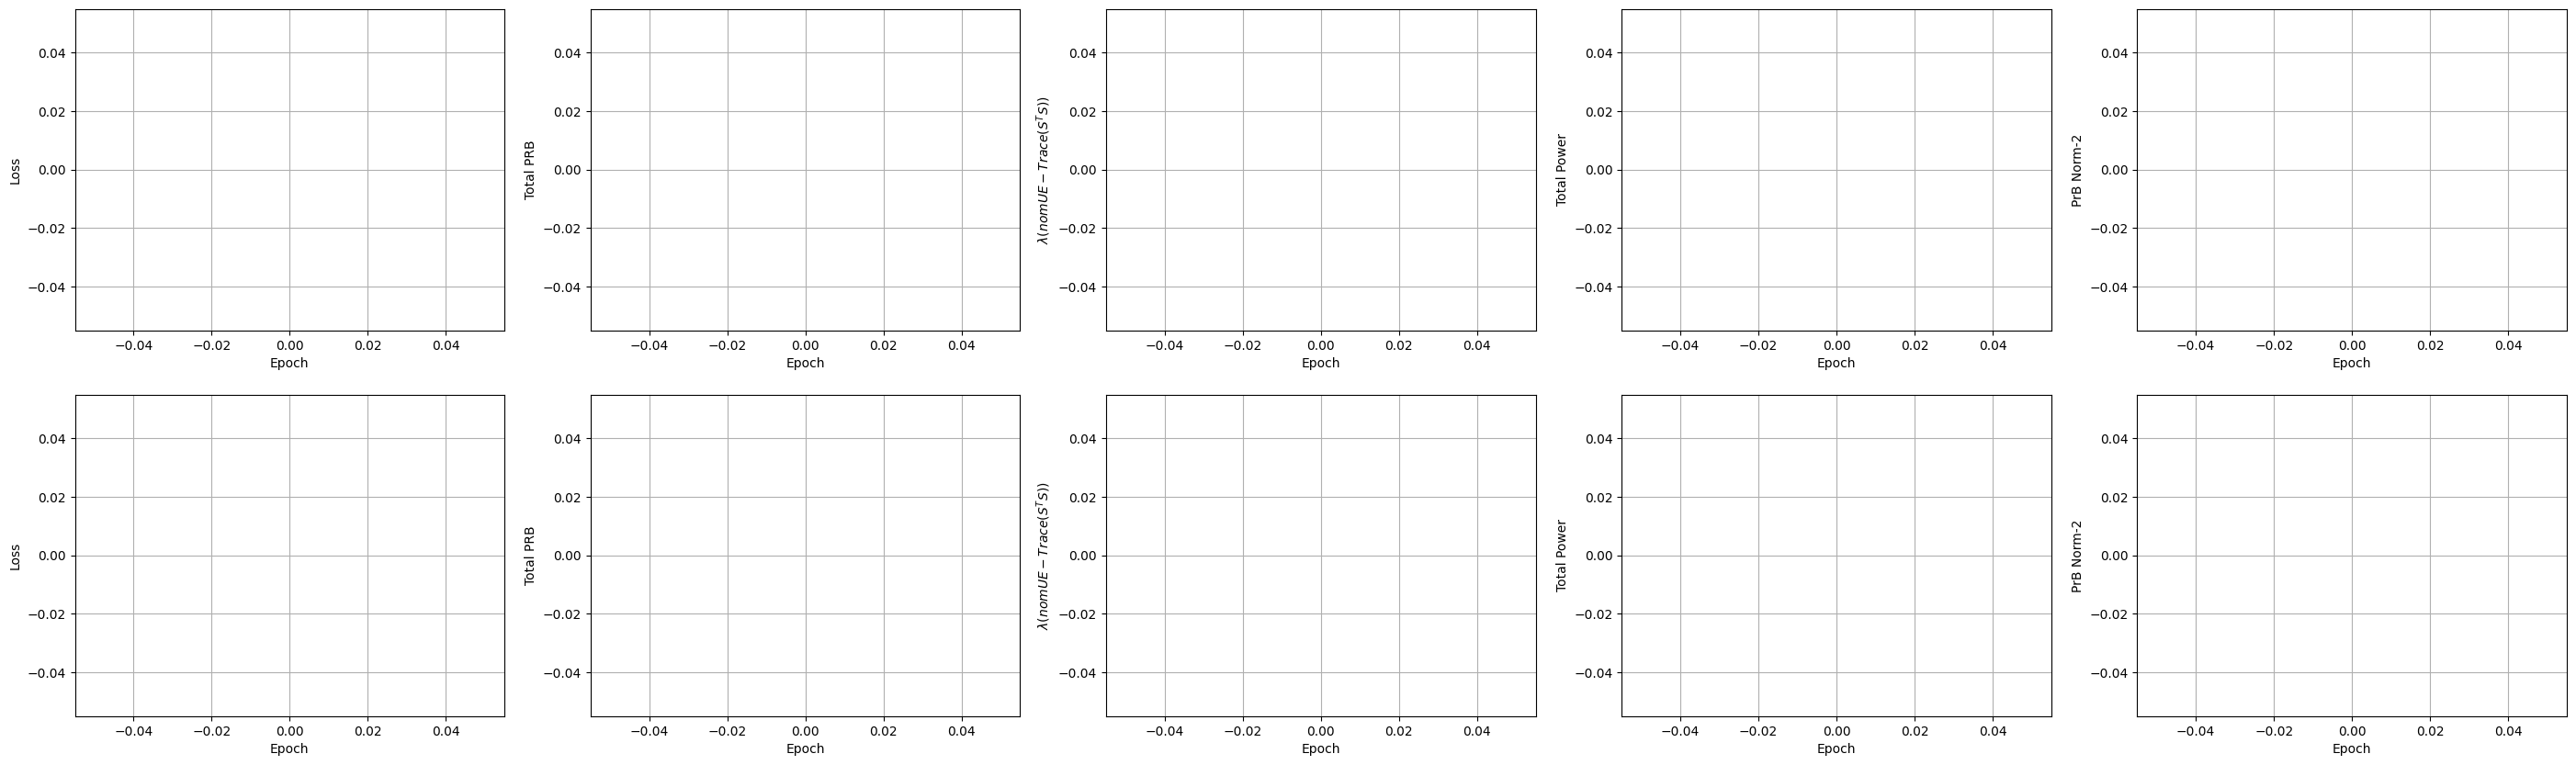

In [70]:
fig = plt.figure(figsize=(35, 10))
ax1 = fig.add_subplot(2, 5, 1)
ax2 = fig.add_subplot(2, 5, 2)
ax3 = fig.add_subplot(2, 5, 3)
ax4 = fig.add_subplot(2, 5, 4)
ax5 = fig.add_subplot(2, 5, 5)
ax6 = fig.add_subplot(2, 5, 6)
ax7 = fig.add_subplot(2, 5, 7)
ax8 = fig.add_subplot(2, 5, 8)
ax9 = fig.add_subplot(2, 5, 9)
ax10 = fig.add_subplot(2, 5, 10)

epoch_th=5000
ax1.plot(train_loss_list[0:epoch_th], label='data 1')
ax6.plot(test_loss_list[1:epoch_th], label='data 2')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Loss')


ax2.plot(train_Avg_PrB_list[0:epoch_th], label='data 1')
ax7.plot(test_Avg_PrB_list[0:epoch_th], label='data 2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Total PRB')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Total PRB')


ax3.plot(train_Reg1_list[0:epoch_th], label='data 1')
ax8.plot(test_Reg1_list[0:epoch_th], label='data 2')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('$\lambda (nom UE - Trace(S^T S))$')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('$\lambda (nom UE - Trace(S^T S))$')

ax4.plot(train_Reg2_list[0:epoch_th], label='data 1')
ax9.plot(test_Reg2_list[0:epoch_th], label='data 2')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Total Power')
ax9.set_xlabel('Epoch')
ax9.set_ylabel('Total Power')

ax5.plot(train_Reg3_list[0:epoch_th], label='data 1')
ax10.plot(test_Reg3_list[0:epoch_th], label='data 2')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('PrB Norm-2')
ax10.set_xlabel('Epoch')
ax10.set_ylabel('PrB Norm-2')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()
ax10.grid()
# plt.savefig('figs/Trainig_Test_vs_Epoch_TraceConst_HomoGraph_infPrB_1KEpoch_v1.png')
# plt.savefig('figs/rainig_Test_vs_Epoch_TraceConst_HomoGraph_infPrB_1KEpoch_v1.pdf')

plt.show()

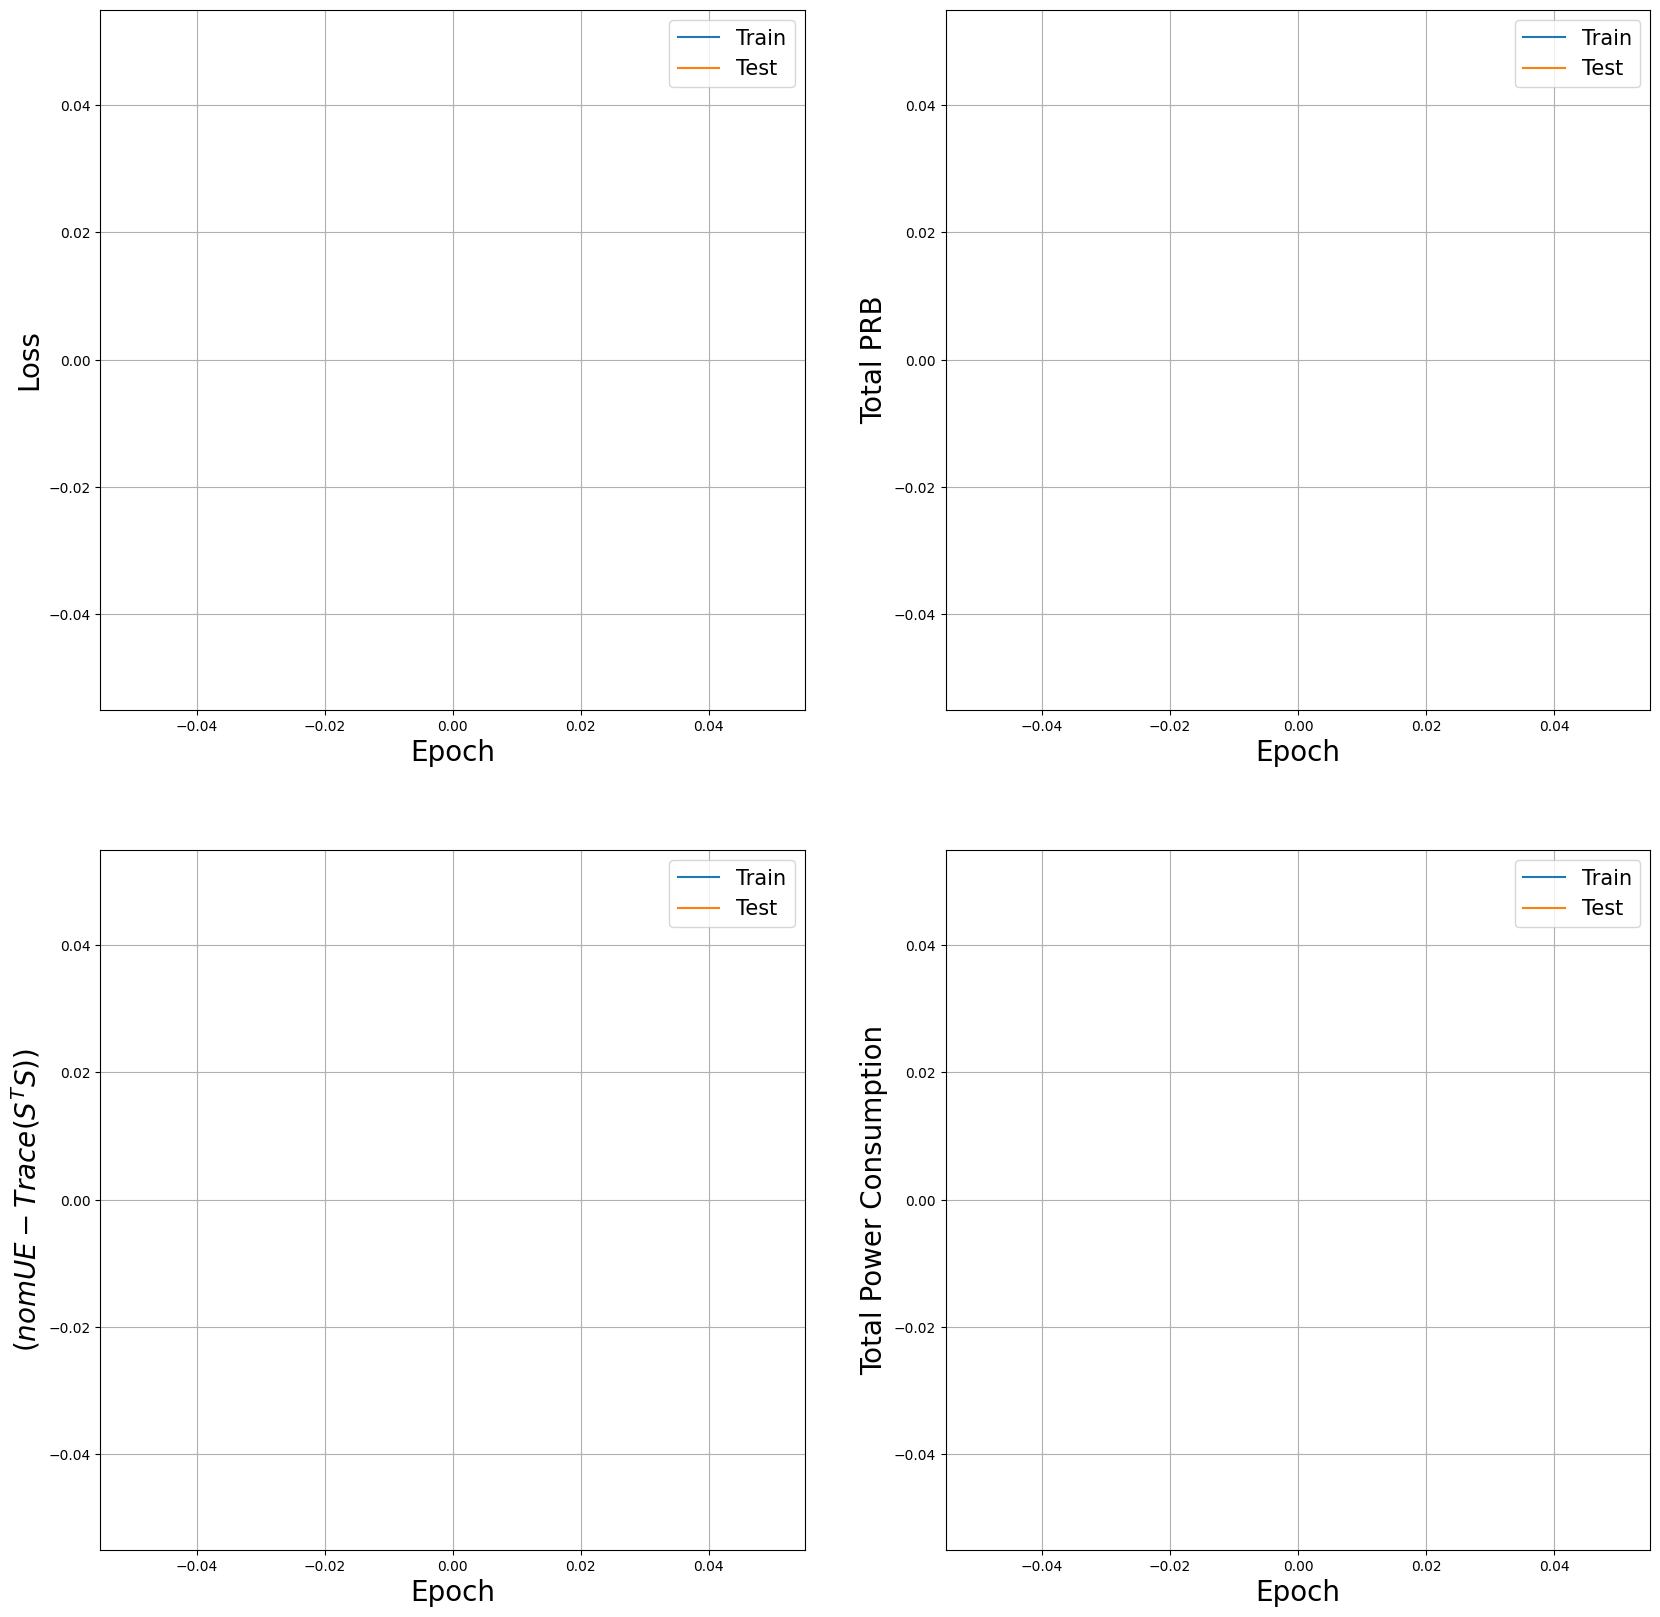

In [71]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.plot(train_loss_list, label='Train')
ax1.plot(test_loss_list, label='Test')
ax1.set_xlabel('Epoch',fontsize=20)
ax1.set_ylabel('Loss', fontsize=20)
ax1.legend(fontsize=15)
# ax5.set_ylabel('Loss')


ax2.plot(train_Avg_PrB_list, label='Train')
ax2.plot(test_Avg_PrB_list, label='Test')
ax2.set_xlabel('Epoch',fontsize=20)
ax2.set_ylabel('Total PRB',fontsize=20)
ax2.legend(fontsize=15)
# ax6.set_xlabel('Epoch')
# ax6.set_ylabel('Total PRB')


ax3.plot(train_Reg1_list, label='Train')
ax3.plot(test_Reg1_list, label='Test')
ax3.set_xlabel('Epoch',fontsize=20)
ax3.set_ylabel('$(nom UE - Trace(S^T S))$',fontsize=20)
ax3.legend(fontsize=15)
# ax7.set_xlabel('Epoch')
# ax7.set_ylabel('$\lambda Trace(S^T S)$')

ax4.plot(train_Reg2_list, label='Train')
ax4.plot(test_Reg2_list, label='Test')
ax4.set_xlabel('Epoch',fontsize=20)
ax4.set_ylabel('Total Power Consumption',fontsize=20)
ax4.legend(fontsize=15)
# ax8.set_xlabel('Epoch')
# ax8.set_ylabel('Per BS PrB Constraint')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
# ax5.grid()
# ax6.grid()
# ax7.grid()
# ax8.grid()
# plt.savefig('figs/Trainig_Test_vs_Epoch_TraceConst_HomoGraph_infPrB_1KEpoch_v2.png')
# plt.savefig('figs/Trainig_Test_vs_Epoch_TraceConst_HomoGraph_infPrB_1KEpoch_v2.pdf')

plt.show()

In [72]:
def PWR_consmption(PrB_avg,Max_PRB, coefs, intercepts):
    
    frames= torch.div(PrB_avg,Max_PRB)
    partial_percentage = torch.fmod(frames,1)*100
    full_OFDM_frame_nom = frames-torch.fmod(frames,1)

    poly_features_test = torch.tensor([[x.item() , x.item()**2] for x in partial_percentage], dtype= torch.float32, device= device)
    partial_frame_power = torch.matmul(coefs[0],torch.t(poly_features_test))+intercepts*torch.where(partial_percentage > 0, 1, 0)
    full_frame_power = Max_power_per_OFDM_frame *full_OFDM_frame_nom 
    Net_Consumption_power = full_frame_power+ partial_frame_power
    
    return Net_Consumption_power

56


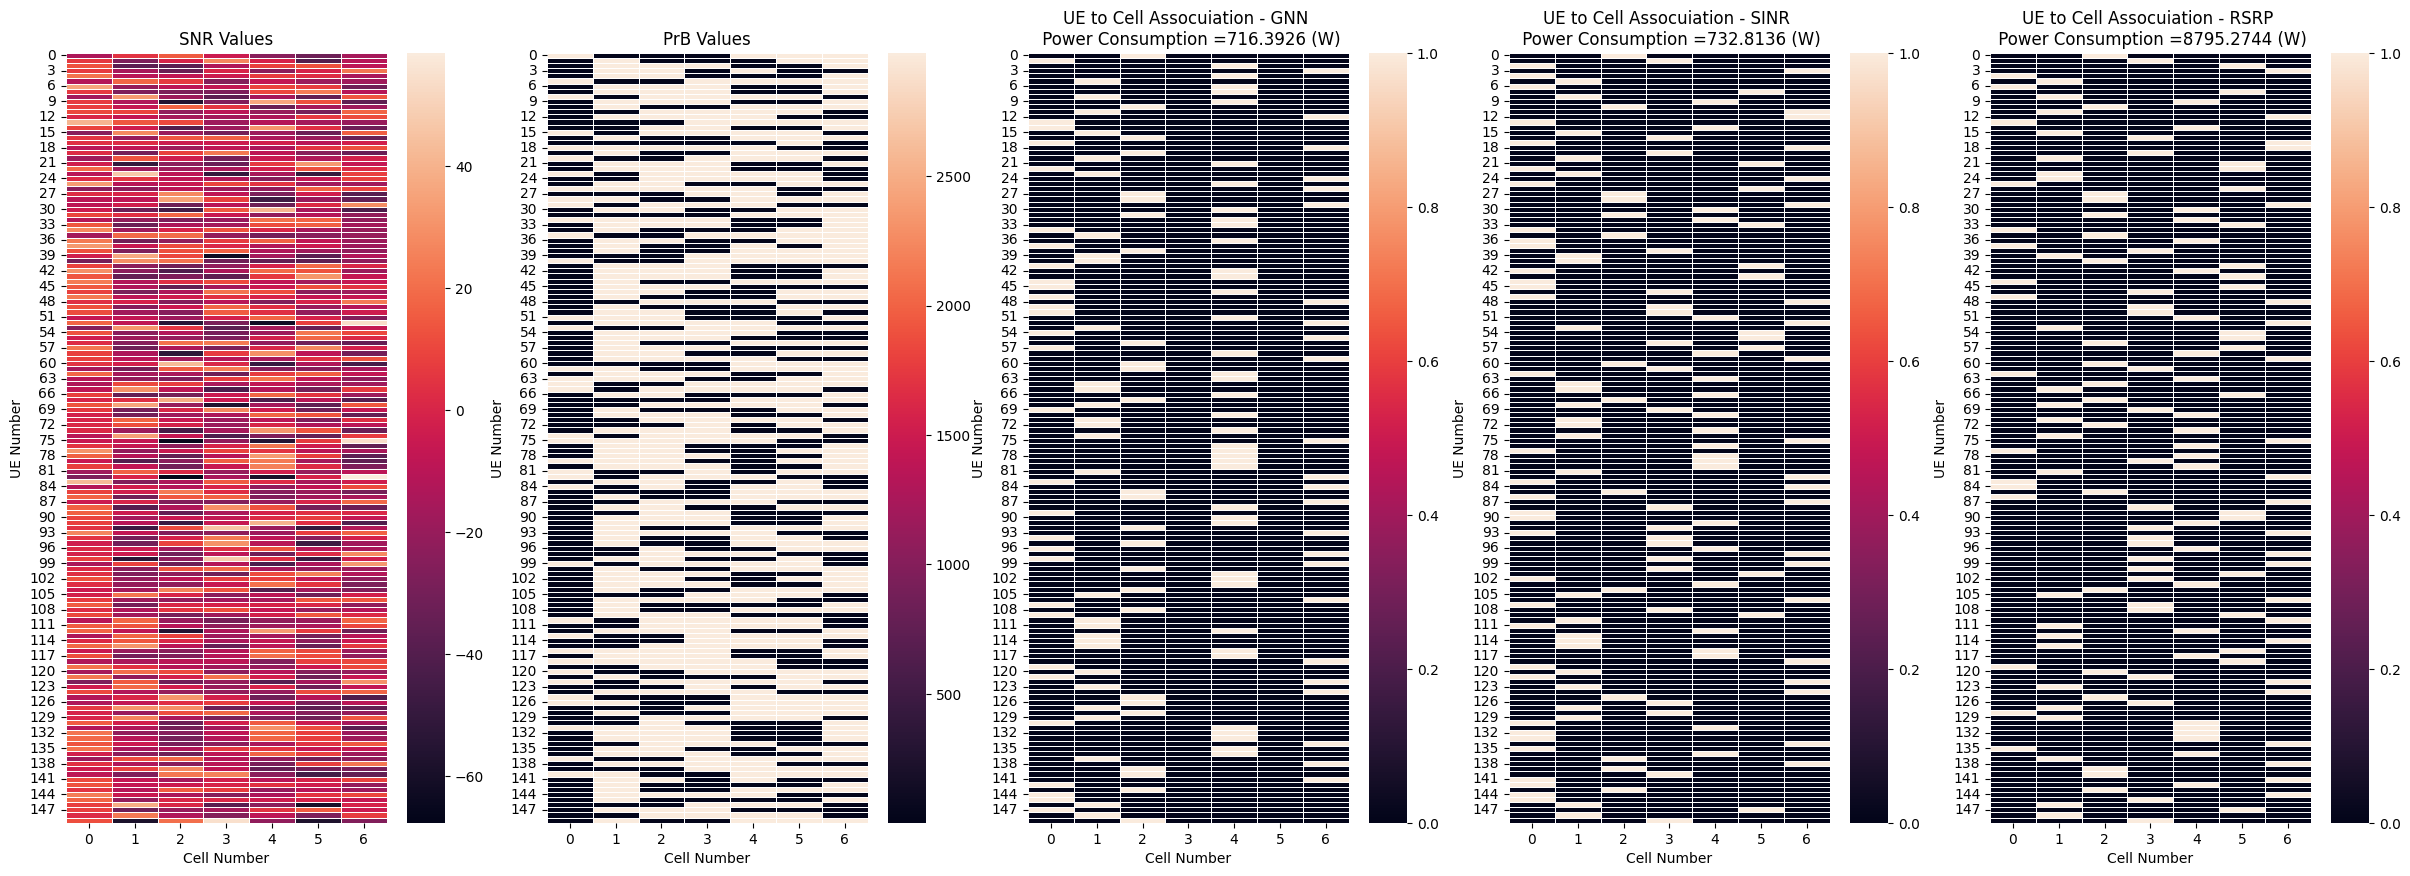

GNN:  PrB Distribution: tensor([45., 33., 33.,  0., 59.,  0., 32.]), ====>> Total PrB: 202.0, ====>> Total PWR: 716.3926
SINR: PrB Distribution: tensor([38., 27., 14., 22., 22., 12., 25.]), ====>> Total PrB: 160.0, ====>> Total PWR: 732.8136
RSRP: PrB Distribution: tensor([2996.,   28.,   28.,   32.,   27.,   28.,   45.]), ====>> Total PrB: 3184.0, ====>> Total PWR: 8795.2744


In [73]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
UE_nom=150
device= 'cpu'

sample_nom =np.random.randint(200)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()
coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
max_PrB_percentage= 100
poly_features_max = torch.tensor([[x , x**2] for x in [max_PrB_percentage]], dtype= torch.float32, device= device)
Max_power_per_OFDM_frame = torch.matmul(coefs[0],torch.t(poly_features_max))+intercepts
# poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
# Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

# poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
# Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

# poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
# Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)

Power_Cons_GNN = PWR_consmption(BS_PRB_GNN,Max_PRB, coefs, intercepts)
# Power_Cons_GNN = Power_Cons_GNN_vec.sum()
Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
# Power_Cons_RSRP = Power_Cons_RSRP_vec.sum()
Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
# Power_Cons_SINR = Power_Cons_SINR_vec.sum()

fig = plt.figure(figsize=(30, 10))

ax2 = fig.add_subplot(1, 5, 1)
sns.heatmap(data_test['SINR_mtx'].detach().numpy().transpose() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('SNR Values')


ax1 = fig.add_subplot(1, 5, 2)
sns.heatmap(data_test['UE_PRB_All_cells'].detach().numpy() , linewidth=0.5)
ax1.set_xlabel('Cell Number')
ax1.set_ylabel('UE Number')
ax1.set_title('PrB Values')

ax2 = fig.add_subplot(1, 5, 3)
sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - GNN \n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 5, 4)
sns.heatmap(data_test['UE_Ass_sinr_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))


ax2 = fig.add_subplot(1, 5, 5)
sns.heatmap(data_test['UE_Ass_rsrp_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))


plt.show()


print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')

# # x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
# Homodata = Data(x=data_test.x, edge_index=data_test.edge_index)
    
# ## find color map
# edge_index = (T_GNN > 0).nonzero().t()
# row, col = edge_index
# # edge_index
# colors=['red', 'blue', 'green', 'magenta', 'yellow', 'cyan', 'gray']
# color_map_GNN=[]
# color_map_RSRP=[]
# color_map_SINR=[]
# for t in range(UE_nom):
#     color_map_GNN.append(colors[[idx for idx in range(BS_nom) if T_GNN[t,idx]==1][0]])
#     color_map_RSRP.append(colors[[idx for idx in range(BS_nom) if T_RSRP[t,idx]==1][0]])
#     color_map_SINR.append(colors[[idx for idx in range(BS_nom) if T_SINR[t,idx]==1][0]])

    
    
    
# g_GNN = torch_geometric.utils.to_networkx(Homodata, remove_self_loops=True)

# # random_pos = nx.random_layout(graph, seed=42)
# # pos = nx.spring_layout(graph, pos=random_pos)
# pos = nx.spring_layout(g_GNN)


# # larger figure size
# fig = plt.figure(figsize=(30,10))
# ax1 = fig.add_subplot(1, 3, 1)

# # nx.draw_networkx(G,
# #                 pos=nx.spring_layout(G, seed=0),
# #                 with_labels=True,
# #                 node_size=800,
# #                 node_color=data.y,
# #                 cmap="hsv",
# #                 vmin=-2,
# #                 vmax=3,
# #                 width=0.8,
# #                 edge_color="grey",
# #                 font_size=14
# #                 )


# nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_GNN, pos=pos, ax=ax1)
# ax1.set_title('UE Assocuiation - GNN\n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

# ax2 = fig.add_subplot(1, 3, 2)
# nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_SINR, pos=pos, ax=ax2)
# ax2.set_title('UE Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))

# ax3 = fig.add_subplot(1, 3, 3)
# nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_RSRP, pos=pos, ax=ax3)
# ax3.set_title('UE Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))

# # plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.png')
# # plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.pdf')


# plt.show()

# print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
# print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
# print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [74]:
Max_PRB

55

## PWR vs BW

In [75]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
UE_nom=150
device= 'cpu'

sample_nom =np.random.randint(200)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
# data_test_ls = [i for j, i in enumerate(test_loader) if j not in [65,75]]
# data_test_ls = [i for j, i in enumerate(test_loader)]

test_ls = [i for j, i in enumerate(test_loader)]
train_ls = [i for j, i in enumerate(train_loader)]

data_test_ls = test_ls + train_ls


Avg_PWR_GNN=[]
Avg_PWR_RSRP=[]
Avg_PWR_SINR=[]
BW_ls=[20]## MHz
PRB_bw=360# Khz
Max_PRB_ls=[1000*i/PRB_bw for i in BW_ls]
for Max_PRB in Max_PRB_ls:
    GNN_PWR_sample_ls=[]
    RSRP_PWR_sample_ls=[]
    SINR_PWR_sample_ls=[]
    
    PRB_norm1_GNN=[]
    PRB_norm1_SINR=[]
    PRB_norm1_RSRP=[]

    PRB_norm2_GNN=[]
    PRB_norm2_SINR=[]
    PRB_norm2_RSRP=[]

    Cell_off_GNN=[]
    Cell_off_RSRP=[]
    Cell_off_SINR=[]


    for data_test in data_test_ls:
        data_test= data_test.to('cpu')
        out_test = GNN_homo_model(data_test)  # Perform a single forward pass.

        T_GNN= torch.zeros((UE_nom,BS_nom))
        L_GNN= torch.argmax(out_test, dim=1)
        for l in range(len(L_GNN)):
            T_GNN[l,L_GNN[l].item()] = 1
        T_RSRP = data_test['UE_Ass_rsrp_mtx']
        T_SINR = data_test['UE_Ass_sinr_mtx']

        ## RRBs
        BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
        BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
        BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
        
        PRB_norm1_GNN.append(torch.norm(BS_PRB_GNN, p=1).item())
        PRB_norm1_SINR.append(torch.norm(BS_PRB_SINR, p=1).item())
        PRB_norm1_RSRP.append(torch.norm(BS_PRB_RSRP, p=1).item())
        
        PRB_norm2_GNN.append(torch.norm(BS_PRB_GNN, p=2).item())
        PRB_norm2_SINR.append(torch.norm(BS_PRB_SINR, p=2).item())
        PRB_norm2_RSRP.append(torch.norm(BS_PRB_RSRP, p=2).item())
        
        Cell_off_GNN.append(7-torch.count_nonzero(BS_PRB_GNN).item())
        Cell_off_RSRP.append(7-torch.count_nonzero(BS_PRB_RSRP).item())
        Cell_off_SINR.append(7-torch.count_nonzero(BS_PRB_SINR).item())
        

        Power_Cons_GNN =  PWR_consmption(BS_PRB_GNN, Max_PRB, coefs, intercepts)
        Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
        Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
        GNN_PWR_sample_ls.append(Power_Cons_GNN.sum())
        RSRP_PWR_sample_ls.append(Power_Cons_RSRP.sum())
        SINR_PWR_sample_ls.append(Power_Cons_SINR.sum())

    Avg_PWR_GNN.append(np.mean(GNN_PWR_sample_ls))
    Avg_PWR_RSRP.append(np.mean(RSRP_PWR_sample_ls))
    Avg_PWR_SINR.append( np.mean(SINR_PWR_sample_ls))



8


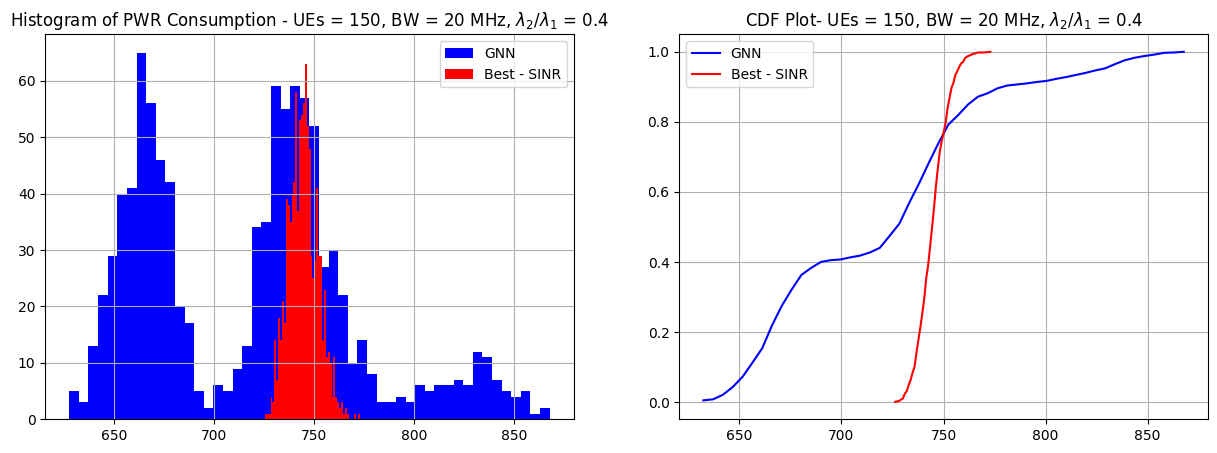

PWR GNN  %: 717.940521
PWR SINR %: 744.625217
PWR RSRP %: 6875.590440
GNN to SINR %: 3.583641
GNN to RSRP %: 89.558126
GNN: PRB Norm  1: 221.5090, ====>> PRB Norm 2: 221.5090, ====>> Cells off Rate: 2.0000
SINR: PRB Norm 1: 168.1440, ====>> PRB Norm 2: 65.4056, ====>> Cells off Rate: 0.0000
RSRP: PRB Norm 1: 2485.9910, ====>> PRB Norm 2: 2485.9910, ====>> Cells off Rate: 0.0000


In [76]:
GNN_PWR_sample_ls_np = [i.item() for i in GNN_PWR_sample_ls]
SINR_PWR_sample_ls_np = [i.item() for i in SINR_PWR_sample_ls]
RSRP_PWR_sample_ls_np = [i.item() for i in RSRP_PWR_sample_ls]

for i in range(3):
    m= GNN_PWR_sample_ls_np.index(np.max(GNN_PWR_sample_ls_np))
    GNN_PWR_sample_ls_np.pop(m)
# m= GNN_PWR_sample_ls_np.index(np.max(GNN_PWR_sample_ls_np))
# GNN_PWR_sample_ls_np.pop(m)

Avg_PWR_GNN = np.mean(GNN_PWR_sample_ls_np)
Avg_PWR_SINR = np.mean(SINR_PWR_sample_ls_np)
Avg_PWR_RSRP = np.mean(RSRP_PWR_sample_ls_np)
GNN_to_SINR = 100*(Avg_PWR_SINR - Avg_PWR_GNN)/Avg_PWR_SINR
GNN_to_RSRP = 100*(Avg_PWR_RSRP - Avg_PWR_GNN)/Avg_PWR_RSRP


fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

hist, bin_edges = np.histogram(GNN_PWR_sample_ls_np, density=True)
_ = ax1.hist(GNN_PWR_sample_ls_np, bins= 50, color='blue', label='GNN')  # arguments are passed to np.histogram
_ = ax1.hist(SINR_PWR_sample_ls_np, bins= 50, color='red', label='Best - SINR')  # arguments are passed to np.histogram

ax1.grid()
ax1.legend()
ax1.title.set_text('Histogram of PWR Consumption - UEs = 150, BW = 20 MHz, $\lambda_2/\lambda_1$ = 0.4')

data = np.array(GNN_PWR_sample_ls_np)
count, bins = np.histogram(data, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax2.plot(bins[1:], cdf, color='blue', label="GNN")


data = np.array(SINR_PWR_sample_ls_np)
count, bins = np.histogram(data, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax2.plot(bins[1:], cdf, color='red', label="Best - SINR")

ax2.grid()
ax2.legend()
ax2.title.set_text('CDF Plot- UEs = 150, BW = 20 MHz, $\lambda_2/\lambda_1$ = 0.4')

plt.show()

print(f'PWR GNN  %: {Avg_PWR_GNN:03f}')
print(f'PWR SINR %: {Avg_PWR_SINR:03f}')
print(f'PWR RSRP %: {Avg_PWR_RSRP:03f}')
print('==========================================================================================================================================================')
print(f'GNN to SINR %: {GNN_to_SINR:03f}')
print(f'GNN to RSRP %: {GNN_to_RSRP:03f}')
print('==========================================================================================================================================================')
print(f'GNN: PRB Norm  1: {np.mean(PRB_norm1_GNN):.4f}, ====>> PRB Norm 2: {np.mean(PRB_norm1_GNN):.4f}, ====>> Cells off Rate: {np.mean(Cell_off_GNN):.4f}')
print(f'SINR: PRB Norm 1: {np.mean(PRB_norm1_SINR):.4f}, ====>> PRB Norm 2: {np.mean(PRB_norm2_SINR):.4f}, ====>> Cells off Rate: {np.mean(Cell_off_SINR):.4f}')
print(f'RSRP: PRB Norm 1: {np.mean(PRB_norm1_RSRP):.4f}, ====>> PRB Norm 2: {np.mean(PRB_norm1_RSRP):.4f}, ====>> Cells off Rate: {np.mean(Cell_off_RSRP):.4f}')

# Plots

In [17]:
Ratio_full = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 20, 50, 100]
Ratio= [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 20, 50, 100]

bw=[20, 80]

GNN_20 =  [851.435392, 738.617852, 717.194645, 717.940521, 703.202384,     685.795659, 654.204890, 703.215320, 724.002465,  744.002465, 744.098520, 744.502465]
SINR_20 = [744.625217, 744.625217, 744.625217, 744.625217, 744.625217,     744.625217, 744.625217, 744.625217, 744.625217,  744.625217, 744.625217, 744.625217]
RSRP_20 = [6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440, 6875.590440]
GNN_SINR_20 = [100*(SINR_20[i] - GNN_20[i])/SINR_20[i] for i in range(len(GNN_20))]
GNN_RSRP_20 = [100*(RSRP_20[i] - GNN_20[i])/RSRP_20[i] for i in range(len(GNN_20))]

GNN_80 = [442.702910, 427.270323, 502.868721, 423.056245, 417.403291, 421.300667, 479.559281, 515.954610, 530.680676, 533.690009, 533.777379, 533.777379]
SINR_80 =   [533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634, 533.618634]
RSRP_80 = [ 2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735,2051.360735]
GNN_SINR_80 = [100*(SINR_80[i] - GNN_80[i])/SINR_80[i] for i in range(len(GNN_80))]
GNN_RSRP_80 = [100*(RSRP_80[i] - GNN_80[i])/RSRP_80[i] for i in range(len(GNN_80))]

cell_off_rate80=[3.302, 2.10, 1.530, 1.14, 0.89, 0.54, 0.31,0.12,0,0,0,0]
cell_off_rate20=[5.31, 4.12, 3.34, 2.81, 2.47, 1.98, 1.39, 0.79, 0.26, 0, 0, 0]

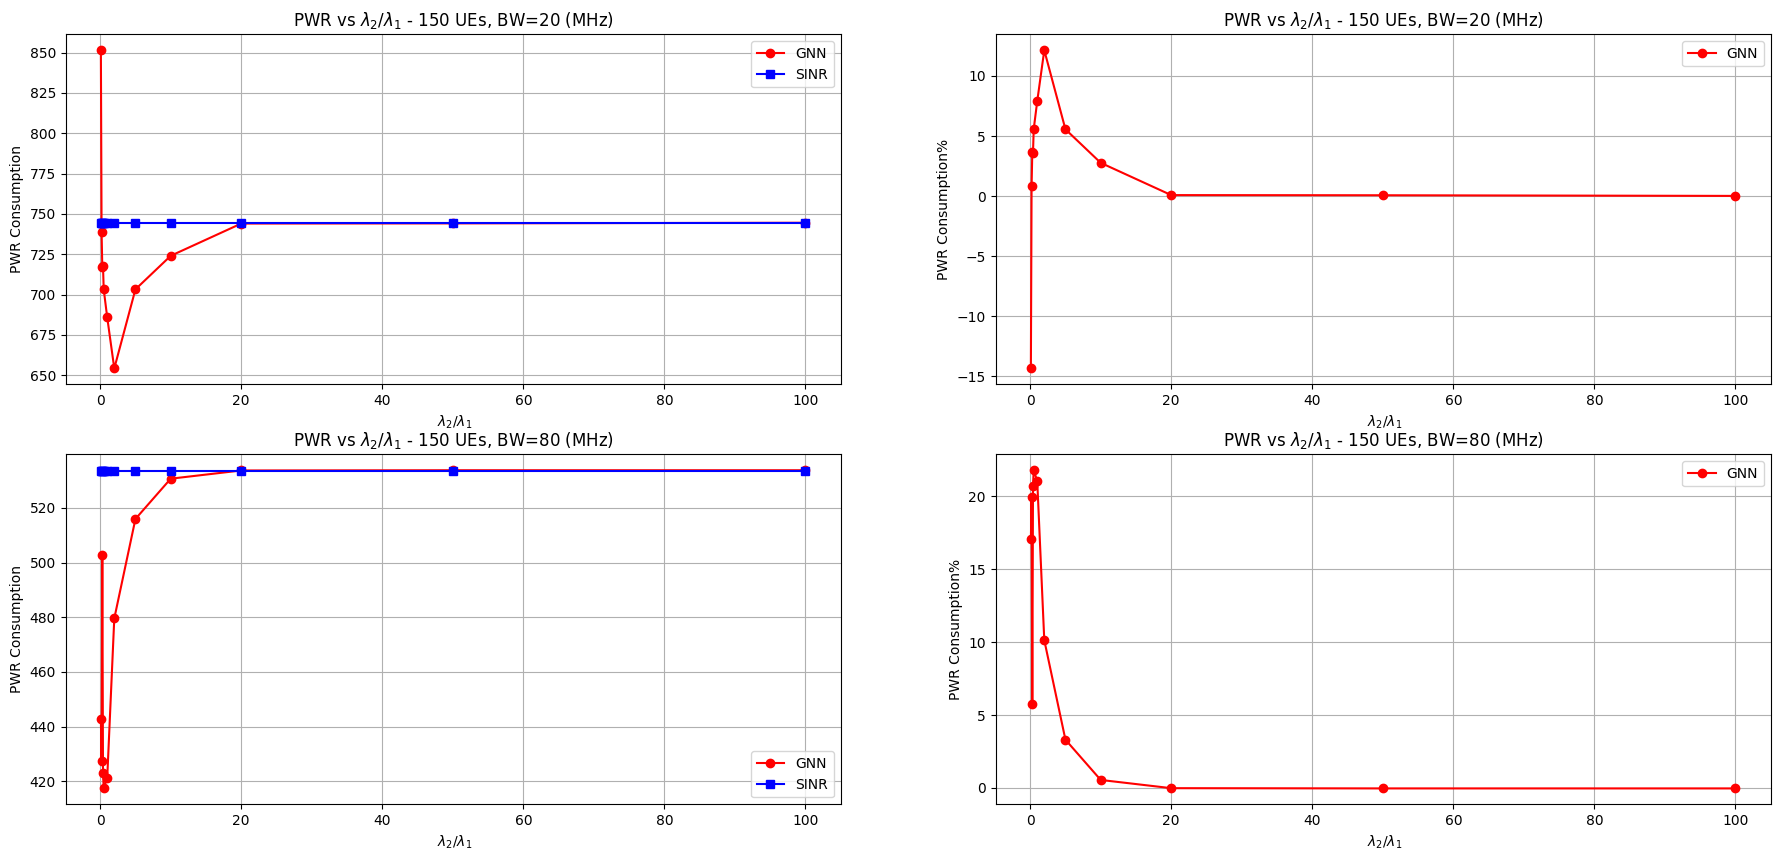

In [12]:
fig = plt.figure(figsize=(22, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2= fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4= fig.add_subplot(2, 2, 4)

ax1.plot(Ratio, GNN_20, 'r-o', label='GNN')
ax1.plot(Ratio, SINR_20, 'b-s', label='SINR')
ax1.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=20 (MHz)')
ax1.legend()
ax1.grid()

ax2.plot(Ratio, GNN_SINR_20, 'r-o', label='GNN')
ax2.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax2.set_ylabel('PWR Consumption%')
ax2.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=20 (MHz)')
ax2.legend()
ax2.grid()

ax3.plot(Ratio, GNN_80, 'r-o', label='GNN')
ax3.plot(Ratio, SINR_80, 'b-s', label='SINR')
ax3.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax3.set_ylabel('PWR Consumption')
ax3.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=80 (MHz)')
ax3.legend()
ax3.grid()

ax4.plot(Ratio, GNN_SINR_80, 'r-o', label='GNN')
ax4.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax4.set_ylabel('PWR Consumption%')
ax4.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=80 (MHz)')
ax4.legend()
ax4.grid()


## Save EPS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


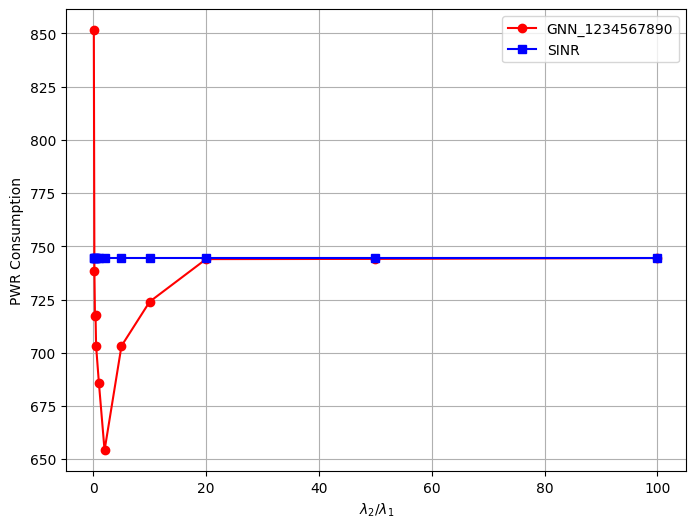

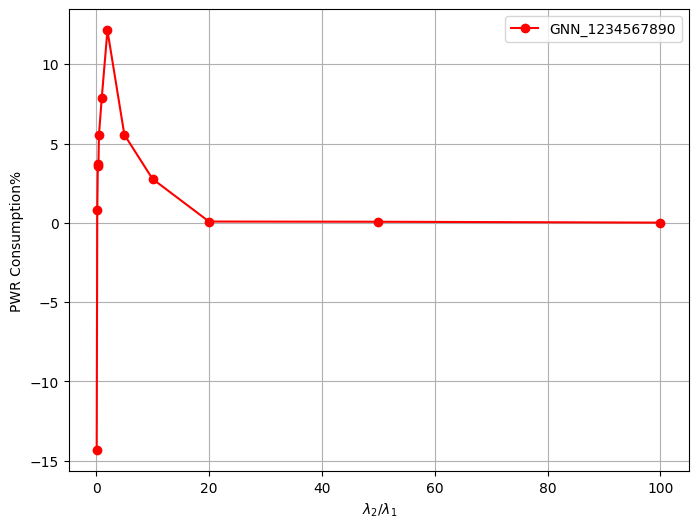

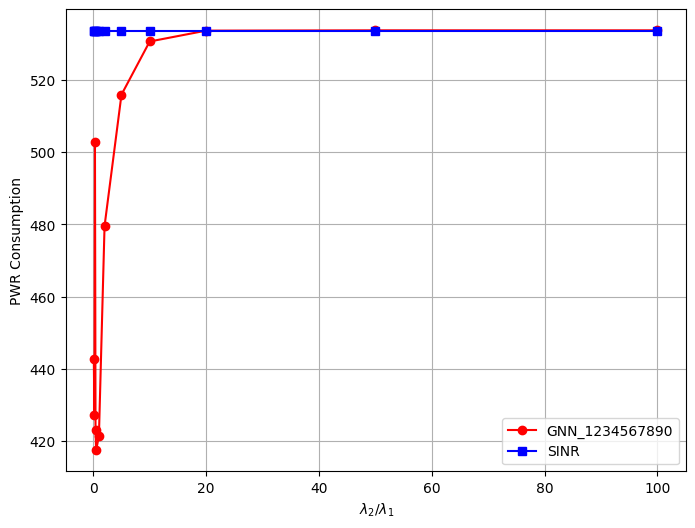

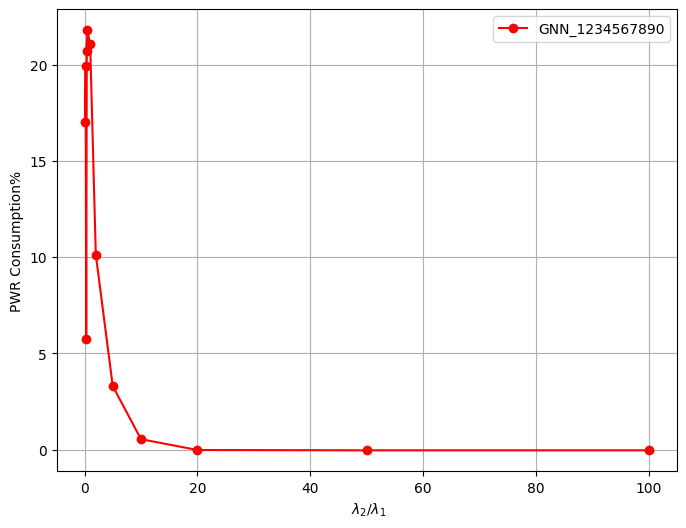

In [21]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(Ratio, GNN_20, 'r-o', label='GNN_1234567890')
ax1.plot(Ratio, SINR_20, 'b-s', label='SINR')
ax1.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax1.set_ylabel('PWR Consumption')
# ax1.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=20 (MHz)')
ax1.legend()
ax1.grid()
fig.savefig('Ratio_150_BW20.eps', format='eps', dpi=1000)
fig.savefig("Ratio_150_BW20.pdf")

fig = plt.figure(figsize=(8,6))
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(Ratio, GNN_SINR_20, 'r-o', label='GNN_1234567890')
ax2.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax2.set_ylabel('PWR Consumption%')
# ax2.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=20 (MHz)')
ax2.legend()
ax2.grid()
fig.savefig('Ratio_p_150_BW20.eps', format='eps', dpi=1000)
fig.savefig("Ratio_p_150_BW20.pdf")

fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(1, 1, 1)
ax3.plot(Ratio, GNN_80, 'r-o', label='GNN_1234567890')
ax3.plot(Ratio, SINR_80, 'b-s', label='SINR')
ax3.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax3.set_ylabel('PWR Consumption')
# ax3.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=80 (MHz)')
ax3.legend()
ax3.grid()
fig.savefig('Ratio_150_BW80.eps', format='eps', dpi=1000)
fig.savefig("Ratio_150_BW80.pdf")

fig = plt.figure(figsize=(8,6))
ax4 = fig.add_subplot(1, 1, 1)
ax4.plot(Ratio, GNN_SINR_80, 'r-o', label='GNN_1234567890')
ax4.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax4.set_ylabel('PWR Consumption%')
# ax4.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs, BW=80 (MHz)')
ax4.legend()
ax4.grid()
fig.savefig('Ratio_p_150_BW80.eps', format='eps', dpi=1000)
fig.savefig("Ratio_p_150_BW80.pdf")


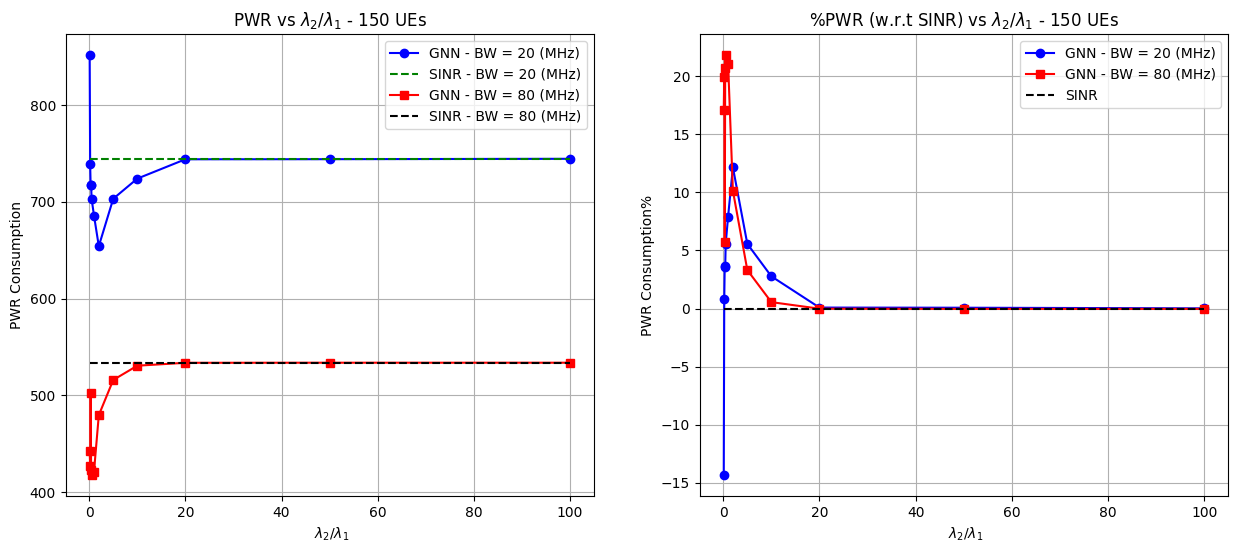

In [15]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1,2, 1)
ax2= fig.add_subplot(1,2 , 2)


ax1.plot(Ratio, GNN_20, 'b-o', label='GNN - BW = 20 (MHz)')
ax1.plot(Ratio, SINR_20, 'g--', label='SINR - BW = 20 (MHz)')
ax1.plot(Ratio, GNN_80, 'r-s', label='GNN - BW = 80 (MHz)')
ax1.plot(Ratio, SINR_80, 'k--', label='SINR - BW = 80 (MHz)')
ax1.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs')
ax1.legend()
ax1.grid()

SNR_bench=[0] * len(Ratio)
ax2.plot(Ratio, GNN_SINR_20, 'b-o', label='GNN - BW = 20 (MHz)')
ax2.plot(Ratio, GNN_SINR_80, 'r-s', label='GNN - BW = 80 (MHz)')
ax2.plot(Ratio, SNR_bench, 'k--', label='SINR')
ax2.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax2.set_ylabel('PWR Consumption%')
ax2.set_title('%PWR (w.r.t SINR) vs $\lambda_2/\lambda_1$ - 150 UEs')
ax2.legend()
ax2.grid()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


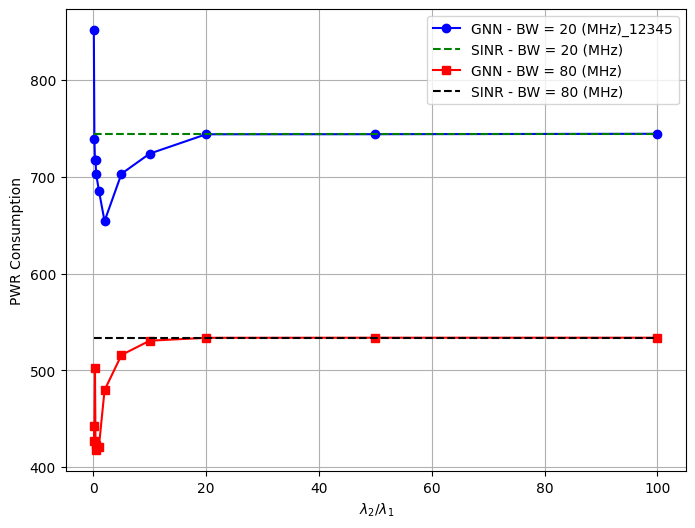

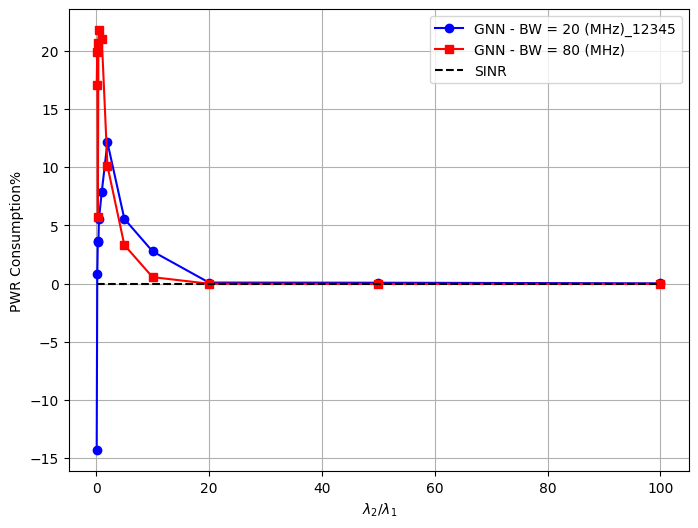

In [20]:




fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1, 1)
ax1.plot(Ratio, GNN_20, 'b-o', label='GNN - BW = 20 (MHz)_12345')
ax1.plot(Ratio, SINR_20, 'g--', label='SINR - BW = 20 (MHz)')
ax1.plot(Ratio, GNN_80, 'r-s', label='GNN - BW = 80 (MHz)')
ax1.plot(Ratio, SINR_80, 'k--', label='SINR - BW = 80 (MHz)')
ax1.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax1.set_ylabel('PWR Consumption')
# ax1.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs')
ax1.legend()
ax1.grid()
fig.savefig('Ratio_150_BW_All.eps', format='eps', dpi=1000)
fig.savefig("Ratio_150_BW_All.pdf")

fig = plt.figure(figsize=(8,6))
ax2 = fig.add_subplot(1,1, 1)
SNR_bench=[0] * len(Ratio)
ax2.plot(Ratio, GNN_SINR_20, 'b-o', label='GNN - BW = 20 (MHz)_12345')
ax2.plot(Ratio, GNN_SINR_80, 'r-s', label='GNN - BW = 80 (MHz)')
ax2.plot(Ratio, SNR_bench, 'k--', label='SINR')
ax2.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax2.set_ylabel('PWR Consumption%')
# ax2.set_title('%PWR (w.r.t SINR) vs $\lambda_2/\lambda_1$ - 150 UEs')
ax2.legend()
ax2.grid()
fig.savefig('Ratio_p_150_BW_All.eps', format='eps', dpi=1000)
fig.savefig("Ratio_p_150_BW_All.pdf")



## Cell Switch off rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


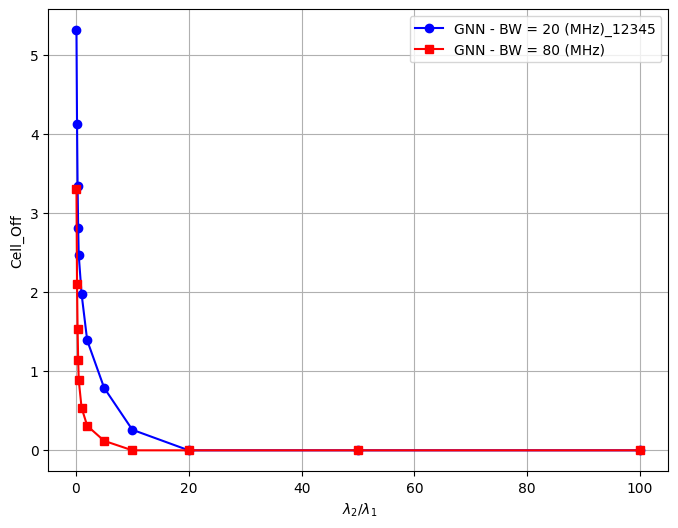

In [19]:

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1, 1)
ax1.plot(Ratio, cell_off_rate20, 'b-o', label='GNN - BW = 20 (MHz)_12345')
ax1.plot(Ratio, cell_off_rate80, 'r-s', label='GNN - BW = 80 (MHz)')
ax1.set_xlabel(' $\lambda_2/\lambda_1$ ')
ax1.set_ylabel('Cell_Off')
# ax1.set_title('PWR vs $\lambda_2/\lambda_1$ - 150 UEs')
ax1.legend()
ax1.grid()
fig.savefig('Cell_Off_Rate_UE150.eps', format='eps', dpi=1000)
fig.savefig("Cell_Off_Rate_UE150.pdf")




NameError: name 'bw_full' is not defined

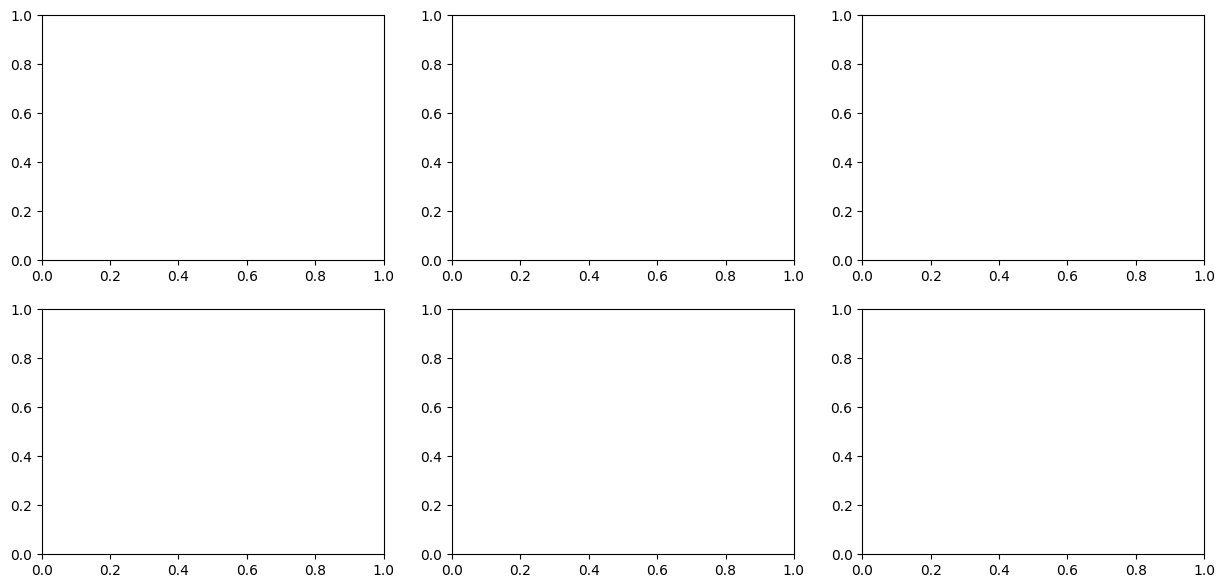

In [13]:

    
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)

ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)


ax1.plot(bw_full, GNN_50, 'r-o', label='GNN')
ax1.plot(bw_full, SINR_50, 'b-s', label='SINR')
ax1.plot(bw_full, RSRP_50, 'g-x', label='RSRP')
ax1.set_xlabel('Bandwidth (MHz)')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs Bandwidth - 50 UEs Uniform')
  

ax2.plot(bw_full, GNN_50, 'r-o', label='GNN')
ax2.plot(bw_full, SINR_50, 'b-s', label='SINR')
ax2.set_xlabel('Bandwidth (MHz)')
ax2.set_ylabel('PWR Consumption')
ax2.set_title('PWR vs Bandwidth - 50 UEs Uniform')
ax2.legend()
ax2.grid()


ax3.plot(bw_full, GNN_SINR_50, 'k-o', label='GNN-SINR')
ax3.plot(bw_full, GNN_RSRP_50, 'm-x', label='GNN-RSRP')
ax3.set_xlabel('Bandwidth (MHz)')
ax3.set_ylabel('PWR Consumption Gain %')
ax3.set_title('PWR vs Bandwidth - 50 UEs Uniform')
ax3.legend()
ax3.grid()

ax4.plot(bw_full, GNN_100, 'r-o', label='GNN')
ax4.plot(bw_full, SINR_100, 'b-s', label='SINR')
ax4.plot(bw_full, RSRP_100, 'g-x', label='RSRP')
ax4.set_xlabel('Bandwidth (MHz)')
ax4.set_ylabel('PWR Consumption')
ax4.set_title('PWR vs Bandwidth - 100 UEs Uniform')
ax4.legend()
ax4.grid()
# ax4.set_xlim([10,100])

ax5.plot(bw_full, GNN_100, 'r-o', label='GNN')
ax5.plot(bw_full, SINR_100, 'b-s', label='SINR')
ax5.set_xlabel('Bandwidth (MHz)')
ax5.set_ylabel('PWR Consumption')
ax5.set_title('PWR vs Bandwidth - 100 UEs Uniform')
ax5.legend()
ax5.grid()
# ax5.set_xlim([10,100])

ax6.plot(bw_full, GNN_SINR_100, 'k-o', label='GNN-SINR')
ax6.plot(bw_full, GNN_RSRP_100, 'm-x', label='GNN-RSRP')
ax6.set_xlabel('Bandwidth (MHz)')
ax6.set_ylabel('PWR Consumption Gain %')
ax6.set_title('PWR vs Bandwidth - 100 UEs Uniform')
ax6.legend()
ax6.grid()
# ax6.set_xlim([10,100])




plt.show()

In [219]:
GNN_PWR_sample_ls_np.index(np.max(GNN_PWR_sample_ls_np))

442

In [220]:
np.max(GNN_PWR_sample_ls_np)

1115.156494140625

Text(0.5, 1.0, 'Histogram of PWR Consumption - UEs = 100, BW = 10 MHz')

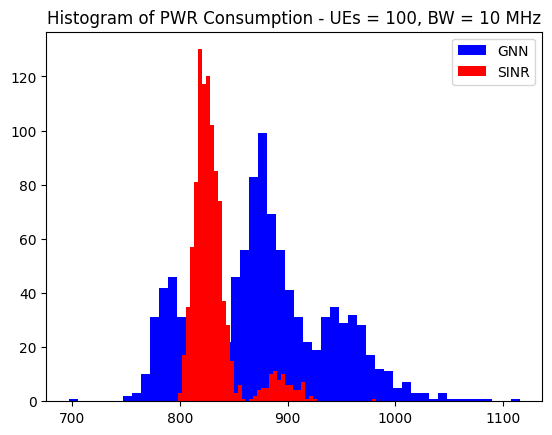

In [221]:
GNN_PWR_sample_ls_np = [i.item() for i in GNN_PWR_sample_ls]
SINR_PWR_sample_ls_np = [i.item() for i in SINR_PWR_sample_ls]

hist, bin_edges = np.histogram(GNN_PWR_sample_ls_np, density=True)
_ = plt.hist(GNN_PWR_sample_ls_np, bins= 50,  color='blue', label='GNN')  # arguments are passed to np.histogram
_ = plt.hist(SINR_PWR_sample_ls_np, bins= 50,  color='red', label='SINR')  # arguments are passed to np.histogram

plt.legend()
plt.title('Histogram of PWR Consumption - UEs = 100, BW = 10 MHz')

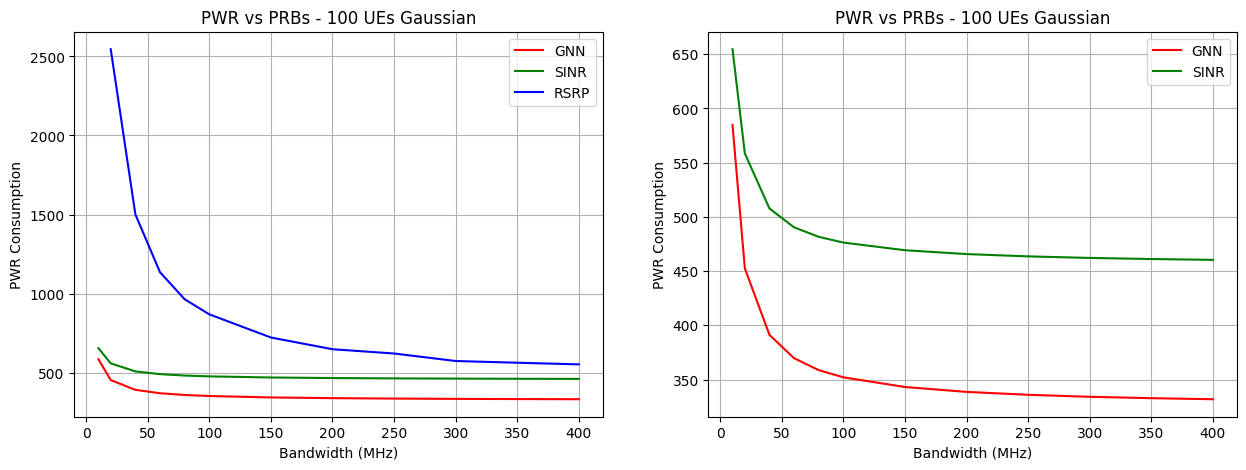

In [292]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(BW_ls, Avg_PWR_GNN, 'r', label='GNN')
ax1.plot(BW_ls, Avg_PWR_SINR, 'g', label='SINR')
ax1.plot(BW_ls[1:], Avg_PWR_RSRP[1:], 'b', label='RSRP')
ax1.set_xlabel('Bandwidth (MHz)')
ax1.set_ylabel('PWR Consumption')
ax1.set_title('PWR vs PRBs - 100 UEs Gaussian')
ax1.legend()
ax1.grid()


ax2.plot(BW_ls, Avg_PWR_GNN, 'r', label='GNN')
ax2.plot(BW_ls, Avg_PWR_SINR, 'g', label='SINR')
# ax2.plot(BW_ls[5:12], Avg_PWR_RSRP[5:12], 'b', label='RSRP')
ax2.set_xlabel('Bandwidth (MHz)')
ax2.set_ylabel('PWR Consumption')
ax2.set_title('PWR vs PRBs - 100 UEs Gaussian')
ax2.legend()
ax2.grid()



plt.show()

## CDF plot

In [198]:
len(train_ls+test_ls)

1000

In [205]:
## UE=100, BW=100 MHz
import torch_geometric
# import networkx as nx
from torch_geometric.data import Data
import seaborn as sns
BS_nom = 7
UE_nom=100
device= 'cpu'

# sample_nom =np.random.randint(200)
# print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)
# data_test_ls = [i for j, i in enumerate(test_loader)]

test_ls = [i for j, i in enumerate(test_loader)]
train_ls = [i for j, i in enumerate(train_loader)]
data_test_ls= train_ls+test_ls


BW = 100## MHz
PRB_bw=180# Khz
Max_PRB=1000*BW/PRB_bw

GNN_PWR_sample_ls=[]
RSRP_PWR_sample_ls=[]
SINR_PWR_sample_ls=[]
for data in data_test_ls:
    data_test= data.to('cpu')
    out_test = GNN_homo_model(data_test)  # Perform a single forward pass.

    T_GNN= torch.zeros((UE_nom,BS_nom))
    L_GNN= torch.argmax(out_test, dim=1)
    for l in range(len(L_GNN)):
        T_GNN[l,L_GNN[l].item()] = 1
    T_RSRP = data_test['UE_Ass_rsrp_mtx']
    T_SINR = data_test['UE_Ass_sinr_mtx']

    ## RRBs
    BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
    BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
    BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)



    Power_Cons_GNN =  PWR_consmption(BS_PRB_GNN, Max_PRB, coefs, intercepts)
    Power_Cons_RSRP = PWR_consmption(BS_PRB_RSRP,Max_PRB, coefs, intercepts)
    Power_Cons_SINR = PWR_consmption(BS_PRB_SINR,Max_PRB, coefs, intercepts)
    GNN_PWR_sample_ls.append(Power_Cons_GNN.sum())
    RSRP_PWR_sample_ls.append(Power_Cons_RSRP.sum())
    SINR_PWR_sample_ls.append(Power_Cons_SINR.sum())



In [168]:
GNN_PWR_sample_ls

[tensor(790.3485),
 tensor(999.6406),
 tensor(886.9145),
 tensor(790.4821),
 tensor(794.4847),
 tensor(966.7834),
 tensor(785.9283),
 tensor(934.3034),
 tensor(872.1233),
 tensor(942.6870),
 tensor(932.1027),
 tensor(900.8443),
 tensor(789.4318),
 tensor(887.9000),
 tensor(995.7843),
 tensor(958.2966),
 tensor(943.1664),
 tensor(861.0242),
 tensor(848.0800),
 tensor(887.3312),
 tensor(956.2893),
 tensor(921.3445),
 tensor(973.9349),
 tensor(893.5601),
 tensor(788.6292),
 tensor(795.3926),
 tensor(778.5321),
 tensor(841.5532),
 tensor(850.0833),
 tensor(979.3729),
 tensor(937.2469),
 tensor(781.0541),
 tensor(929.7509),
 tensor(791.1807),
 tensor(938.4986),
 tensor(900.2675),
 tensor(865.6241),
 tensor(894.0189),
 tensor(876.5740),
 tensor(870.0974),
 tensor(835.4265),
 tensor(1007.9169),
 tensor(868.7867),
 tensor(809.2819),
 tensor(842.5800),
 tensor(776.7185),
 tensor(871.1487),
 tensor(965.5455),
 tensor(792.6436),
 tensor(787.4550),
 tensor(777.9152),
 tensor(966.9053),
 tensor(954

Text(0.5, 0, 'Bins')

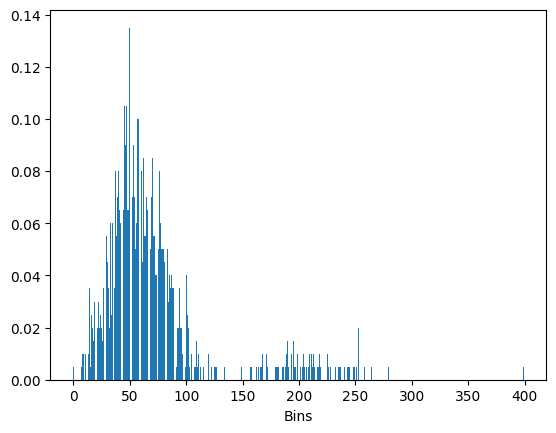

In [169]:
import torch
import matplotlib.pyplot as plt

t = torch.tensor(SINR_PWR_sample_ls)
hist = torch.histc(t, bins = 400)

bins = 400
x = range(bins)
plt.bar(x, hist/200, align='center')
plt.xlabel('Bins')

In [170]:
data_a = torch.histc(torch.tensor(SINR_PWR_sample_ls), bins = 100)
cdf=np.zeros(len(data_a))
for i in list(range(len(data_a))):
    cdf[i]=data_a[0:i+1].sum()


In [171]:
a= torch.nn.functional.normalize(torch.tensor(data_ls), p=2.0, dim = 0)
hist_a = torch.histc(a, bins = b)

# Create some test data
data_a = hist_a.detach().cpu().numpy()
data_a.sort()

# Compute the CDF
cdf=np.zeros(len(data_a))
for i in list(range(len(data_a))):
    cdf[i]=data_a[0:i+1].sum()

NameError: name 'data_ls' is not defined

In [189]:
a= torch.nn.functional.normalize(torch.tensor(GNN_PWR_sample_ls), p=2.0, dim = 0)
torch.histogram(GNN_PWR_sample_ls, 50, *, range=None, weight=None, density=False, out=None)

SyntaxError: iterable argument unpacking follows keyword argument unpacking (3371401343.py, line 2)

Text(0.5, 1.0, 'Histogram of PWR Consumption')

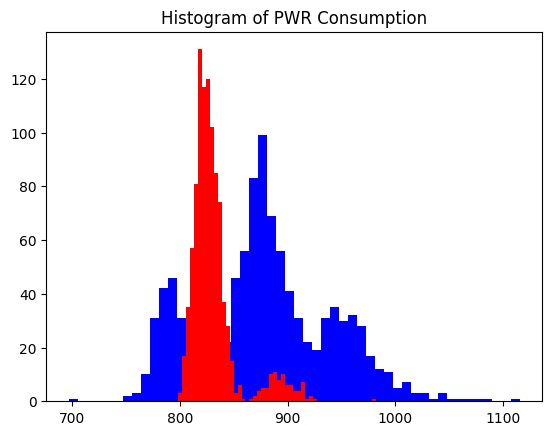

In [200]:
GNN_PWR_sample_ls_np = [i.item() for i in GNN_PWR_sample_ls]
SINR_PWR_sample_ls_np = [i.item() for i in SINR_PWR_sample_ls]

hist, bin_edges = np.histogram(GNN_PWR_sample_ls_np, density=True)
_ = plt.hist(GNN_PWR_sample_ls_np, bins= 50,  color='blue', label='GNN')  # arguments are passed to np.histogram
_ = plt.hist(SINR_PWR_sample_ls_np, bins= 50,  color='red', label='SINR')  # arguments are passed to np.histogram

plt.ylabel('')
plt.title('Histogram of PWR Consumption')

In [204]:
GNN_PWR_sample_ls_np.index(np.max(GNN_PWR_sample_ls_np))


682

ValueError: x and y must have same first dimension, but have shapes torch.Size([1000]) and (50,)

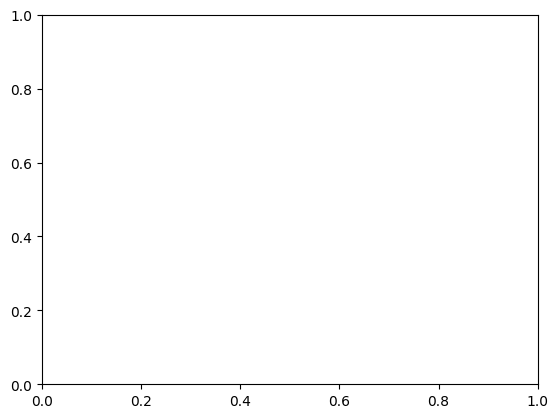

In [173]:
def cdf_data(data_ls, b):
    a= torch.nn.functional.normalize(torch.tensor(data_ls), p=2.0, dim = 0)
    hist_a = torch.histc(a, bins = b)

    # Create some test data
    data_a = hist_a.detach().cpu().numpy()
    data_a.sort()

    # Compute the CDF
    cdf=np.zeros(len(data_a))
    for i in list(range(len(data_a))):
        cdf[i]=data_a[0:i+1].sum()
        
    return a.sort(), cdf
bins=50
a, CY_a = cdf_data(GNN_PWR_sample_ls, bins)
b, CY_b = cdf_data(SINR_PWR_sample_ls, bins)
c, CY_c= cdf_data(RSRP_PWR_sample_ls, bins)
# Plot 
plt.plot(a[0], CY_a/bins, 'r')
# plt.plot(b[0], CY_b/bins, 'b')
# plt.plot(c[0], CY_c/bins, 'g')

plt.show()




In [263]:
b.sort()

torch.return_types.sort(
values=tensor([0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705, 0.0705,
        0.0705, 0.0705, 0.0705, 0.0705, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707,
        

In [227]:
100*CY/200

array([ 61. ,  97. ,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,  99.5,
        99.5,  99.5,

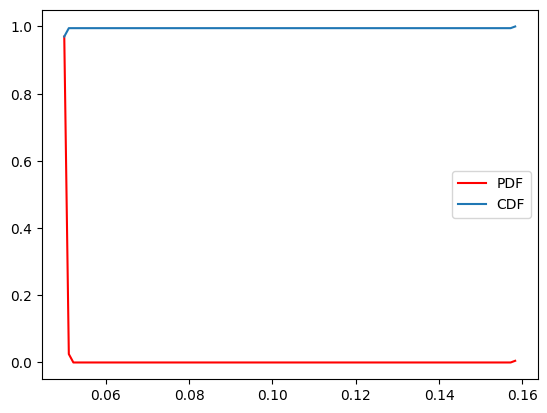

In [179]:
torch.histogram(torch.tensor([1., 2, 1]), bins=4, range=(0., 3.), weight=torch.tensor([1., 2., 4.]))

In [180]:
bins_count

array([0.04897135, 0.05006408, 0.0511568 , 0.05224952, 0.05334225,
       0.05443498, 0.0555277 , 0.05662043, 0.05771315, 0.05880588,
       0.0598986 , 0.06099132, 0.06208405, 0.06317677, 0.0642695 ,
       0.06536222, 0.06645495, 0.06754768, 0.0686404 , 0.06973313,
       0.07082585, 0.07191858, 0.0730113 , 0.07410403, 0.07519675,
       0.07628947, 0.0773822 , 0.07847492, 0.07956765, 0.08066037,
       0.0817531 , 0.08284583, 0.08393855, 0.08503128, 0.086124  ,
       0.08721673, 0.08830945, 0.08940218, 0.0904949 , 0.09158763,
       0.09268035, 0.09377307, 0.0948658 , 0.09595852, 0.09705125,
       0.09814397, 0.0992367 , 0.10032943, 0.10142215, 0.10251488,
       0.1036076 , 0.10470033, 0.10579305, 0.10688578, 0.1079785 ,
       0.10907122, 0.11016395, 0.11125667, 0.1123494 , 0.11344212,
       0.11453485, 0.11562757, 0.1167203 , 0.11781303, 0.11890575,
       0.11999848, 0.1210912 , 0.12218393, 0.12327665, 0.12436938,
       0.1254621 , 0.12655483, 0.12764755, 0.12874028, 0.12983

ValueError: x and y must have same first dimension, but have shapes (201,) and (200,)

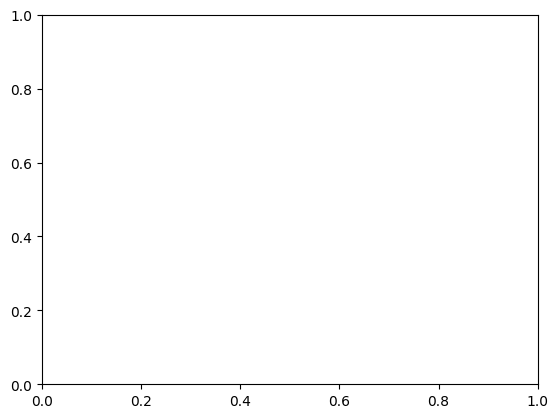

In [175]:
# Create some test data
data = t.detach().cpu().numpy()

# Compute the CDF
CY = np.cumsum(Y * dx)

# Plot both
plt.plot(X, CY, 'r--')

plt.show()


In [171]:
Y.shape

(200,)

AttributeError: Polygon.set() got an unexpected keyword argument 'normed'

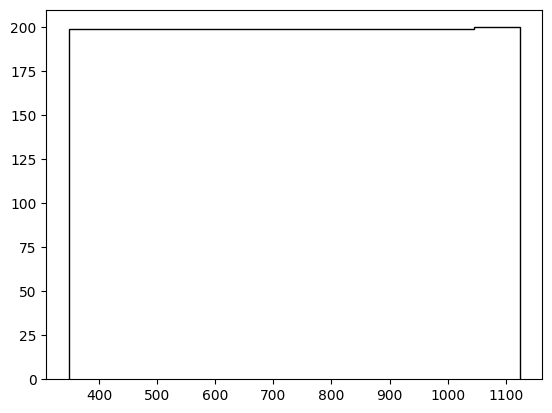

In [162]:
plt.hist(t.detach().cpu().numpy() , normed=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k')

In [ ]:
## lets see the histograam of SINR in each cell
## Plot histogram:
bins = np.linspace(math.ceil(np.min(l)), 
                   math.floor(np.max(l)),
                   100) # fixed number of bins
# bins = np.array([-6,-3, 6, 27])
plt.hist(l, bins=bins, alpha=0.5)


plt.show()

In [139]:
BW_ls[5:12]

[100, 125, 150, 175, 200, 300, 400]

In [673]:
data_test['SINR_mtx'][:,18]

tensor([ -0.1488, -29.4961, -37.8402, -18.3057,  -5.8017, -21.8119,  -4.1502])

In [672]:
data_test['UE_PRB_All_cells'][18,:]

tensor([   5., 2977., 2977., 2977., 2977., 2977.,   13.])

In [687]:
data_test['UE_Ass_rsrp_mtx'][18,:]
data_test

DataBatch(x=[50, 21], edge_index=[2, 994], SINR_mtx=[7, 50], UE_PRB_All_cells=[50, 7], UE_Ass_rsrp_mtx=[50, 7], UE_Ass_sinr_mtx=[50, 7], Conn_mtx=[50, 7], Cell_Edge_id=[12], batch=[50], ptr=[2])

In [695]:
ue_nom=33
print(f'SINR Values:       {data_test.SINR_mtx[:,ue_nom]}')
print(f'PRB Allocation:    {data_test.UE_PRB_All_cells[ue_nom,:]}')
print(f'RSRP Associationn: {data_test.UE_Ass_rsrp_mtx[ue_nom,:]}')

SINR Values:       tensor([ -1.8491, -12.4875, -10.0514, -20.1251,  -7.3989, -10.3302,  -5.6758])
PRB Allocation:    tensor([   8., 2977., 2977., 2977., 2977., 2977., 2977.])
RSRP Associationn: tensor([0., 0., 0., 0., 0., 0., 1.])


51


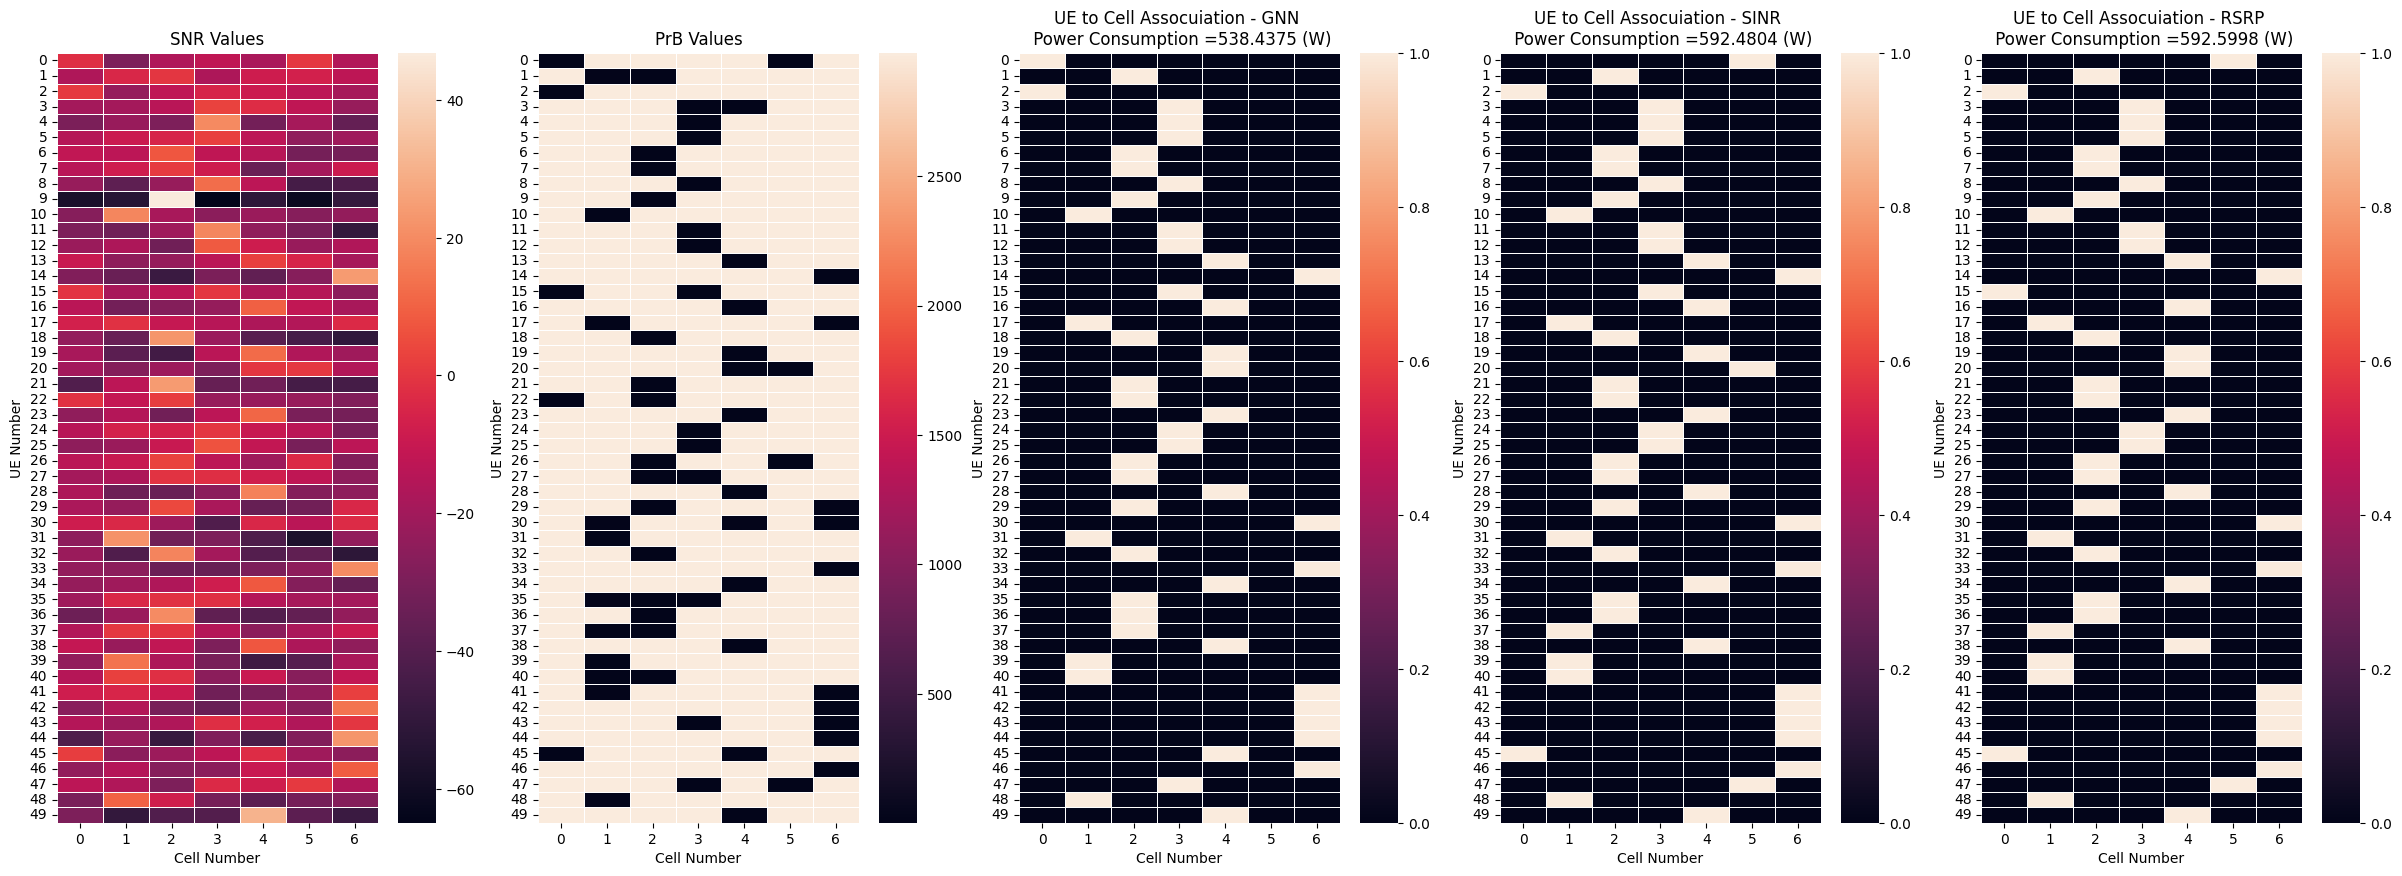

GNN:  PrB Distribution: tensor([12., 13., 42., 33., 27.,  0., 22.]), ====>> Total PrB: 149.0, ====>> Total PWR: 538.4375
RSRP: PrB Distribution: tensor([13., 18., 37., 18., 19.,  9., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.5998
SINR: PrB Distribution: tensor([ 8., 18., 37., 23., 14., 14., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.4804


In [72]:

import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom = np.random.randint(200)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)




fig = plt.figure(figsize=(30, 10))

ax2 = fig.add_subplot(1, 5, 1)
sns.heatmap(data_test['SINR_mtx'].detach().numpy().transpose() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('SNR Values')


ax1 = fig.add_subplot(1, 5, 2)
sns.heatmap(data_test['UE_PRB_All_cells'].detach().numpy() , linewidth=0.5)
ax1.set_xlabel('Cell Number')
ax1.set_ylabel('UE Number')
ax1.set_title('PrB Values')

ax2 = fig.add_subplot(1, 5, 3)
sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - GNN \n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 5, 4)
sns.heatmap(data_test['UE_Ass_sinr_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))


ax2 = fig.add_subplot(1, 5, 5)
sns.heatmap(data_test['UE_Ass_rsrp_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))


plt.show()


print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [71]:
print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

GNN:  PrB Distribution: tensor([12., 13., 42., 33., 27.,  0., 22.]), ====>> Total PrB: 149.0, ====>> Total PWR: 538.4375
RSRP: PrB Distribution: tensor([13., 18., 37., 18., 19.,  9., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.5998
SINR: PrB Distribution: tensor([ 8., 18., 37., 23., 14., 14., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.4804


In [140]:
print(BS_PRB_GNN.sum())
print(BS_PRB_RSRP.sum())
print(BS_PRB_SINR.sum())

tensor(129.)
tensor(129.)
tensor(129.)


## Extereme test

6


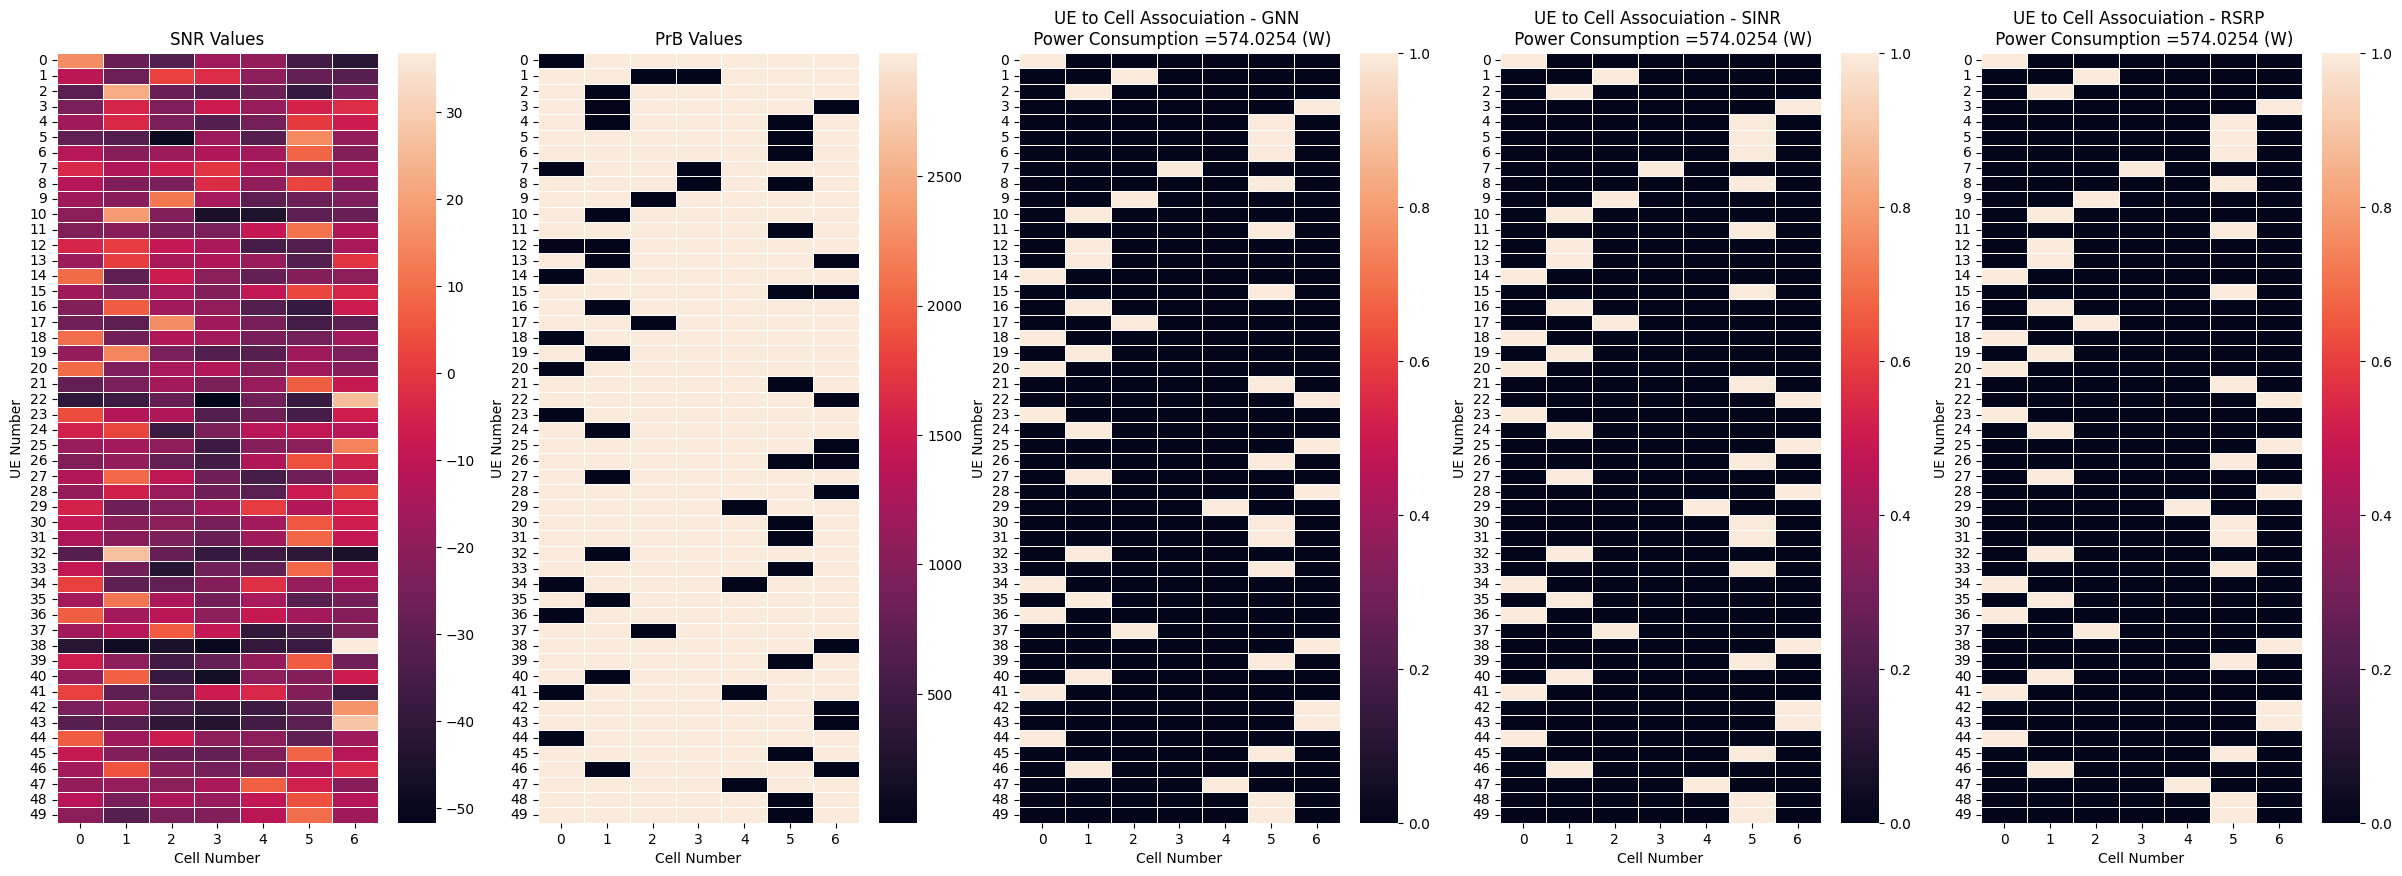

GNN:  PrB Distribution: tensor([21., 26.,  7.,  5.,  6., 37., 16.]), ====>> Total PrB: 118.0, ====>> Total PWR: 574.0254
RSRP: PrB Distribution: tensor([21., 26.,  7.,  5.,  6., 37., 16.]), ====>> Total PrB: 118.0, ====>> Total PWR: 574.0254
SINR: PrB Distribution: tensor([21., 26.,  7.,  5.,  6., 37., 16.]), ====>> Total PrB: 118.0, ====>> Total PWR: 574.0254


In [109]:

import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom = np.random.randint(50)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(Extereme_test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)




fig = plt.figure(figsize=(30, 10))

ax2 = fig.add_subplot(1, 5, 1)
sns.heatmap(data_test['SINR_mtx'].detach().numpy().transpose() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('SNR Values')


ax1 = fig.add_subplot(1, 5, 2)
sns.heatmap(data_test['UE_PRB_All_cells'].detach().numpy() , linewidth=0.5)
ax1.set_xlabel('Cell Number')
ax1.set_ylabel('UE Number')
ax1.set_title('PrB Values')

ax2 = fig.add_subplot(1, 5, 3)
sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - GNN \n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 5, 4)
sns.heatmap(data_test['UE_Ass_sinr_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))


ax2 = fig.add_subplot(1, 5, 5)
sns.heatmap(data_test['UE_Ass_rsrp_mtx'].detach().numpy() , linewidth=0.5)
ax2.set_xlabel('Cell Number')
ax2.set_ylabel('UE Number')
ax2.set_title('UE to Cell Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))


plt.show()


print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [292]:
torch.nonzero(BS_PRB_GNN, as_tuple=True)

(tensor([0, 1, 2, 4, 5, 6]),)

In [294]:
intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

tensor([65., 65., 65.,  0., 65., 65., 65.], dtype=torch.float16)

## Check the difference



In [128]:
sns.heatmap(out_test.detach().numpy()- data_test['UE_Ass_sinr_mtx'].detach().numpy().transpose())

ValueError: operands could not be broadcast together with shapes (50,7) (7,50) 

In [513]:
data_test

DataBatch(x=[50, 21], edge_index=[2, 652], SINR_mtx=[7, 50], UE_PRB_All_cells=[50, 7], UE_Ass_rsrp_mtx=[7, 50], batch=[50], ptr=[2])

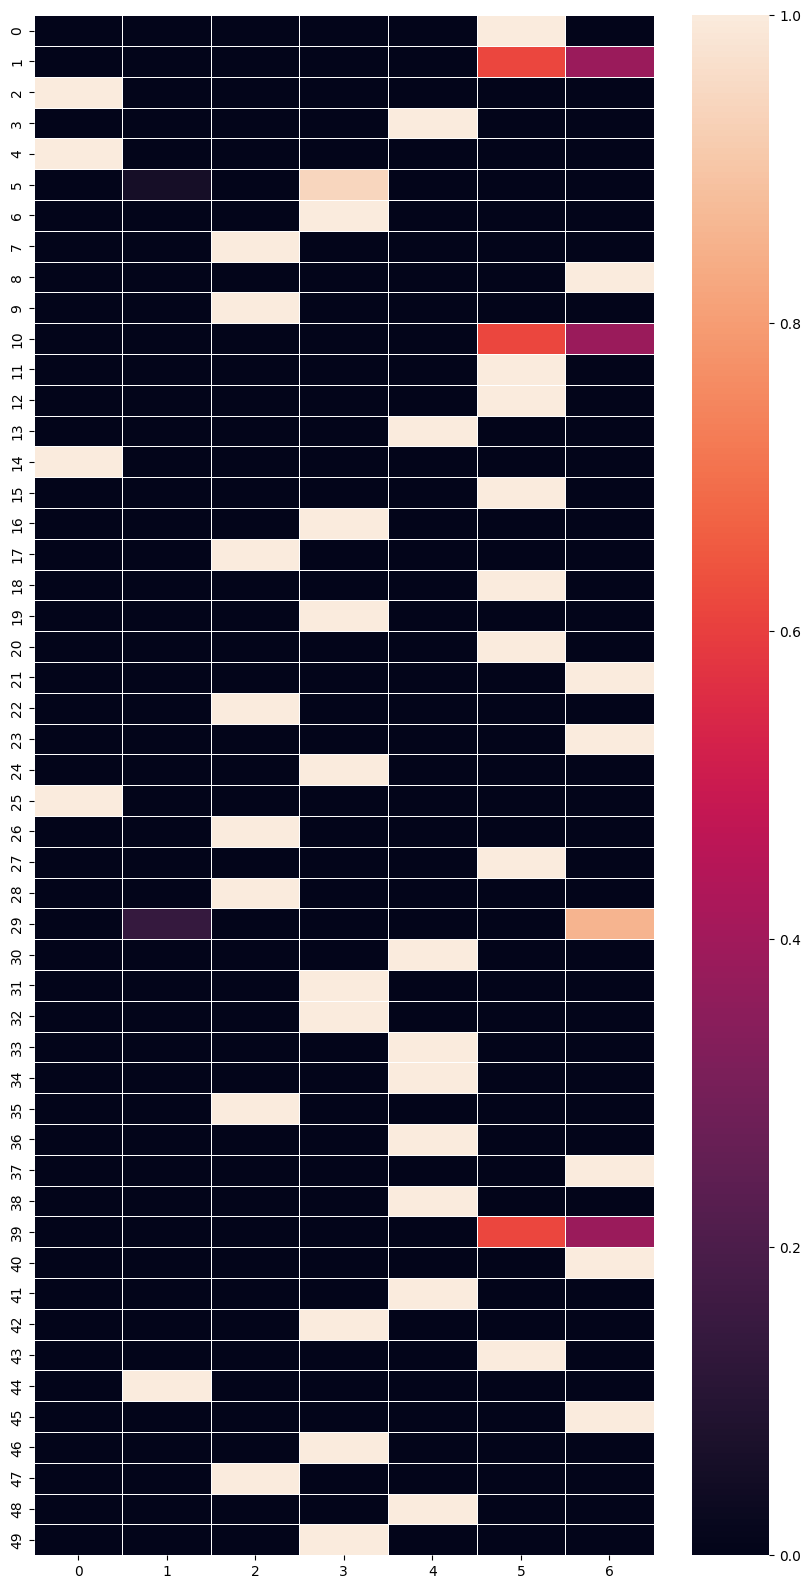

In [66]:
import seaborn as sns
fig = plt.figure(figsize=(10, 20))
Tensor_a= sns.heatmap(out_test.detach().numpy() , linewidth=0.5)
plt.show()

In [145]:
torch.stack(loss_ls).mean().item()

87.77828216552734

In [270]:
out_test

tensor([[2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.9189e-09,
         1.0645e-06],
        [2.0027e-07, 2.4463e-09, 1.6674e-09, 1.9055e-08, 1.0000e+00, 3.91

In [74]:
data_test['UE_PRB_All_cells']

tensor([[ 4., 13., 13., 13., 13., 13., 13.],
        [13.,  8., 10., 13., 13., 13., 13.],
        [ 7., 13., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  3.],
        [13., 13.,  5.,  8., 13., 13., 13.],
        [13.,  8., 13., 13., 13., 13., 13.],
        [ 7., 13., 13., 13.,  8., 13., 13.],
        [13., 13., 13., 13.,  7., 13., 13.],
        [13., 13., 13., 13.,  4., 10., 13.],
        [13., 13., 13., 13.,  3., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  3.],
        [13., 13., 13.,  8., 13., 13., 13.],
        [13., 13., 13.,  3., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  2.],
        [13., 13.,  2., 13., 13., 13., 13.],
        [13., 13., 13., 13.,  1., 13., 13.],
        [13., 13., 13., 13.,  4., 13., 13.],
        [13.,  3., 13., 13., 13., 13., 13.],
        [13., 13.,  4., 13., 13., 13., 13.],
        [13., 13., 13.,  3., 13., 13., 13.],
        [13., 13., 13.,  5., 13., 13., 13.],
        [13., 13., 13.,  3., 13., 13., 13.],
        [ 

In [206]:
torch.norm(F.relu((out_test*data_test['UE_PRB_All_cells']).sum(dim=0)-100*torch.ones(7)),2)

tensor(461.9993, grad_fn=<NormBackward1>)

In [84]:
torch.matmul(out_test['UE'][11],data['UE_PRB_All_cells'][11])

TypeError: new(): invalid data type 'str'

In [359]:
data['UE_PRB_All_cells']

tensor([[13., 13., 13., 13., 13.,  3., 13.],
        [13.,  2., 13., 13., 13., 13., 13.],
        [ 8.,  8., 13., 13., 13., 13., 13.],
        [10., 13., 13.,  7., 13., 13., 13.],
        [13., 13., 13., 13.,  3., 13., 13.],
        [13., 13., 13., 13.,  3., 13., 13.],
        [ 4., 13., 13., 13., 13., 13., 13.],
        [13.,  7.,  8., 13., 13., 13., 13.],
        [ 2., 13., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  5.],
        [13., 13., 13., 13., 13., 13.,  2.],
        [13., 13., 13.,  1., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13.,  3.],
        [13., 13., 13., 13., 13.,  1., 13.],
        [ 3., 13., 13., 13., 13., 13., 13.],
        [ 5., 13., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13., 13., 13., 13.],
        [13.,  1., 13., 13., 13., 13., 13.],
        [13., 13., 13., 13.,  2., 13., 13.],
        [13., 13., 13., 13.,  5., 13., 13.],
        [ 5., 13., 13., 13., 13., 13., 13.],
        [13., 13.,  3., 13., 13., 13., 13.],
        [1

In [125]:
torch.diag(torch.matmul(out_test,torch.t(data['UE_PRB_All_cells'])))

tensor([ 2., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,  4., 13.,  3.,
         3., 13., 13.,  7., 13., 13.,  7.,  8., 13., 13., 13., 10., 13., 13.,
        13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,  3., 13., 13., 13.,
        13., 13., 13.,  3., 13., 13.,  2., 13.], grad_fn=<DiagBackward0>)

## Color network X graph

tensor([50., 63., 76., 18., 19., 11., 31.])

tensor(705.4165)

In [114]:
poly_features_test = poly.fit_transform(BS_PRB_GNN.numpy().reshape(1, -1))
y_predicted_test = poly_reg_model.predict(poly_features_test)
y_predicted_test

ValueError: X has 36 features, but LinearRegression is expecting 3 features as input.

51


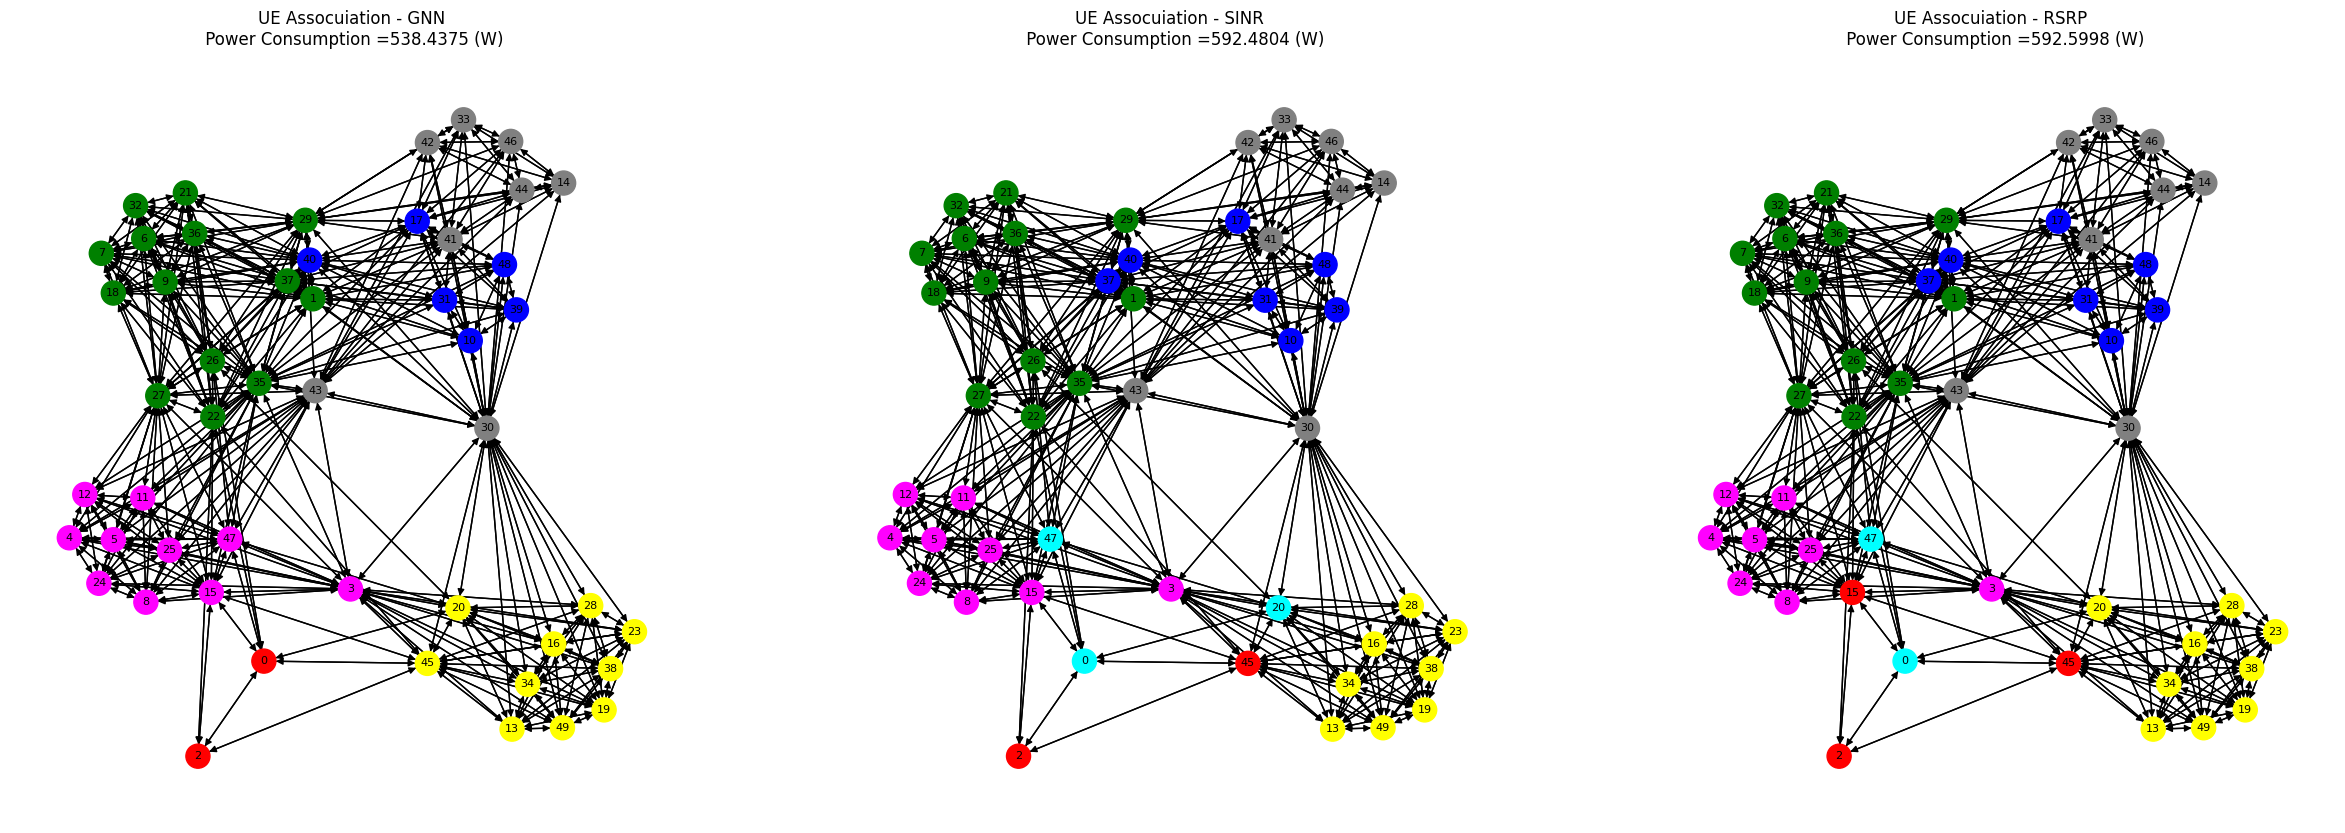

GNN:  PrB Distribution: tensor([12., 13., 42., 33., 27.,  0., 22.]), ====>> Total PrB: 149.0, ====>> Total PWR: 538.4375
RSRP: PrB Distribution: tensor([13., 18., 37., 18., 19.,  9., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.5998
SINR: PrB Distribution: tensor([ 8., 18., 37., 23., 14., 14., 22.]), ====>> Total PrB: 136.0, ====>> Total PWR: 592.4804


In [73]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data


import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom =51# np.random.randint(135)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)


# sample=130
# adj_t= data_set_processed['Adj_mtx'][sample]
# edge_index = torch.tensor(adj_t.nonzero())
# UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample]), axis=1)

# x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
Homodata = Data(x=data_test.x, edge_index=data_test.edge_index)
    
## find color map
edge_index = (T_GNN > 0).nonzero().t()
row, col = edge_index
# edge_index
colors=['red', 'blue', 'green', 'magenta', 'yellow', 'cyan', 'gray']
color_map_GNN=[]
color_map_RSRP=[]
color_map_SINR=[]
for t in range(50):
    color_map_GNN.append(colors[[idx for idx in range(BS_nom) if T_GNN[t,idx]==1][0]])
    color_map_RSRP.append(colors[[idx for idx in range(BS_nom) if T_RSRP[t,idx]==1][0]])
    color_map_SINR.append(colors[[idx for idx in range(BS_nom) if T_SINR[t,idx]==1][0]])

    
    
    
g_GNN = torch_geometric.utils.to_networkx(Homodata, remove_self_loops=True)

# random_pos = nx.random_layout(graph, seed=42)
# pos = nx.spring_layout(graph, pos=random_pos)
pos = nx.spring_layout(g_GNN)


# larger figure size
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1, 3, 1)

# nx.draw_networkx(G,
#                 pos=nx.spring_layout(G, seed=0),
#                 with_labels=True,
#                 node_size=800,
#                 node_color=data.y,
#                 cmap="hsv",
#                 vmin=-2,
#                 vmax=3,
#                 width=0.8,
#                 edge_color="grey",
#                 font_size=14
#                 )


nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_GNN, pos=pos, ax=ax1)
ax1.set_title('UE Assocuiation - GNN\n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 3, 2)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_SINR, pos=pos, ax=ax2)
ax2.set_title('UE Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))

ax3 = fig.add_subplot(1, 3, 3)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_RSRP, pos=pos, ax=ax3)
ax3.set_title('UE Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))

# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.png')
# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.pdf')


plt.show()

print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [182]:
print(BS_PRB_GNN)
print(BS_PRB_RSRP)
print(BS_PRB_SINR)

tensor([31., 17.,  9., 16., 15., 17., 29.])
tensor([19., 17., 22., 16., 15., 17., 29.])
tensor([23., 17., 17., 16., 15., 17., 29.])


## Extereme Example

16


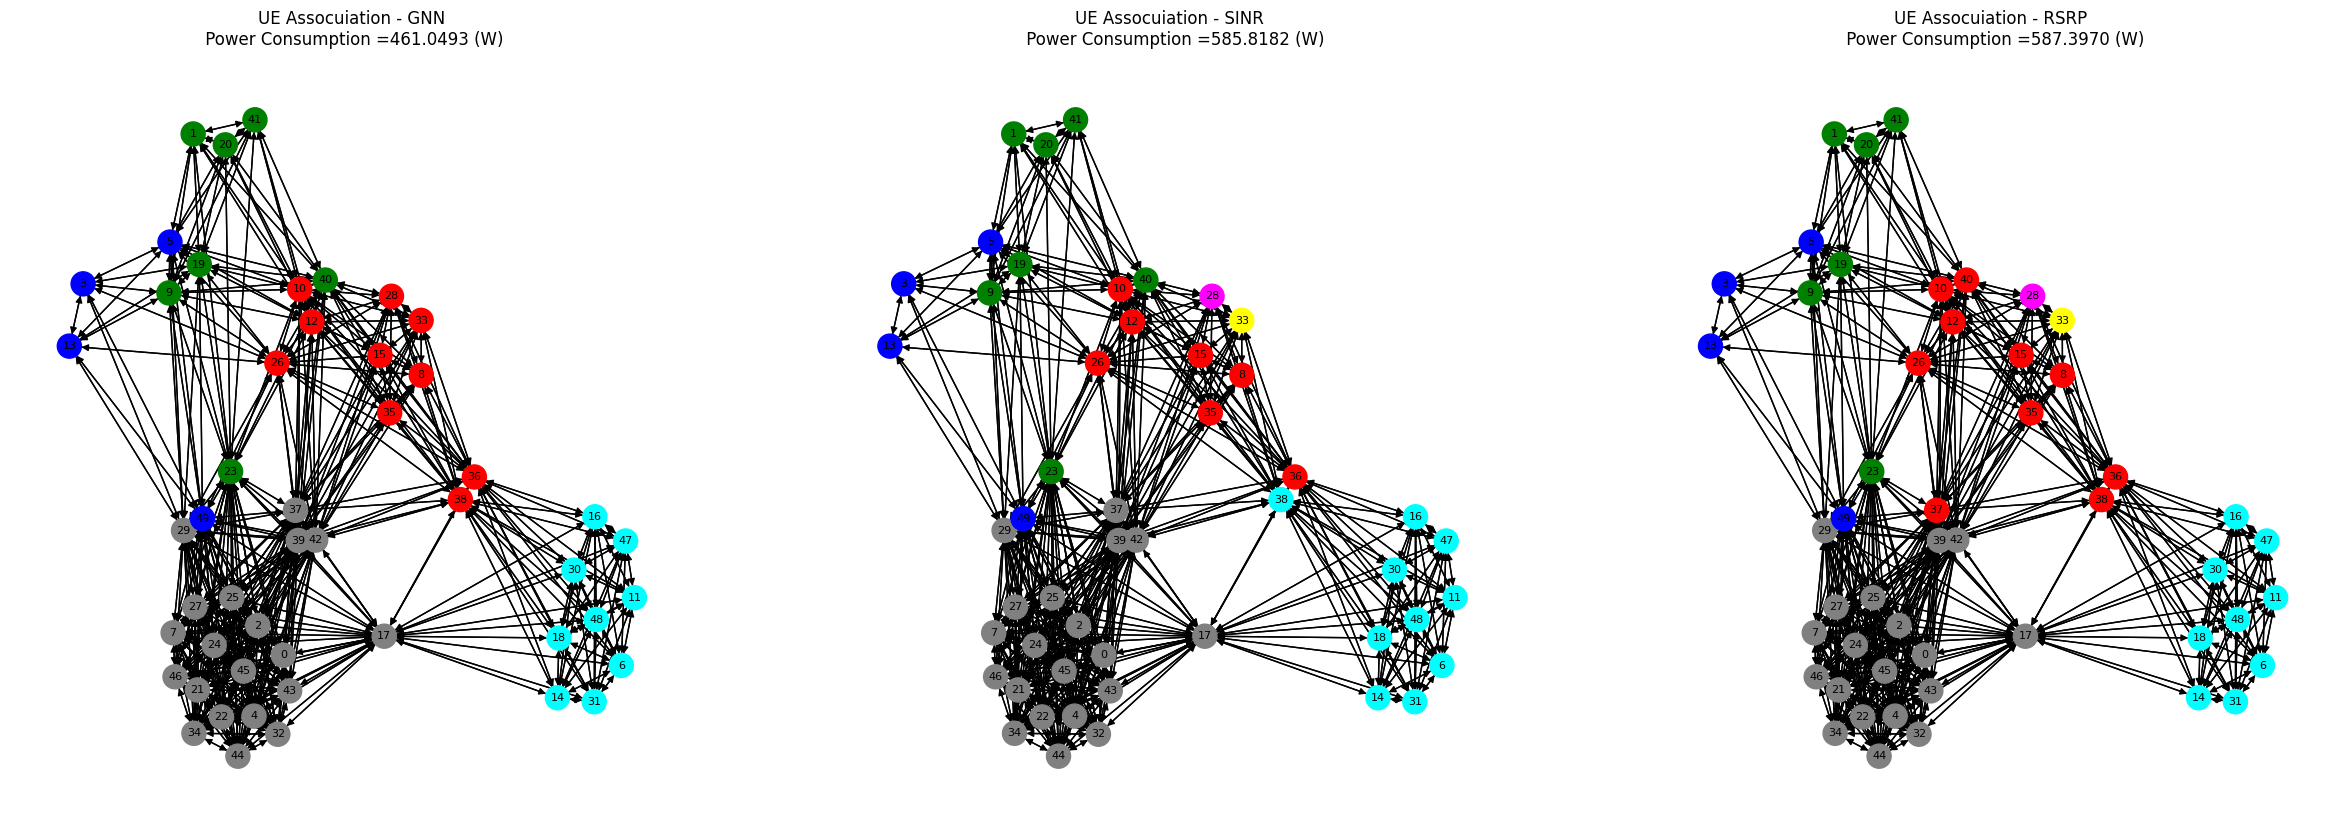

GNN:  PrB Distribution: tensor([47.,  7., 23.,  0.,  0., 17., 45.]), ====>> Total PrB: 139.0, ====>> Total PWR: 461.0493
RSRP: PrB Distribution: tensor([39.,  7., 19.,  5.,  5., 17., 41.]), ====>> Total PrB: 133.0, ====>> Total PWR: 587.3970
SINR: PrB Distribution: tensor([21.,  7., 23.,  5.,  5., 25., 45.]), ====>> Total PrB: 131.0, ====>> Total PWR: 585.8182


In [341]:
import torch_geometric
import networkx as nx
from torch_geometric.data import Data

import seaborn as sns
BS_nom = 7
UE_nom=50
device= 'cpu'

sample_nom =16# np.random.randint(50)
print(sample_nom)
# GNN_homo_model= Test_GNN_homo_model
GNN_homo_model.eval()
data_test=list(enumerate(Extereme_test_loader))[sample_nom][1]
out_test = GNN_homo_model(data_test)  # Perform a single forward pass.


out_test= out_test.to('cpu')

T_GNN= torch.zeros((UE_nom,BS_nom))
L_GNN= torch.argmax(out_test, dim=1)
for l in range(len(L_GNN)):
    T_GNN[l,L_GNN[l].item()] = 1
T_RSRP = data_test['UE_Ass_rsrp_mtx']
T_SINR = data_test['UE_Ass_sinr_mtx']

## Power Consumption
BS_PRB_GNN =   (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_SINR = (T_SINR* data_test['UE_PRB_All_cells']).sum(dim=0)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# Power_Cons_RSRP = torch.tensor( regr.predict(BS_PRB_RSRP.reshape(-1, 1))).sum()

coefs = torch.tensor(poly_reg_model.coef_, dtype= torch.float32, device= device).reshape(1, -1)
intercepts = torch.tensor(poly_reg_model.intercept_, device= device)

poly_features_GNN = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_GNN], dtype= torch.float32, device= device)
Power_Cons_GNN= torch.matmul(coefs[0],torch.t(poly_features_GNN))+intercepts*torch.where(BS_PRB_GNN > 0, 1, 0)

poly_features_RSRP = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_RSRP], dtype= torch.float32, device= device)
Power_Cons_RSRP= torch.matmul(coefs[0],torch.t(poly_features_RSRP))+intercepts*torch.where(BS_PRB_RSRP > 0, 1, 0)

poly_features_SINR = torch.tensor([[x.item() , x.item()**2] for x in BS_PRB_SINR], dtype= torch.float32, device= device)
Power_Cons_SINR= torch.matmul(coefs[0],torch.t(poly_features_SINR))+intercepts*torch.where(BS_PRB_SINR > 0, 1, 0)



# sample=130
# adj_t= data_set_processed['Adj_mtx'][sample]
# edge_index = torch.tensor(adj_t.nonzero())
# UE_feature_mtx = np.concatenate((data_set_processed['UE_relative_dist_mtx'][sample], data_set_processed['UE_SNR_RU_norm'][sample],  data_set_processed['UE_aggPRB_norm'][sample]), axis=1)

# x = torch.tensor(UE_feature_mtx, dtype=torch.float32) 
Homodata = Data(x=data_test.x, edge_index=data_test.edge_index)
    
## find color map
edge_index = (T_GNN > 0).nonzero().t()
row, col = edge_index
# edge_index
colors=['red', 'blue', 'green', 'magenta', 'yellow', 'cyan', 'gray']
color_map_GNN=[]
color_map_RSRP=[]
color_map_SINR=[]
for t in range(50):
    color_map_GNN.append(colors[[idx for idx in range(BS_nom) if T_GNN[t,idx]==1][0]])
    color_map_RSRP.append(colors[[idx for idx in range(BS_nom) if T_RSRP[t,idx]==1][0]])
    color_map_SINR.append(colors[[idx for idx in range(BS_nom) if T_SINR[t,idx]==1][0]])

    
    
    
g_GNN = torch_geometric.utils.to_networkx(Homodata, remove_self_loops=True)

# random_pos = nx.random_layout(graph, seed=42)
# pos = nx.spring_layout(graph, pos=random_pos)
pos = nx.spring_layout(g_GNN)


# larger figure size
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1, 3, 1)

# nx.draw_networkx(G,
#                 pos=nx.spring_layout(G, seed=0),
#                 with_labels=True,
#                 node_size=800,
#                 node_color=data.y,
#                 cmap="hsv",
#                 vmin=-2,
#                 vmax=3,
#                 width=0.8,
#                 edge_color="grey",
#                 font_size=14
#                 )


nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_GNN, pos=pos, ax=ax1)
ax1.set_title('UE Assocuiation - GNN\n Power Consumption ={:.4f} (W)'.format(Power_Cons_GNN.sum()))

ax2 = fig.add_subplot(1, 3, 2)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_SINR, pos=pos, ax=ax2)
ax2.set_title('UE Assocuiation - SINR \n Power Consumption ={:.4f} (W)'.format(Power_Cons_SINR.sum()))

ax3 = fig.add_subplot(1, 3, 3)
nx.draw(g_GNN, node_size=300,font_size=8, with_labels=True, node_color=color_map_RSRP, pos=pos, ax=ax3)
ax3.set_title('UE Assocuiation - RSRP \n Power Consumption ={:.4f} (W)'.format(Power_Cons_RSRP.sum()))

# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.png')
# plt.savefig('figs/NXPlot_TraceConst_HomoGraph_infPrB_v4.pdf')


plt.show()

print(f'GNN:  PrB Distribution: {BS_PRB_GNN}, ====>> Total PrB: {BS_PRB_GNN.sum()}, ====>> Total PWR: {Power_Cons_GNN.sum():.4f}')
print(f'RSRP: PrB Distribution: {BS_PRB_RSRP}, ====>> Total PrB: {BS_PRB_RSRP.sum()}, ====>> Total PWR: {Power_Cons_RSRP.sum():.4f}')
print(f'SINR: PrB Distribution: {BS_PRB_SINR}, ====>> Total PrB: {BS_PRB_SINR.sum()}, ====>> Total PWR: {Power_Cons_SINR.sum():.4f}')

In [342]:
(587.3970-461.0493)/587.3970

0.21509762562628004

In [165]:
print(data_test['SINR_mtx'].t()[sample1])
print(data_test['SINR_mtx'].t()[sample2])

tensor([ -4.9107,  -3.9557,  -8.5593,  -2.9378, -13.2502, -29.1873, -26.2687])
tensor([-20.9543, -21.3873, -21.7782,   2.3277,  -4.0355,  -7.4943, -26.4149])


In [166]:
print(data_test['UE_PRB_All_cells'][sample1])
print(data_test['UE_PRB_All_cells'][sample2])

tensor([  13.,   10., 2977.,    8., 2977., 2977., 2977.])
tensor([2977., 2977., 2977.,    3.,   13., 2977., 2977.])


In [85]:
print(data_test.x[sample1])
print(data_test.x[sample2])

tensor([1.8056e-04, 2.3166e-04, 2.2412e-04, 2.0856e-04, 2.0033e-04, 2.1185e-04,
        2.2659e-04, 1.8428e-04, 1.3937e-04, 9.8362e-05, 1.0890e-04, 1.2126e-04,
        1.6145e-04, 2.7670e-04, 3.6539e-04, 1.9923e-01, 1.9923e-01, 1.9923e-01,
        6.9973e-04, 1.9923e-01, 1.9923e-01, 2.3166e-04])
tensor([1.8760e-04, 2.3160e-04, 2.2965e-04, 2.1281e-04, 1.9048e-04, 1.9504e-04,
        2.1786e-04, 1.8340e-04, 1.7890e-04, 1.5910e-04, 1.2135e-04, 1.4646e-04,
        2.3043e-04, 2.3681e-04, 6.9953e-04, 1.9917e-01, 1.9917e-01, 1.9917e-01,
        4.9899e-04, 1.9917e-01, 1.9917e-01, 2.3160e-04])


## Animation

In [ ]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

In [80]:
Power_Cons_GNN.sum()

568.3777847290039

In [107]:
poly_features_GNN

array([[1.000e+00, 2.200e+01, 8.000e+00, 3.200e+01, 3.900e+01, 2.900e+01,
        1.000e+00, 1.100e+01, 4.840e+02, 1.760e+02, 7.040e+02, 8.580e+02,
        6.380e+02, 2.200e+01, 2.420e+02, 6.400e+01, 2.560e+02, 3.120e+02,
        2.320e+02, 8.000e+00, 8.800e+01, 1.024e+03, 1.248e+03, 9.280e+02,
        3.200e+01, 3.520e+02, 1.521e+03, 1.131e+03, 3.900e+01, 4.290e+02,
        8.410e+02, 2.900e+01, 3.190e+02, 1.000e+00, 1.100e+01, 1.210e+02]])

In [81]:
## Power Consumption
BS_PRB_GNN = (T_GNN* data_test['UE_PRB_All_cells']).sum(dim=0)
BS_PRB_RSRP = (T_RSRP* data_test['UE_PRB_All_cells']).sum(dim=0)

BS_PRB_GNN


tensor([23.,  8., 20., 10., 25., 18.,  7.])

In [126]:
poly = PolynomialFeatures(degree=2, include_bias=True)
x_ = np.array([i[0] for i in x])
poly_features = poly.fit_transform(x_.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)



poly_features_GNN = poly.fit_transform(np.array([i.item() for i in BS_PRB_GNN]).reshape(1, -1))
Power_Cons_GNN = poly_reg_model.predict(poly_features_GNN)
# Power_Cons_GNN = torch.tensor( regr.predict(BS_PRB_GNN.reshape(-1, 1))).sum()
# poly_features_RSRP = poly.fit_transform(BS_PRB_RSRP.reshape(1, -1))
# Power_Cons_RSRP = poly_reg_model.predict(poly_features_RSRP)

ValueError: X has 36 features, but LinearRegression is expecting 3 features as input.

In [129]:
np.array([i.item() for i in BS_PRB_GNN]).reshape(1, -1).shape

(1, 7)

In [134]:
poly = PolynomialFeatures(degree=2, include_bias=True)
poly_features_ = poly.fit_transform(np.array([i.item() for i in BS_PRB_GNN]).reshape(1, -1).reshape(-1,1))
poly_reg_model.predict(poly_features_)

array([[ 87.30514526],
       [ 73.37841797],
       [ 96.6796875 ],
       [102.95769501],
       [ 93.91747284],
       [ 66.06401825],
       [ 76.44152069]])

In [103]:
BS_PRB_RSRP

tensor([32., 11., 23.,  7.,  5., 28.,  8.])

In [141]:
BS_PRB_RSRP.sum()

NameError: name 'BS_PRB_RSRP' is not defined

In [150]:
import torch
BS_PRB_RSRP = torch.tensor([28., 29., 32., 28., 44., 28., 21.])
BS_PRB_GNN = torch.tensor([ 8., 42., 19., 28., 52., 30., 52.])
# torch.norm(BS_PRB_RSRP, p=2)
BS_PRB_GNN.sum()

tensor(231.)

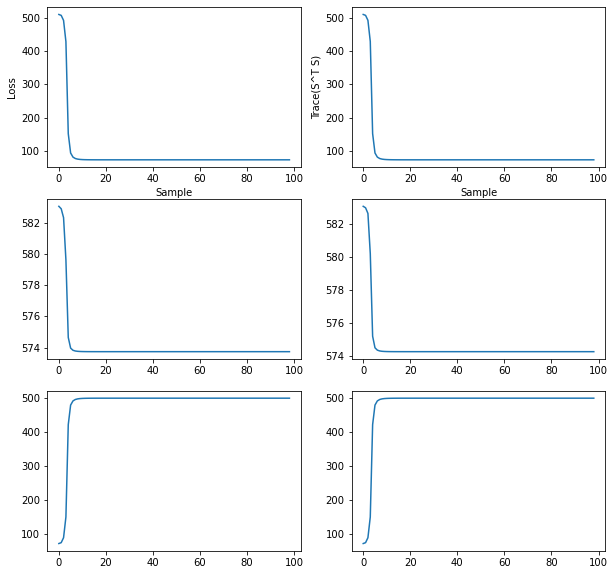

In [220]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

ax1.plot(train_loss_list, label='data 1')
ax2.plot(test_loss_list, label='data 2')
ax3.plot(train_Avg_PrB_list, label='data 1')
ax4.plot(test_Avg_PrB_list, label='data 2')

ax5.plot(train_Reg_list, label='data 1')
ax6.plot(test_Reg_list, label='data 2')

ax1.set_xlabel('Sample')
ax1.set_ylabel('Loss')
# ax1.set_title('first data set')
# ax1.legend()
ax2.set_xlabel('Sample')
ax2.set_ylabel('Trace(S^T S)')
# ax2.set_title('second data set')
# ax2.legend()

plt.show()

In [308]:
data=list(enumerate(train_loader))[10][1]
GNN_homo_model = GNN(hidden_channels=200, out_channels=7)
GNN_hetro_model = to_hetero(GNN_homo_model, data.metadata(), aggr='sum')
lambda_ = 10
# GNN_hetro_model.eval()
GNN_hetro_model.train()
out = GNN_hetro_model(data.x_dict, data.edge_index_dict)  # Perform a single forward pass.
l, b, c, = Linear_combinaton_PRB(out, data, lambda_)
l
# param_grad = list(GNN_hetro_model.parameters())[0].grad[1][0:3]
# param_grad
# GNN_hetro_model.train()
# for data in loader:  # Iterate in batches over the training dataset.
# #         out = model(Graph_data.x, Graph_data.edge_index, Graph_data.batch, Graph_data.UE_cluster)  # Perform a single forward pass.
#     out = model(data.x_dict, data.edge_index_dict)  # Perform a single forward pass.

#     UE_Ass_tensor = Calc_UE_Association(out)
#     SNR_mtx_tensor = data['SINR_mtx']
#     BS_PRB_Percentage = Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df)
#     loss = Calc_Energy(BS_PRB_Percentage, regr).sum() ## Energy consumption
#     loss.requires_grad= True
# #         print(loss.item())
#     loss.backward()  # Derive gradients.
#     optimizer.step()  # Update parameters based on gradients.
#     optimizer.zero_grad()  # Clear gradients.
        
        

tensor(657.5682, grad_fn=<AddBackward0>)

In [147]:
for name, param in GNN_hetro_model.named_parameters():
  print(name, param.requires_grad)

conv1.UE__to__BS.lin_l.weight True
conv1.UE__to__BS.lin_l.bias True
conv1.UE__to__BS.lin_r.weight True
conv1.BS__rev_to__UE.lin_l.weight True
conv1.BS__rev_to__UE.lin_l.bias True
conv1.BS__rev_to__UE.lin_r.weight True
conv2.UE__to__BS.lin_l.weight True
conv2.UE__to__BS.lin_l.bias True
conv2.UE__to__BS.lin_r.weight True
conv2.BS__rev_to__UE.lin_l.weight True
conv2.BS__rev_to__UE.lin_l.bias True
conv2.BS__rev_to__UE.lin_r.weight True
conv3.UE__to__BS.lin_l.weight True
conv3.UE__to__BS.lin_l.bias True
conv3.UE__to__BS.lin_r.weight True
conv3.BS__rev_to__UE.lin_l.weight True
conv3.BS__rev_to__UE.lin_l.bias True
conv3.BS__rev_to__UE.lin_r.weight True
lin.UE.weight True
lin.UE.bias True
lin.BS.weight True
lin.BS.bias True


In [306]:
test(test_loader, GNN_hetro_model)

In [309]:
torch.stack(a).mean().item()

58.02411651611328

In [465]:

for name, param in GNN_hetro_model.state_dict().items():
    print(name)


conv1.UE__to__BS.lin_l.weight
conv1.UE__to__BS.lin_l.bias
conv1.UE__to__BS.lin_r.weight
conv1.BS__rev_to__UE.lin_l.weight
conv1.BS__rev_to__UE.lin_l.bias
conv1.BS__rev_to__UE.lin_r.weight
conv2.UE__to__BS.lin_l.weight
conv2.UE__to__BS.lin_l.bias
conv2.UE__to__BS.lin_r.weight
conv2.BS__rev_to__UE.lin_l.weight
conv2.BS__rev_to__UE.lin_l.bias
conv2.BS__rev_to__UE.lin_r.weight
conv3.UE__to__BS.lin_l.weight
conv3.UE__to__BS.lin_l.bias
conv3.UE__to__BS.lin_r.weight
conv3.BS__rev_to__UE.lin_l.weight
conv3.BS__rev_to__UE.lin_l.bias
conv3.BS__rev_to__UE.lin_r.weight
lin.UE.weight
lin.UE.bias
lin.BS.weight
lin.BS.bias


In [289]:

# torch.mean(torch.stack(train_acc))
train_acc[:, ~torch.stack(train_acc).isnan().any(dim=0).any(dim=0), :]

TypeError: list indices must be integers or slices, not tuple

TypeError: list indices must be integers or slices, not tuple

In [299]:
data=list(enumerate(train_loader))[19][1]

out = GNN_hetro_model(data.x_dict, data.edge_index_dict)  # Perform a single forward pass.
# out['UE']
loss_val = torch.diag(torch.matmul(out['UE'],torch.t(data['UE_PRB_All_cells'])))+lambda_ *torch.norm(out['UE'], p=1, dim=1)
loss_val
# UE_Ass_tensor = Calc_UE_Association(out)
# SNR_mtx_tensor = data['SINR_mtx']
# BS_PRB_Percentage = Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df)
# loss = Calc_Energy(BS_PRB_Percentage, regr).sum() ## Energy consumption
# loss

tensor([47.1634, 43.1453, 44.3414, 43.3580, 45.6963, 48.6174, 46.0163, 43.1545,
        44.4057, 43.6456, 44.7160, 46.5044, 43.6362, 44.5758, 43.6768, 44.3713,
        47.3655, 42.6582, 42.8120, 48.6716, 44.3819, 43.6792, 46.1568, 43.3427,
        45.6415, 48.6367, 43.2028, 44.7247, 45.1845, 44.4167, 44.1568, 44.6390,
        44.5951, 46.1604, 45.5023, 48.6524, 45.2104, 44.4120, 43.2090, 44.7925,
        43.5225, 47.1941, 43.3536, 43.6654, 44.6518, 45.2241, 44.1838, 45.9820,
        43.1458, 43.3452], grad_fn=<AddBackward0>)

In [300]:
torch.norm(out['UE'], p=1, dim=1)

tensor([3.4762, 3.4743, 3.4741, 3.4749, 3.4762, 3.4727, 3.4751, 3.4726, 3.4743,
        3.4749, 3.4776, 3.4753, 3.4734, 3.4741, 3.4736, 3.4763, 3.4754, 3.4762,
        3.4741, 3.4765, 3.4773, 3.4744, 3.4760, 3.4741, 3.4741, 3.4741, 3.4749,
        3.4781, 3.4732, 3.4739, 3.4733, 3.4738, 3.4763, 3.4763, 3.4761, 3.4752,
        3.4752, 3.4734, 3.4753, 3.4759, 3.4773, 3.4777, 3.4748, 3.4782, 3.4762,
        3.4758, 3.4753, 3.4735, 3.4759, 3.4731], grad_fn=<NormBackward1>)

In [301]:
data

HeteroDataBatch(
  SINR_mtx=[7, 50],
  UE_PRB_All_cells=[50, 7],
  UE={
    node_id=[50],
    x=[50, 14],
    batch=[50],
    ptr=[2]
  },
  BS={
    node_id=[7],
    x=[7, 4],
    batch=[7],
    ptr=[2]
  },
  (UE, to, BS)={
    edge_index=[2, 350],
    edge_attr=[350]
  },
  (BS, rev_to, UE)={
    edge_index=[2, 350],
    edge_attr=[350]
  }
)

In [302]:
sum(out['UE'][0])

tensor(3.4762, grad_fn=<AddBackward0>)

In [303]:
# sample_G = Training_list_graph[19][1] #Graph_list[1]

# with torch.no_grad():  # Initialize lazy modules.
#     out = GNN_hetro_model(sample_G.x_dict, data.edge_index_dict)
    
# UE_Ass_tensor = Calc_UE_Association(out)
# SNR_mtx_tensor = sample_G['SINR_mtx']

# SNR_blkdg = torch.empty((0,0),dtype=torch.int64)
# a= torch.split(SNR_mtx_tensor,7, dim=0)
# for i in a:
#     SNR_blkdg= torch.block_diag(SNR_blkdg, i)
# #         print(SNR_blkdg*UE_Ass_tensor)
        
        
# BS_PRB_Percentage = Calc_BS_PrB_percentage(SNR_mtx_tensor, UE_Ass_tensor, Max_PRB, number_of_BS, MCS_SNR_df, batch_size)
# Energy_consumption = Calc_Energy(BS_PRB_Percentage, regr)
# Energy_consumption

In [306]:
data

HeteroDataBatch(
  SINR_mtx=[7, 50],
  UE_PRB_All_cells=[50, 7],
  UE={
    node_id=[50],
    x=[50, 14],
    batch=[50],
    ptr=[2]
  },
  BS={
    node_id=[7],
    x=[7, 4],
    batch=[7],
    ptr=[2]
  },
  (UE, to, BS)={
    edge_index=[2, 350],
    edge_attr=[350]
  },
  (BS, rev_to, UE)={
    edge_index=[2, 350],
    edge_attr=[350]
  }
)

In [278]:
test_acc

[tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan, grad_fn=<SumBackward0>),
 tensor(nan,

NameError: name 'loss' is not defined

In [865]:
cal_Energy(BS_PRB_Percentage, regr)

array([[ 69.52630615],
       [ 69.52630615],
       [ 69.52630615],
       [ 69.52630615],
       [ 69.52630615],
       [515.15270543],
       [ 69.52630615]])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

def train():
    model.train()

    for Graph_data in train_loader:  # Iterate in batches over the training dataset.
#         out = model(Graph_data.x, Graph_data.edge_index, Graph_data.batch, Graph_data.UE_cluster)  # Perform a single forward pass.
        out = model(Graph_data, batch_size)  # Perform a single forward pass.
#         print([out, Graph_data.y])
#         print(Graph_data.y)
        loss = criterion(out, Graph_data.y)  # Compute the loss.
#         print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    for Graph_data in loader:  # Iterate in batches over the training/test dataset.
#         out = model(Graph_data.x, Graph_data.edge_index, Graph_data.batch, Graph_data.UE_cluster)
        out = model(Graph_data, batch_size)
        loss = criterion(out, Graph_data.y)  # Compute the loss.
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == Graph_data.y).sum())  # Check against ground-truth labels.
    return loss  


train_acc_list =[]
test_acc_list = []
for epoch in range(1, 100):
    train()
    
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc.item())
    test_acc_list.append(test_acc.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
from torch.nn import Linear
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, avg_pool

# def _create_cluster_vector_ (UE_cluster, batch, batch_size):
    
#     tuples = [(UE_cluster[i].item(), batch[i].item() ) for i in range(batch.shape[0])]
#     unique_tuples_list = list(set(tuples))
#     labels_dict= {i:unique_tuples_list[i] for i in range(len(unique_tuples_list))}
#     c=[]
#     for i in tuples:
#         c.append([k for k in labels_dict.keys() if labels_dict[k] == i][0])

#     cluster = torch.tensor(c)
    
#     return cluster

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, nom_nodes, num_outputs, batch_size):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(num_node_features, 1)
        self.double()



    def forward(self, Graph, batch_size):
        x, edge_index, batch= Graph.x, Graph.edge_index, Graph.batch, 
#         cluster = _create_cluster_vector_ (Graph.UE_cluster, batch, batch_size)
        # 1. Obtain node embeddings 
#         print(x.shape)
#         x=x.float()
#         print('=== conv1 ===')
        x = self.conv1(x, edge_index)
#         print(x.shape)
        x = x.relu()
#         print(' Relu ----')
#         print(x.shape)
#         print('=== conv2 ===')
        x = self.conv2(x, edge_index)
#         print(x.shape)
#         print(' Relu ----')
        x = x.relu()
#         print(x.shape)
#         print('=== conv3 ===')
        x = self.conv3(x, edge_index)
#         print(x.shape)
        
        # 2. Readout layer
#         x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        data_sample_batch = avg_pool(cluster, Graph)  # [batch_size, hidden_channels]
#         print(data_sample_batch)


        # 3. Apply a final classifier
        x = F.dropout(data_sample_batch.x, p=0.5, training=self.training)
#         print(x.shape)
#         x=x.float()
        x = self.lin(x)
#         print(x.shape)
        
        return x

model = GCN(num_node_features=14, hidden_channels=32, nom_nodes=50, num_outputs=9, batch_size= batch_size)
print(model)

# Test

In [544]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Extracting .\ml-latest-small.zip


In [545]:
# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())
# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

         Action  Adventure  Drama  Horror
movieId                                  
1        0       1          0      0     
2        0       1          0      0     
3        0       0          0      0     
4        0       0          1      0     
5        0       0          0      0     


In [546]:
# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())
# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)
print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0  1       0       
1  2       1       
2  3       2       
3  4       3       
4  5       4       

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0  1        0       
1  3        1       
2  6        2       
3  47       3       
4  50       4       

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])


In [550]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))
# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)


In [554]:
movie_feat.shape

torch.Size([9742, 20])

In [556]:
torch.arange(len(movies_df))

tensor([   0,    1,    2,  ..., 9739, 9740, 9741])

In [559]:
edge_index_user_to_movie

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])